# Actualization Criteria and Self-Consistent Mean-Field Projections

In this tutorial, we will build upon the concepts introduced in the previous tutorial, where we explored different actualization criteria for Adaptive Max-Ent. Notably, we discovered that the **Partial Sum criterion** provides the tightest control over errors, in contrast to the **Lieb-Robinson criterion**, which is lestightnt.  

However, as the complexity of the bases involved in the actualization g linearly with the number of actualizations and with the depth of the basis, $\ell$rows, managing this complexity becomes critical. To address this challenge, a Self-Consistent **Mean-Field (MF) projection** is applied, to reduce and organize the basis while retaining its essential features.  

In this tutorial, we will continue the discussion while maintaining the same initial conditions for the system.  

### Objectives:  

We will introduce two examples of **MF-aided Adaptive Max-Ent simulations**:  
1. The basis of observables is constructed as a **$m_0$-body projected Hierarchical Basis**, where the projection ensures that all elements of the basis remain manageable.  
2. We will demonstrate how Mean-Field projections enable efficient simulations while preserving the accuracy of the Adaptive Max-Ent scheme.  


In [1]:
import sys 
path= '../'
sys.path.insert(1, path) 

### long term ev 
import matplotlib.pyplot as plt
import numpy as np

# Configuration du style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,        # Taille de police
    'axes.labelsize': 14,   # Taille des labels des axes
    'axes.titlesize': 16,   # Taille des titres
    'legend.fontsize': 12,  # Taille des légendes
    'xtick.labelsize': 12,  # Taille des labels des ticks sur l'axe X
    'ytick.labelsize': 12,  # Taille des labels des ticks sur l'axe Y
    'font.family': 'serif', # Police de type "serif" pour un rendu professionnel
    'axes.linewidth': 1.5,  # Largeur des bordures des axes
    'grid.alpha': 0.5       # Transparence des grilles
})

import numpy as np
import scipy.linalg as linalg
import pickle
from datetime import datetime

import qutip as qutip
from typing import Callable, Optional, Tuple
from scipy.optimize import root, fsolve


from IPython.display import display_latex
from alpsqutip.geometry import graph_from_alps_xml, list_graph_in_alps_xml
from alpsqutip.alpsmodels import list_operators_in_alps_xml,model_from_alps_xml
from alpsqutip.utils import eval_expr
from alpsqutip.model import SystemDescriptor
from alpsqutip import restricted_maxent_toolkit as me ## custom library including basic linear algebra functions 
from alpsqutip.proj_evol import safe_exp_and_normalize ## function used to safely and robustly map K-states to states
from alpsqutip.operators import QutipOperator
from alpsqutip.operators.states.meanfield import one_body_from_qutip_operator, project_to_n_body_operator, self_consistent_quadratic_mfa
from alpsqutip.qutip_tools.tools import project_qutip_to_m_body
## functions used for Mean-Field projections



def simulation_label(simulation):
    sim_parms = simulation["parms"]
    result = f"{sim_parms['m0']}, {sim_parms['chosen_depth']}, {latex_scientific_notation(sim_parms['eps'])}, {sim_parms['error_estimator']}"
    result = r"$(m_0, \ell, tol, estimator) \rightarrow "+ f"({result})$"
    return result

def obs_labels(obs_name):
    return obs_name


def latex_scientific_notation(value):
    exponent = int(np.log10(value))
    if exponent:
        value = value / 10**exponent
        return f"{value}" + r" \times 10^{" + str(exponent) +"}"
    return f"{value}"


def lieb_robinson_speed(parameters):
    """Compute the Lieb Robinson speed from the parameters"""
    
    f_factor=np.real(max(np.roots(np.poly1d([1, 0, 
                                             -(parameters['Jx']*parameters['Jy']+
                                               parameters['Jx']*parameters['Jy']+
                                               parameters['Jy']*parameters['Jz']), 
                                             -2*parameters['Jx']*parameters['Jy']*parameters['Jz']])
                                 )
                        )
                    )
    chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
    return 4*f_factor*chi_y

models_lib_file = "../alpsqutip/lib/models.xml"
lattice_lib_file = "../alpsqutip/lib/lattices.xml"
SIMULATIONS_FILE_PREFIX = "simulations_long"

# Load the set of previous simulations

In [2]:
# Here we store the results of the simulations
try:
    with open(f"{SIMULATIONS_FILE_PREFIX}.pkl", "br") as in_file:
        simulations = pickle.load(in_file)

    with open(f"{SIMULATIONS_FILE_PREFIX}_{str(datetime.now())}.bkp", "bw") as out_file:
        pickle.dump(simulations, out_file)
except:
    simulations = {}


# Define the system and objects required for the simulation

## Define the parameters of the system to simulate

* `PARAMS` contains the size of the system, the coupling constants of the Hamiltonian and the coefficients for the initial state.
* `setup_quantum_system()` generates a dictionary with the description of the simulation problem.
* `setup_initial_state()` adds to the dictionary defining the quantum system the initial state, built from the parameters.

In [3]:
lambda phi_local, ws:me.m_th_partial_sum(phi=phi_local, m=2) *5. / me.m_th_partial_sum(phi=phi_local, m=0)

<function __main__.<lambda>(phi_local, ws)>

In [4]:
PARAMS={}

PARAMS['size']=7
PARAMS['Jx']=1.; PARAMS['Jy'] = .75*PARAMS['Jx']; PARAMS['Jz']=1.05*PARAMS['Jx']
PARAMS["phi0"] = np.array([.0, .25, .25, -2.])    # No podemos ir más allá de |phi|< 10, 
                                                   # ya que la matriz de Gram se hace singular. 

ERROR_ESTIMATORS={
    "partial_sum": lambda phi_local, ws:me.m_th_partial_sum(phi=phi_local, m=2)*50. / me.m_th_partial_sum(phi=phi_local, m=0),
#    "weights":  lambda phi_local, ws: sum(abs(phi_a*w_a) for phi_a, w_a in zip(phi_local, ws)),
}


def setup_quantum_system(params:dict):
    """
    Setup a quantum system from the parameters in the dict `params`.
    """
    system=SystemDescriptor(
        model=model_from_alps_xml(models_lib_file, "spin"),
        graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L":params['size'], "a":1}),
        parms={"h":0,"J":params['Jx']}
    )

    sites=[s for s in system.sites]
    sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
    sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
    sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

    hamiltonian = (params['Jx']*sum(sx_ops[i]*sx_ops[i+1] for i in range(params['size']-1)) + params['Jy']*sum(sy_ops[i]*sy_ops[i+1] for i in range(params['size']-1))
         +params['Jz']*sum(sz_ops[i]*sz_ops[i+1] for i in range(params['size']-1)))
    idop=system.site_operator("identity", sites[0])
    v_lr = lieb_robinson_speed(PARAMS)
    timespan = np.linspace(.0, 600.1/v_lr, 600)

    
    observables = {
    #"obs_SzA": (.5*qutip.tensor(qutip.sigmaz(),qutip.qeye(2),qutip.qeye(2))+
    #        .5*qutip.tensor(qutip.qeye(2),qutip.sigmaz(),qutip.qeye(2))+
    #        .5*qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.sigmaz()),
    #        [i for i in range(0,3)]
    #       ),
    "obs_SzA": (sum(sz_ops[i] for i in range(3)).to_qutip(), None),
    "obs_Sx1Sx2": ((sx_ops[0]*sy_ops[1]).to_qutip(), None),
    "obs_Sx2Sx3": ((sx_ops[1]*sy_ops[2]).to_qutip(), None),
    "obs_Sx3Sx4": ((sx_ops[2]*sy_ops[3]).to_qutip(), None),
    }

    return {
        "params":params,
        "system":system,
        "H":hamiltonian,
        "idop": idop,
        "sx_ops":sx_ops,
        "sy_ops":sy_ops,
        "sz_ops":sz_ops,
        "v_lr": v_lr,
        "timespan": timespan,
        "observables": observables,
    }


def setup_initial_state(system_dict):
    """
    Setup the initial basis and the initial state
    """
    params = system_dict["params"]
    system = system_dict["system"]
    idop = system_dict["idop"]
    hbb0 = [idop, system.site_operator('Sx', '1[0]'), system.site_operator('Sy', '1[0]'), system.site_operator('Sz', '1[0]')]
    phi0 = params["phi0"]
    k_0 = me.Kstate_from_phi_basis(phi0, hbb0)
    sigma0, _ = safe_exp_and_normalize(k_0)
    phi0[0] = np.log(sigma0.tr())
    k_0 = me.Kstate_from_phi_basis(phi0, hbb0)
    sigma0, _ = safe_exp_and_normalize(k_0)
    system_dict["sigma_0"] = sigma0
    system_dict["K_0"] = k_0
    return system_dict
    

test_system_dict = setup_initial_state(setup_quantum_system(PARAMS))
[(test_system_dict["sigma_0"] * op).tr() for op in test_system_dict["sz_ops"]] 

[0.3781514721010182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Check consistency and get the exact evolution 
* Verify that the parameters coincides with the parameters stored in the previous run. 
* Run the exact simulation if needed. 

In [5]:
## exact dynamics
############# Uncomment the next line to start a new set of simulations
# simulations = {}
if "_params" in simulations:
    stored_parms = simulations["_params"]
    for key in stored_parms:
        if key == "phi0":
            assert list(stored_parms[key]) == list(PARAMS[key])
        else:
            assert stored_parms[key] == PARAMS[key]
    assert all(key in stored_parms for key in PARAMS), "keys missing"
else:
    simulations["_params"] = PARAMS

    
def run_exact_simulation(simulation, system_dict):
    """
    Solve the schrodinger equation.
    """
    observables = system_dict["observables"]
    hamiltonian = system_dict["H"]
    timespan = system_dict["timespan"]
    k_0 = system_dict["K_0"]

    expect_values = {key:[] for key in observables}
    expect_values["time"] = []
    def callback_compute_obs(t, k):
        rho, _ = safe_exp_and_normalize(k)
        expect_values["time"].append(t)
        for key, obs_op_ss in observables.items():
            op, ss = obs_op_ss
            if ss is not None:
                rho_loc = rho.ptrace(ss)
                expect_values[key].append(np.real(qutip.expect(rho_loc, op)))
            else:
                expect_values[key].append(np.real(qutip.expect(rho, op)))
        
    
    qutip.mesolve(H=hamiltonian.to_qutip(), rho0=k_0.to_qutip(), tlist=timespan,e_ops=callback_compute_obs)
    simulation["ev_obs_ex"] = expect_values
    
    
if "exact" not in simulations:
    print("solving the exact problem.")
    system_dict = setup_initial_state(setup_quantum_system(PARAMS))
    simulations["exact"] = {
        "system_parameters": PARAMS,
        "date": datetime.now(),
        "name": "exact",
        "ev_obs_ex":[],
    } 
    run_exact_simulation(simulations["exact"], system_dict)
    
    with open(f"{SIMULATIONS_FILE_PREFIX}.pkl", "bw") as out_file:
        pickle.dump(simulations, out_file)

### Mean-Field Projections for Basis Construction
To construct a new basis and compute the matrix elements of ${\cal G}$ and ${\cal H}$, it is necessary to approximate the instantaneous state ${\sigma}(t) \propto \exp(-{\bf K}(t))$. While exact computation of ${\bf K}(t)$ is often impractical, except in special cases such as when ${\bf K}(t)$ is a one-body operator, a suitable approximation suffices to compute the evolution.

Mean-Field Approach Overview
The Mean-Field (MF) approach is a widely used method in fields like condensed matter physics (e.g., superconductive models) and quantum information for simplifying complex systems. Its central idea is to approximate $n$-body interactions in a quantum system using effective one-body (or higher-order) averages.

This approach can be formalized through Mean-Field projections:

MF projections, denoted as $\pi^{\rm MF}_{B}: {\cal A} \rightarrow {\cal A}_B$, map the full algebra of observables, ${\cal A}$, to a subalgebra, ${\cal A}B$, relative to a suitable basis $B{\rm MF}$.
For product-state MF, the basis $B_{\rm MF} = B_{\rm prod}$ consists of local observables, such that $B_{\rm prod} = \bigsqcup_i B_i$, where $B_i$ spans a local subalgebra ${\cal A}_{B_i}$. The resulting Max-Ent states are product states: $\sigma^{\rm MF} = \bigotimes_i \sigma_i$.
Similarly, bosonic and fermionic MF states can be defined using quadratic forms (e.g., creation and annihilation operators) with the basis $B_{\rm MF} = B_{\rm quad}$.
Mean-Field Projection Formula
The MF projection of an observable ${\bf O}$ is given by:

$$\pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}) = \sum_{{\bf Q} \in \tilde{B}} \big({\bf Q} - \langle {\bf Q} \rangle_{\sigma^{\rm MF}}\big) 
    \frac{\partial \langle {\bf O} \rangle_{\sigma^{\rm MF}}}{\partial \langle {\bf Q} \rangle_{\sigma^{\rm MF}}} 
    + \langle {\bf O} \rangle_{\sigma^{\rm MF}}$$
    
This projection ensures consistency with the mean-field state, $\sigma^{\rm MF}$.

The mean-field state, $\sigma^{\rm MF}$, satisfies the self-consistent equation:

$$\sigma^{\rm MF} = \frac{\exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}{{\rm Tr} \exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}$$

The MF projection $\sigma^{\rm MF} = \exp(-\tilde{\bf K})$ of a state $\exp(-{\bf K})$ can be computed iteratively using:

$$\tilde{\bf K}^{(i+1)} = \pi^{\rm MF}_{\tilde{B}, \sigma_i^{\rm MF}}({\bf K})$$

Here, $\sigma_i^{\rm MF} = \exp(-\tilde{\bf K}^{(i)})$, and the initial guess $\sigma^{\rm MF (0)}$ can be the system's initial state $\sigma(0)$ or a prior MF state $\sigma^{\rm MF}(T_{n-1})$.

#### Benefits and Challenges
Advantages: The self-consistent MF approach often converges rapidly, providing manageable approximations of complex states.

Caveats: In ill-conditioned scenarios, convergence may fail or lead to non-trivial fixed points, requiring further refinements beyond this method's scope.

### Modified Hierarchical Basis  

The **Modified Hierarchical Basis** is constructed from the evolved state just before actualization. This state is then projected onto $m_0$-body observables, ensuring that the basis remains efficient and adapted to the system's current dynamics.

In [6]:
LAST_REFERENCE_FRAME = {} 


def complex_matshow(mat):
    fig, axs = plt.subplots(1,2)
    re_mat = np.real(mat)
    im_mat = np.imag(mat)
    axs[0].matshow(re_mat)
    axs[1].matshow(im_mat)
    axs[0].set_title(f"{min(re_mat.flatten().round(2))} <re(H)< {max(re_mat.flatten().round(2))}")
    axs[1].set_title(f"{min(im_mat.flatten().round(2))} <im(H)< {max(im_mat.flatten().round(2))}")

    plt.show()


def nbody_proj_function(operator, sigma_ref, m_0):
    if m_0 == 1:
        system = sigma_ref.system
        sites = list(system.sites)        
        local_states = {sitename:sigma_ref.partial_trace((sitename,)).to_qutip() for sitename in sites}
        assert isinstance(operator, qutip.Qobj)
        return one_body_from_qutip_operator(operator,
                                     local_states_qutip=local_states,
                                     keep_remainder=False, 
                                     system=system).to_qutip()
    else:
        return nbody_proj_function_generic(operator, sigma_ref, m_0)
    
    
def nbody_proj_function_generic(operator, sigma_ref, m_0):
    system = sigma_ref.system
    sites = list(system.sites)        
    local_states = [sigma_ref.partial_trace((sitename,)).to_qutip() for sitename in sites]
    return project_qutip_to_m_body(operator, m_0, local_states)


def update_basis(hamiltonian, k_0, sigma_ref, chosen_depth, m_0, extra_obs):
    """
    Build a new basis from the current K_0, the reference state, and the 
    Hamiltonian.
    """
    system = sigma_ref.system
    sites = list(system.sites)
    sp_local = me.fetch_covar_scalar_product(sigma=sigma_ref.to_qutip())
    k_0_qutip = k_0.to_qutip()
    
    hbb_act = me.build_Hierarch(generator=hamiltonian.to_qutip(), seed_op=k_0_qutip, deep=chosen_depth) + extra_obs
    print(f"      * project {len(hbb_act)} operators to {m_0} body operators")
    hbb_act = [k_0_qutip if i==0 else nbody_proj_function(op,sigma_ref, m_0)
                     for i, op in enumerate(hbb_act)] + extra_obs   
    print("      * orthogonalize")
    hbb_act = me.orthogonalize_basis(basis=hbb_act, sp=sp_local)
    print(f"        -> now we have {len(hbb_act)} orthogonal operators")
    print("      * build Hij")
    deep = len(hbb_act)
    hij_tensor, w_errors = me.fn_Hij_tensor_with_errors(generator=hamiltonian.to_qutip(), basis=hbb_act, sp=sp_local)
    print("      * hij_tensor:\n")
    complex_matshow(hij_tensor)
    phi0 = me.project_op(k_0.to_qutip(), hbb_act, sp_local)
    phi0 = np.real(phi0)
    phi0[1:] = 0.
    k_0_rebuild = sum(phi*b_op for phi, b_op in zip(phi0, hbb_act))
    mismatch = max(abs((k_0_rebuild-k_0_qutip).eigenenergies()))
    print(f"      mismatch={mismatch}")
    assert mismatch<1e-2, "mismatch too large"
    
    result = {
        "basis": hbb_act,
        "phi_0": phi0,
        "hij_tensor": hij_tensor,
        "w_errors": w_errors,
        "deep": deep,
    }
    LAST_REFERENCE_FRAME["last"] = result
    return result



def mostrar_observables(sims, obs_lst):
    n = 1
    if len(sims)==0 or len(obs_lst)==0:
        return
    simulation = simulations["exact"]
    t_vlr = np.array(simulation["ev_obs_ex"]["time"]) * vLR
    for obs_name in obs_lst:
        if obs_name=="time":
            continue
        obs_label = obs_labels(obs_name)
        simulation = simulations["exact"]
        data = np.array(simulation["ev_obs_ex"][obs_name])
        label = obs_name + " - exact"
        plt.plot(t_vlr, data, label=label, linewidth=2)
            
        for sim in sims:
            simulation = simulations[sim]
            sim_label = simulation_label(simulation)
            label =  obs_name + " - " + sim_label
            data = np.array(simulation["ev_obs_maxent"][obs_name])
            t_vlr = np.array(simulation["ev_obs_maxent"]["time"]) * vLR
            plt.scatter(t_vlr[::n], data[::n], label=label, linewidth=2)
    plt.legend()
    plt.show()
    

    
def run_maxent_simulation(current_simulation, system_dict):
    """
    Run the simulation of a Max-Ent dynamic.
    Results are stored as entries in `current_simulation`. 
    """
    # simulation parameters

    current_simulation_parms = current_simulation["parms"]
    chosen_depth = current_simulation_parms["chosen_depth"]
    eps_tol = current_simulation_parms["eps"]
    m_0 = current_simulation_parms["m0"]
    estimate_error = ERROR_ESTIMATORS[current_simulation_parms["error_estimator"]]

    # System objects
    system = system_dict["system"]
    hamiltonian = system_dict["H"]
    sigma0 = system_dict["sigma_0"]
    k_0 = system_dict["K_0"]
    sites = list(system.sites)
    observables = system_dict["observables"]
    timespan = system_dict["timespan"]

    extra_obs = [hamiltonian.to_qutip()] + list( val[0]  for val in observables.values()) 

    # Initialize variables to track errors, saved cut times, expectation values, and commutators
    actualizations = 0
    bases_deep = 0
    
    saved_cut_times_index = current_simulation.setdefault("saved_cut_times",[0])  
    ev_obs_maxent = current_simulation.setdefault("ev_obs_maxent",{key:[] for key in observables})
    ev_obs_maxent["time"] = []
    no_acts = current_simulation.setdefault("no_acts",[0])
    number_of_commutators = current_simulation.setdefault("number_of_commutators", [])


    # to be used in storing the values of the partial sum at File ~/.conda/envs/jupyter/lib/python3.8/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:377, in _ArpackParams._raise_no_convergence(self)each time
    local_bound_error = current_simulation.setdefault("local_bound_error",[])
    # to be used in storing the spectral norm of the Hij tensor at each actualization of the (orthonormalized) basis
    spectral_norm_hij_tensor = current_simulation.setdefault("spectral_norm_Hij_tensor",[])
    # Norm of the orthogonal component of the commutators
    instantaneous_w_errors =  current_simulation.setdefault("instantaneous_w_errors",[])


    # Start the computation

    def callback_compute_obs_maxent(t, phi_inst, basis_ops):
        k_inst = me.Kstate_from_phi_basis(phi=-phi_inst, basis=basis_ops)
        k_inst = QutipOperator(k_inst, system=system)
        rho, _ = safe_exp_and_normalize(k_inst.to_qutip())
        for key, obs_op_ss in observables.items():
            obs_op, block = obs_op_ss
            if block is not None:
                rho_loc = rho.ptrace(block)
                ev_obs_maxent[key].append(qutip.expect(rho_loc, obs_op))
            else:
                ev_obs_maxent[key].append(qutip.expect(rho, obs_op))
        ev_obs_maxent["time"].append(t)


    # Build the initial Krylov basis and orthogonalize it
    projection_dict = update_basis(hamiltonian,k_0,sigma0, chosen_depth, m_0, extra_obs)
    basis_ops = projection_dict["basis"]
    phi0_proj_act = projection_dict["phi_0"]
    hij_tensor_act = projection_dict["hij_tensor"]
    w_errors =projection_dict["w_errors"]
    bases_deep = len(basis_ops)
    # Compute the initial expectation values
    t_ref = .0    
    callback_compute_obs_maxent(t_ref, phi0_proj_act, basis_ops)

    # Store properties of the basis
    number_of_commutators.append(bases_deep)
    instantaneous_w_errors.append(np.real(w_errors))
    spectral_norm_hij_tensor.append(linalg.norm(hij_tensor_act))


    # Initialize lists to store time-evolved values
    # phi_at_timet = [phi0_proj_act]  
    # K_at_timet = [K0.to_qutip()]  
    # sigma_at_timet = [me.safe_expm_and_normalize(K_at_timet[0])]  

    # Iterate through the time steps
    _, sigma_act = me.mft_state_it(k_0.to_qutip(), sigma0, max_it=10)
    for t in timespan[1:]:
        if list(timespan).index(t) % 50 == 0:  
            print(f"  t={t}, error~{estimated_error}")  

        # Evolve the state phi(t) for a small time window
        phi_local = np.real(linalg.expm(hij_tensor_act * (t - t_ref)) @ phi0_proj_act)  

        # Compute the new K-state from the orthogonal basis and phi(t)
   
        # Calculate the local error bound using partial sums
        estimated_error = estimate_error(phi_local, w_errors)
        local_bound_error.append(estimated_error)

        # Check if the local error exceeds the threshold
        if abs(estimated_error) >= eps_tol:
            print("    @@ error bound=", estimated_error," at L=time vLR = ", t*vLR,
                  f".\n       Updating basis with deep {chosen_depth}",  datetime.now())
            # If positive, perform actualization
            actualizations = actualizations + 1

            # Log errors at specific intervals for debugging
            if list(timespan).index(t) % 50 == 0:  
                print("error", t, estimated_error)  

            # Update the local time value and save the cut time index
            t_ref = t  
            saved_cut_times_index.append(list(timespan).index(t))
            k_local = me.Kstate_from_phi_basis(phi=-phi_local, basis=basis_ops)
            k_local = QutipOperator(k_local, system=system)

            # Map the K-local state onto a Mean-Field state, retaining only its one-body correlations, to be used in sp
            _, sigma_act=me.mft_state_it(k_local, sigma_act, max_it=10)
            
            projection_dict = update_basis(hamiltonian, k_local, sigma_act, chosen_depth, m_0, extra_obs)
            basis_ops = projection_dict["basis"]
            phi0_proj_act = projection_dict["phi_0"]
            phi_local = phi0_proj_act
            hij_tensor_act = projection_dict["hij_tensor"]
            w_errors =projection_dict["w_errors"]
            bases_deep = len(basis_ops)
            new_k_local = me.Kstate_from_phi_basis(phi=-phi0_proj_act, basis=basis_ops)
            new_k_local = QutipOperator(new_k_local, system=system)

            assert max(abs((new_k_local-k_local).to_qutip().eigenenergies()))<1e-9


            # Store properties of the basis
            number_of_commutators.append(bases_deep)
            instantaneous_w_errors.append(np.real(w_errors))
            spectral_norm_hij_tensor.append(linalg.norm(hij_tensor_act))
                        

        # Record expectation values of the observable
        # Normalize to obtain the updated density matrix sigma(t)
        callback_compute_obs_maxent(t, phi_local, basis_ops)
        number_of_commutators.append(bases_deep)  
        no_acts.append(actualizations)

    # Finally, compute the update velocities
    current_simulation["velocity_mu"] = np.array(spectral_norm_hij_tensor)
    times_act  = np.array(saved_cut_times_index)
    current_simulation["times_act"] = times_act
    current_simulation["velocity_update"] = np.array([1/(times_act[i+1]-times_act[i]) 
                                                      for i in range(len(times_act)-1)])
    return current_simulation
    


### Test the simulation with different choices of the parameters.


Simulation (2,3,0.01,partial_sum)
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthogonal operators
      * build Hij
      * hij_tensor:



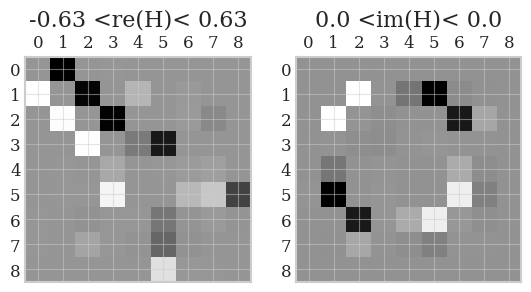

      mismatch=0.0
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    @@ error bound= 0.012408497846299769  at L=time vLR =  20.036727879799667 .
       Updating basis with deep 3 2024-12-28 10:59:47.945492
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'a

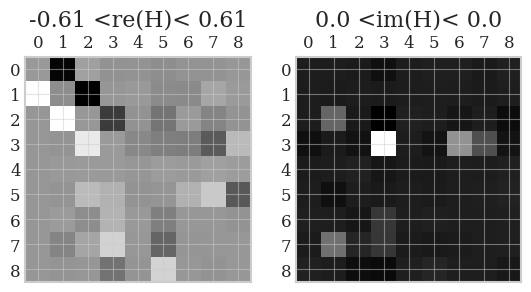

      mismatch=0.0
    @@ error bound= 0.015321107974275237  at L=time vLR =  29.053255425709516 .
       Updating basis with deep 3 2024-12-28 11:00:21.265807
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 ortho

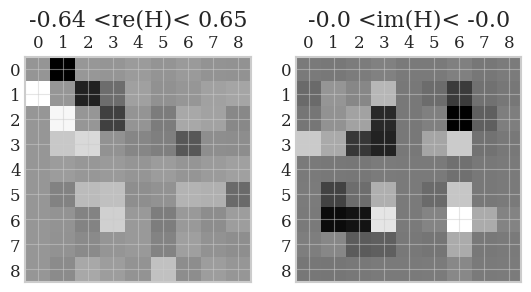

      mismatch=0.0
    @@ error bound= 0.01220697071590104  at L=time vLR =  39.071619365609344 .
       Updating basis with deep 3 2024-12-28 11:01:39.489246
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

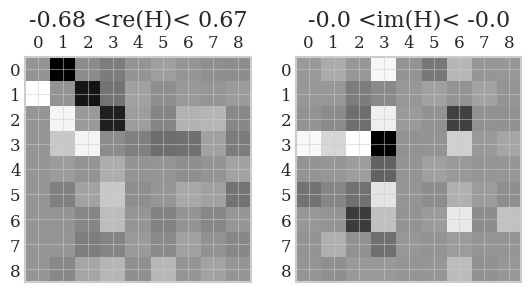

      mismatch=0.0
    @@ error bound= 0.01471949875012863  at L=time vLR =  48.088146911519196 .
       Updating basis with deep 3 2024-12-28 11:03:22.309951
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

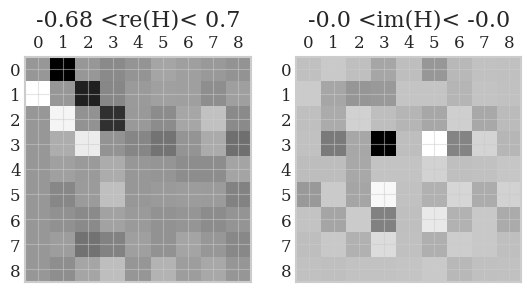

      mismatch=0.0
  t=4.660107273198177, error~1.3794751162283135e-06
    @@ error bound= 0.016276070685070847  at L=time vLR =  57.10467445742904 .
       Updating basis with deep 3 2024-12-28 11:05:23.791976
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
 

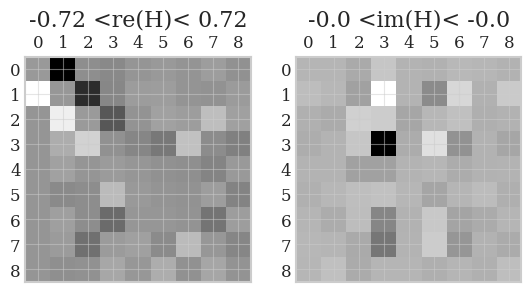

      mismatch=1.0252887437137784e-12
    @@ error bound= 0.01591479110006664  at L=time vLR =  67.12303839732888 .
       Updating basis with deep 3 2024-12-28 11:07:28.043658
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

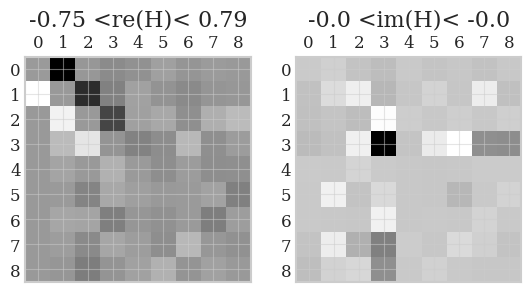

      mismatch=1.0770051036516745e-12
    @@ error bound= 0.01570277422457822  at L=time vLR =  79.14507512520868 .
       Updating basis with deep 3 2024-12-28 11:09:31.912762
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

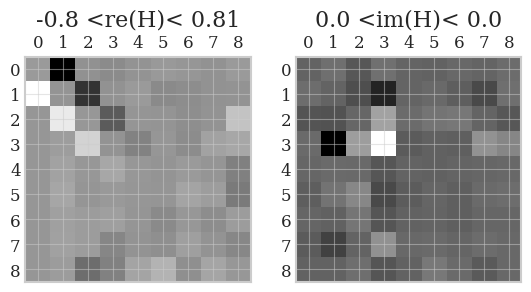

      mismatch=0.0
    @@ error bound= 0.017057499127482535  at L=time vLR =  87.15976627712855 .
       Updating basis with deep 3 2024-12-28 11:11:50.493771
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

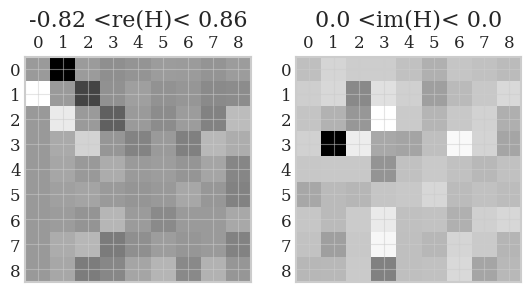

      mismatch=0.0
    @@ error bound= 0.013130512458516786  at L=time vLR =  93.17078464106844 .
       Updating basis with deep 3 2024-12-28 11:14:20.283372
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

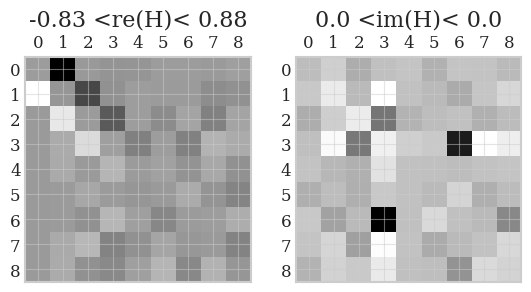

      mismatch=0.0
    @@ error bound= 0.011499837535611263  at L=time vLR =  99.18180300500835 .
       Updating basis with deep 3 2024-12-28 11:16:45.690899
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

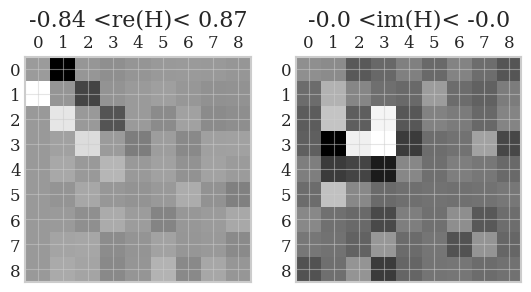

      mismatch=1.09625532704979e-12
  t=9.320214546396354, error~0.011499837535611263
    @@ error bound= 0.017235794014108033  at L=time vLR =  106.19465776293822 .
       Updating basis with deep 3 2024-12-28 11:19:17.806787
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 

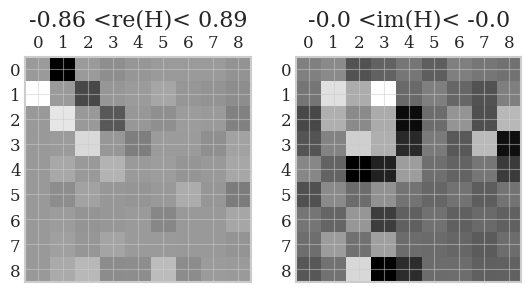

      mismatch=1.108227194778044e-12
    @@ error bound= 0.011658449698903083  at L=time vLR =  113.20751252086812 .
       Updating basis with deep 3 2024-12-28 11:21:43.645490
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

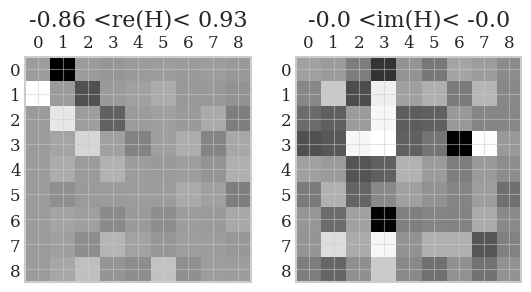

      mismatch=1.084071663139637e-12
    @@ error bound= 0.010339650748662154  at L=time vLR =  122.22404006677796 .
       Updating basis with deep 3 2024-12-28 11:24:09.417888
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

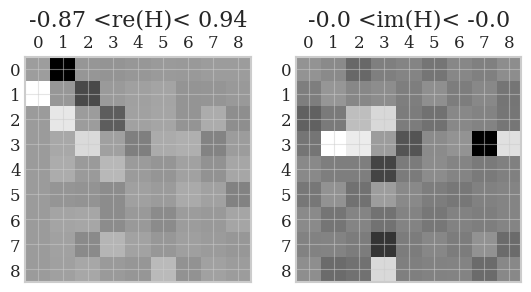

      mismatch=1.1118349703019875e-12
    @@ error bound= 0.012021800484779506  at L=time vLR =  131.2405676126878 .
       Updating basis with deep 3 2024-12-28 11:26:41.065613
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

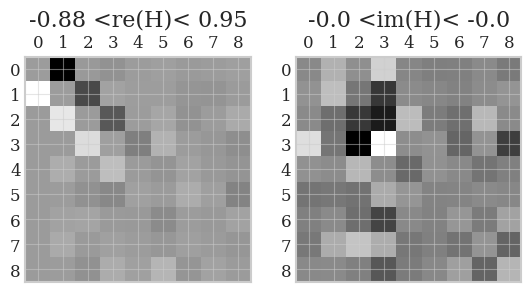

      mismatch=1.079498325974054e-12
    @@ error bound= 0.011279190556302224  at L=time vLR =  138.2534223706177 .
       Updating basis with deep 3 2024-12-28 11:29:12.761120
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

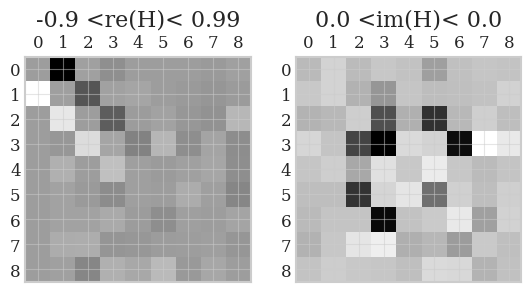

      mismatch=1.1315721803021183e-12
    @@ error bound= 0.0127355501978672  at L=time vLR =  145.26627712854756 .
       Updating basis with deep 3 2024-12-28 11:31:50.010742
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

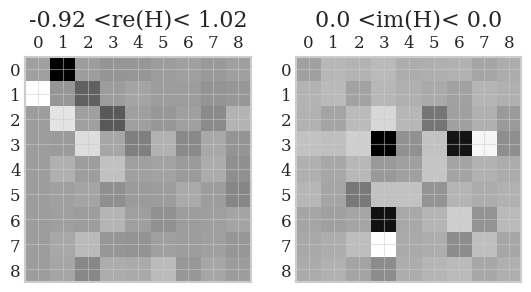

      mismatch=0.0
  t=13.980321819594531, error~0.0012810005866068339
    @@ error bound= 0.011620634214068646  at L=time vLR =  152.27913188647747 .
       Updating basis with deep 3 2024-12-28 11:34:22.179646
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators


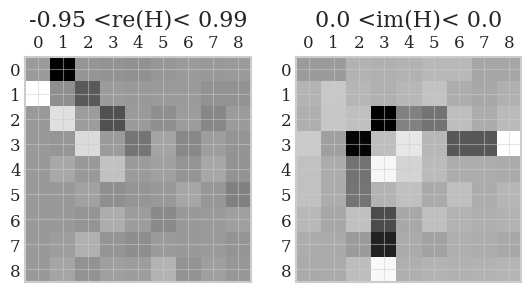

      mismatch=1.0581652671313184e-12
    @@ error bound= 0.013562177015924336  at L=time vLR =  159.29198664440733 .
       Updating basis with deep 3 2024-12-28 11:36:53.975255
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

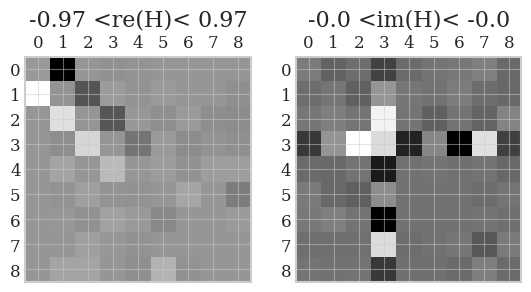

      mismatch=1.0873667095472655e-12
    @@ error bound= 0.012288284167416551  at L=time vLR =  166.30484140233722 .
       Updating basis with deep 3 2024-12-28 11:39:27.568331
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

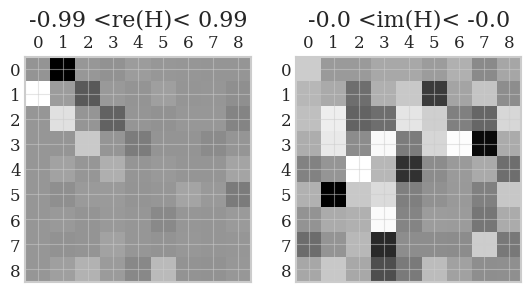

      mismatch=1.09218679943668e-12
    @@ error bound= 0.01181713737733568  at L=time vLR =  176.32320534223703 .
       Updating basis with deep 3 2024-12-28 11:41:55.302312
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now

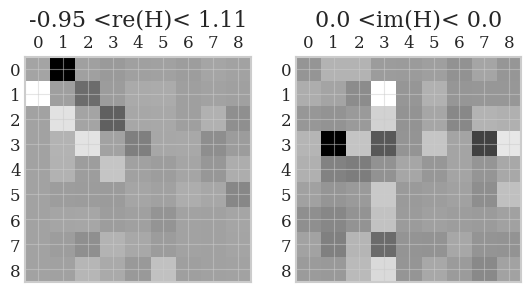

      mismatch=1.1462336100168653e-12
    @@ error bound= 0.014586733243042856  at L=time vLR =  188.34524207011685 .
       Updating basis with deep 3 2024-12-28 11:44:22.497246
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

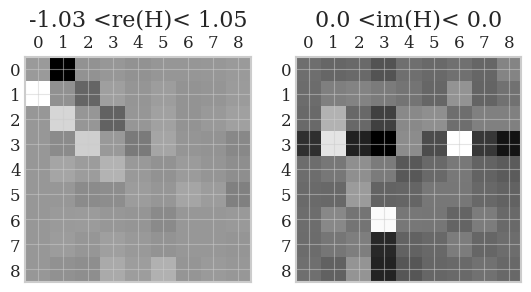

      mismatch=1.0835098598193884e-12
    @@ error bound= 0.010026444626786356  at L=time vLR =  196.35993322203672 .
       Updating basis with deep 3 2024-12-28 11:46:53.095199
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

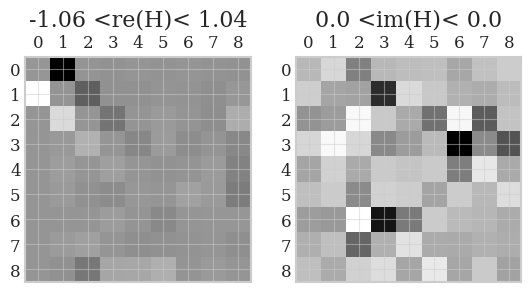

      mismatch=1.0529990517890646e-12
  t=18.640429092792708, error~0.00019241199718015393
    @@ error bound= 0.01226243623373577  at L=time vLR =  207.38013355592653 .
       Updating basis with deep 3 2024-12-28 11:49:22.951570
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators t

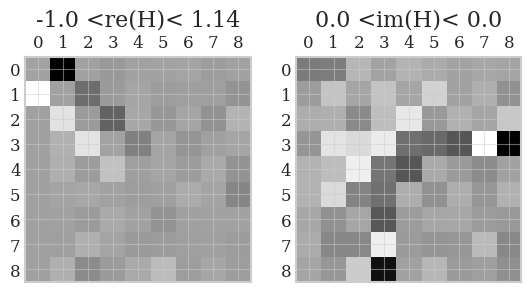

      mismatch=1.1394329450621334e-12
    @@ error bound= 0.01888348681358769  at L=time vLR =  213.39115191986645 .
       Updating basis with deep 3 2024-12-28 11:51:45.406795
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

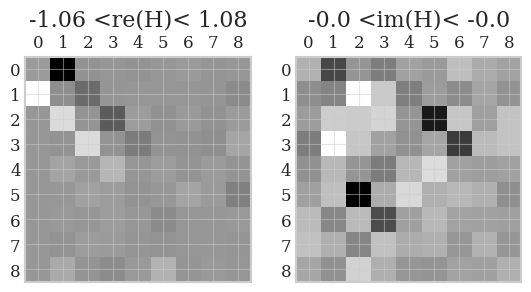

      mismatch=1.0158999602687269e-12
    @@ error bound= 0.012371822753289081  at L=time vLR =  218.40033388981635 .
       Updating basis with deep 3 2024-12-28 11:54:09.685331
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

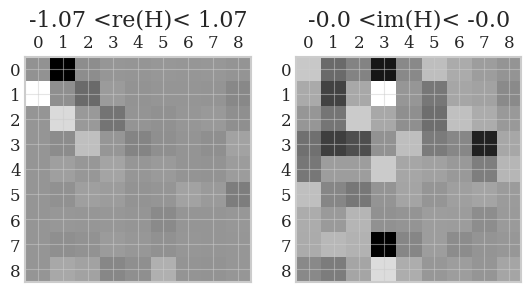

      mismatch=1.0684751000615239e-12
    @@ error bound= 0.01011430904263632  at L=time vLR =  223.4095158597663 .
       Updating basis with deep 3 2024-12-28 11:56:26.962612
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

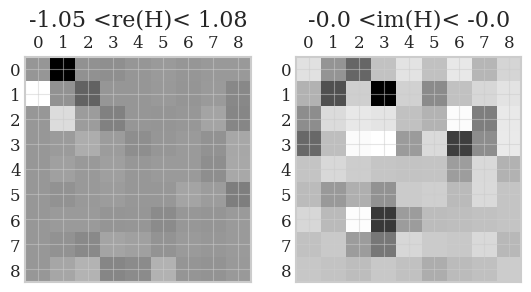

      mismatch=1.1064432187438516e-12
    @@ error bound= 0.010255545417042504  at L=time vLR =  229.42053422370617 .
       Updating basis with deep 3 2024-12-28 11:58:48.964157
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

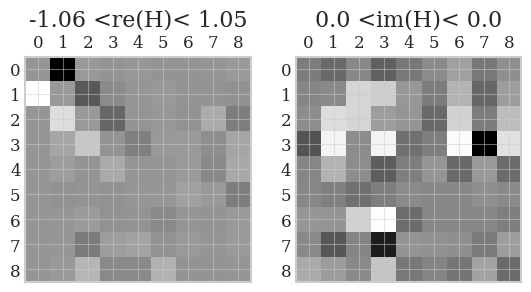

      mismatch=1.1311488200029486e-12
    @@ error bound= 0.012664603602232916  at L=time vLR =  239.438898163606 .
       Updating basis with deep 3 2024-12-28 12:01:15.200798
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

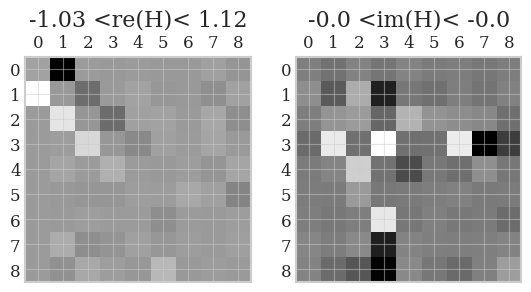

      mismatch=1.196873142645965e-12
    @@ error bound= 0.014328282761356037  at L=time vLR =  244.44808013355592 .
       Updating basis with deep 3 2024-12-28 12:03:42.048569
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

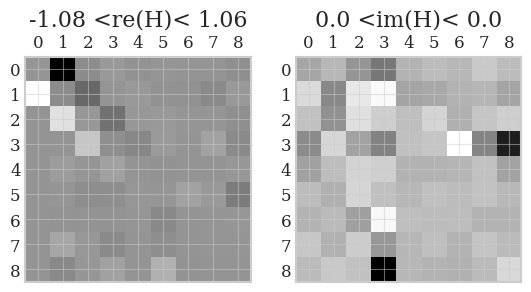

      mismatch=1.1484391148816798e-12
    @@ error bound= 0.014979194898740956  at L=time vLR =  249.45726210350585 .
       Updating basis with deep 3 2024-12-28 12:06:04.031969
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

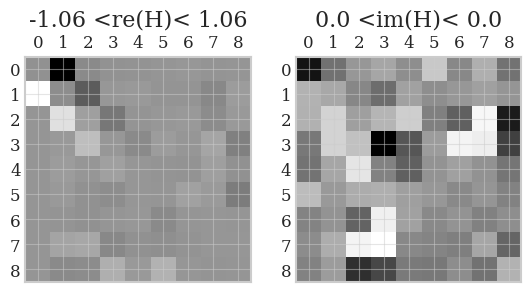

      mismatch=1.1168824221926584e-12
  t=23.300536365990883, error~0.014979194898740956
    @@ error bound= 0.01726317069955479  at L=time vLR =  255.46828046744574 .
       Updating basis with deep 3 2024-12-28 12:08:33.276262
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 

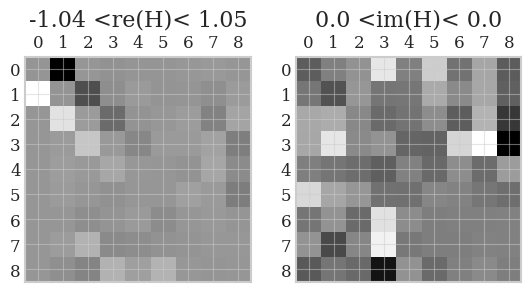

      mismatch=1.1635470838060256e-12
    @@ error bound= 0.014255676659332714  at L=time vLR =  270.4958263772955 .
       Updating basis with deep 3 2024-12-28 12:11:02.441288
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

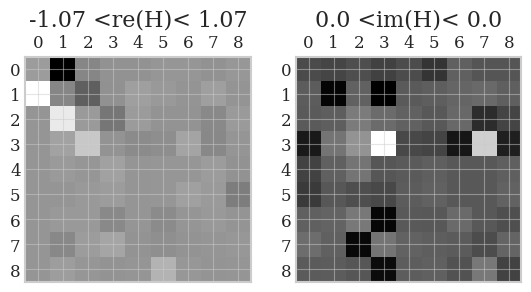

      mismatch=1.1969461015828606e-12
    @@ error bound= 0.019634535077681807  at L=time vLR =  276.5068447412354 .
       Updating basis with deep 3 2024-12-28 12:13:31.092812
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

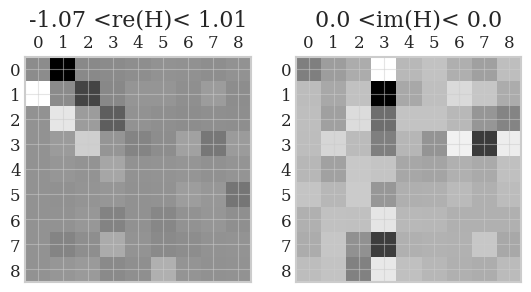

      mismatch=1.1715330607264055e-12
    @@ error bound= 0.0109108228859153  at L=time vLR =  282.5178631051753 .
       Updating basis with deep 3 2024-12-28 12:16:03.485120
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now

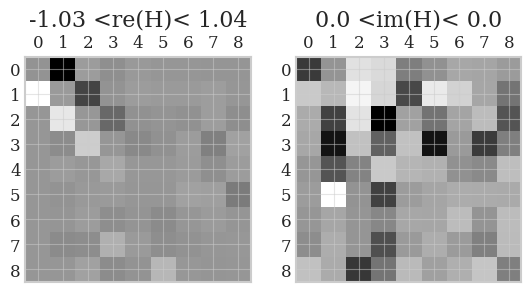

      mismatch=1.1615846423776464e-12
    @@ error bound= 0.013507617362432556  at L=time vLR =  290.5325542570951 .
       Updating basis with deep 3 2024-12-28 12:18:31.875318
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

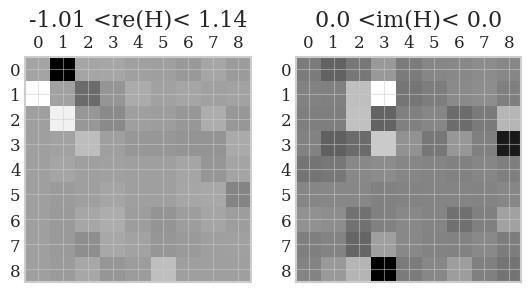

      mismatch=1.1842370429426759e-12
  t=27.960643639189062, error~0.006356661419774347
    @@ error bound= 0.014278216134850056  at L=time vLR =  301.552754590985 .
       Updating basis with deep 3 2024-12-28 12:21:05.047726
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2

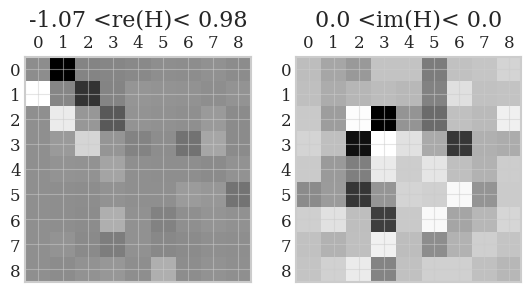

      mismatch=1.2208864094145626e-12
    @@ error bound= 0.010789145286343846  at L=time vLR =  310.5692821368948 .
       Updating basis with deep 3 2024-12-28 12:23:35.435334
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

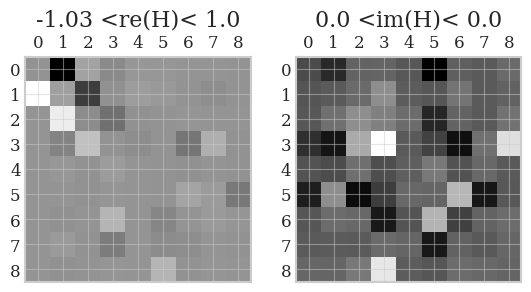

      mismatch=1.231276000879396e-12
    @@ error bound= 0.01393479699430053  at L=time vLR =  320.58764607679467 .
       Updating basis with deep 3 2024-12-28 12:26:06.151104
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

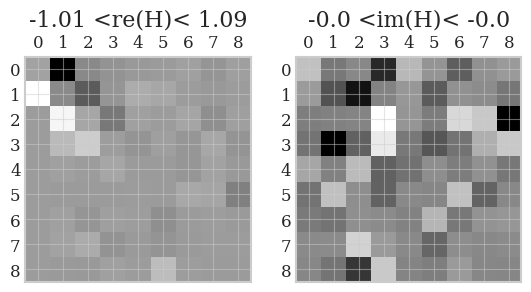

      mismatch=1.289131258645901e-12
    @@ error bound= 0.01802069991627846  at L=time vLR =  341.6262103505843 .
       Updating basis with deep 3 2024-12-28 12:28:39.913470
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now

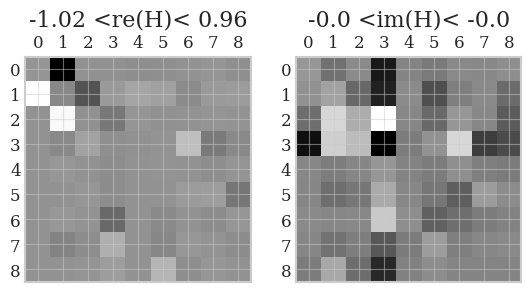

      mismatch=1.528702373085021e-12
    @@ error bound= 0.01699924025220744  at L=time vLR =  348.6390651085142 .
       Updating basis with deep 3 2024-12-28 12:31:18.097241
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now

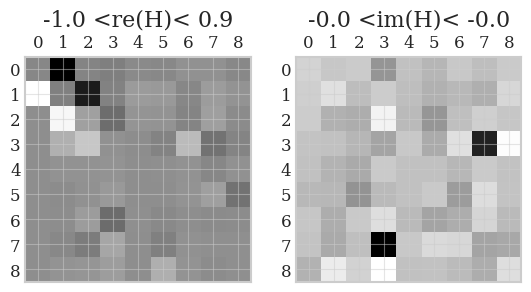

      mismatch=1.5937961798756192e-12
  t=32.62075091238724, error~2.1854354407003528e-06
    @@ error bound= 0.016279857449035474  at L=time vLR =  366.67212020033384 .
       Updating basis with deep 3 2024-12-28 12:33:49.924360
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators t

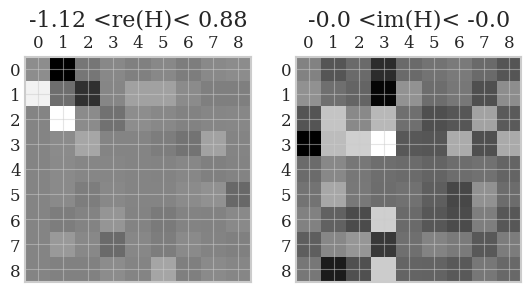

      mismatch=1.7673593829151539e-12
    @@ error bound= 0.018209274785085126  at L=time vLR =  372.68313856427375 .
       Updating basis with deep 3 2024-12-28 12:36:19.048199
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

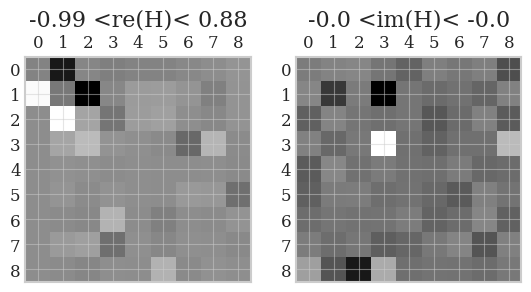

      mismatch=1.8381684847737116e-12
    @@ error bound= 0.011788111821048549  at L=time vLR =  381.69966611018367 .
       Updating basis with deep 3 2024-12-28 12:38:50.547678
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> 

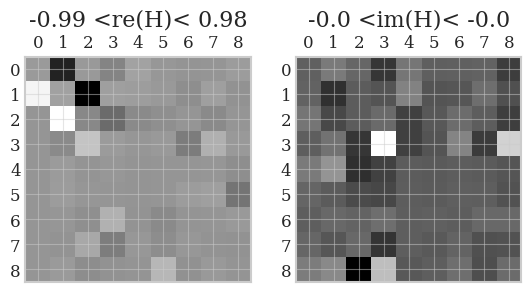

      mismatch=1.928778450314299e-12
    @@ error bound= 0.016579272812288125  at L=time vLR =  390.7161936560935 .
       Updating basis with deep 3 2024-12-28 12:41:25.768117
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

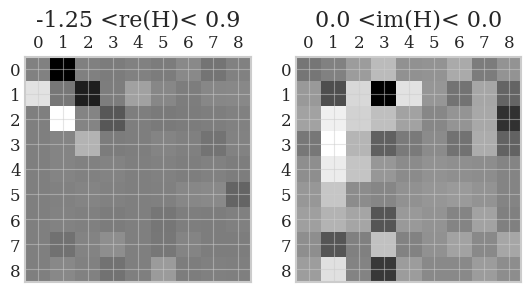

      mismatch=2.2721493726775856e-12
    @@ error bound= 0.013227484617805867  at L=time vLR =  396.7272120200334 .
       Updating basis with deep 3 2024-12-28 12:44:00.469067
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

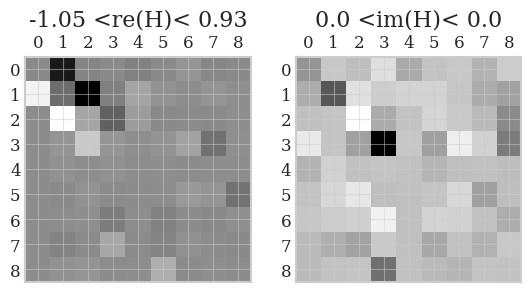

      mismatch=2.236379058555839e-12
  t=37.280858185585416, error~0.0002481290160064011
    @@ error bound= 0.013660040271982416  at L=time vLR =  405.7437395659432 .
       Updating basis with deep 3 2024-12-28 12:46:37.248727
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 

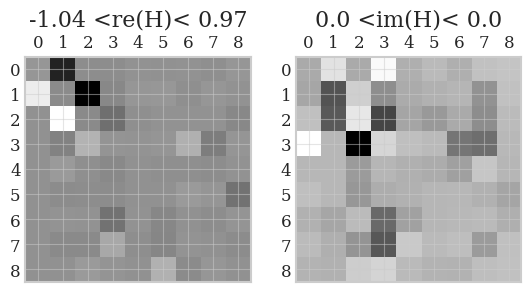

      mismatch=2.0945762447243515e-12
    @@ error bound= 0.011958048580700296  at L=time vLR =  420.771285475793 .
       Updating basis with deep 3 2024-12-28 12:49:13.323468
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

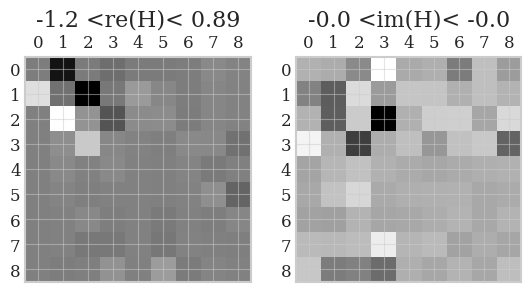

      mismatch=2.550532705740627e-12
    @@ error bound= 0.01255710977100081  at L=time vLR =  433.79515859766275 .
       Updating basis with deep 3 2024-12-28 12:51:52.715689
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

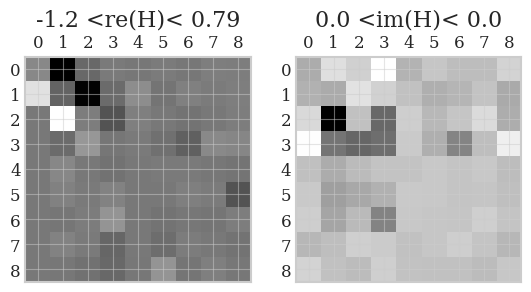

      mismatch=2.707084778549243e-12
    @@ error bound= 0.012621653037387331  at L=time vLR =  442.8116861435726 .
       Updating basis with deep 3 2024-12-28 12:54:29.544418
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

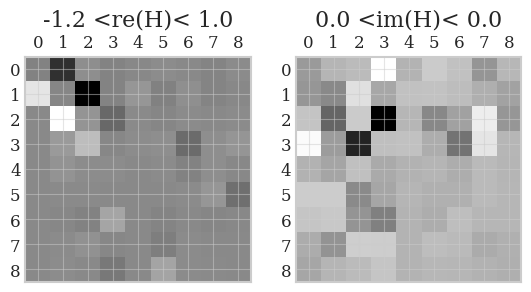

      mismatch=2.456252332106308e-12
  t=41.94096545878359, error~0.000835320399563431
    @@ error bound= 0.011206698984546288  at L=time vLR =  456.83739565943233 .
       Updating basis with deep 3 2024-12-28 12:57:03.361475
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2

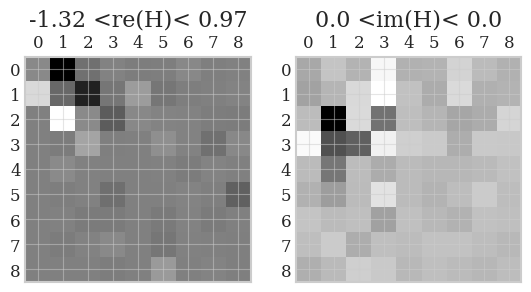

      mismatch=2.943943519251552e-12
    @@ error bound= 0.011671430357847422  at L=time vLR =  468.85943238731215 .
       Updating basis with deep 3 2024-12-28 12:59:39.874446
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

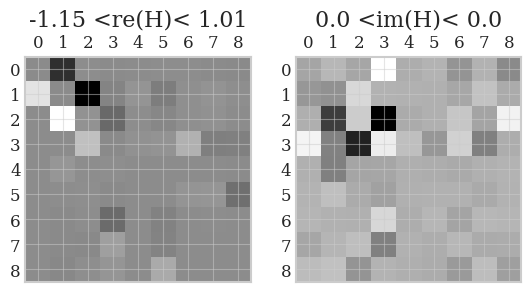

      mismatch=3.224454804079226e-12
    @@ error bound= 0.011415660534469192  at L=time vLR =  481.8833055091819 .
       Updating basis with deep 3 2024-12-28 13:02:15.731789
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

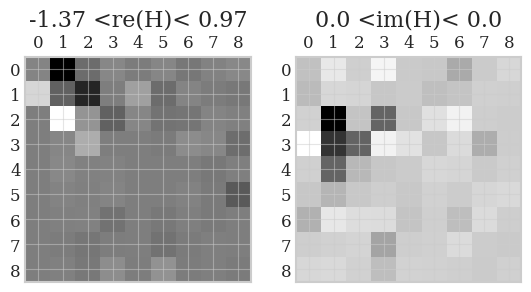

      mismatch=3.006596644564014e-12
    @@ error bound= 0.015293192243936896  at L=time vLR =  492.9035058430718 .
       Updating basis with deep 3 2024-12-28 13:04:52.381010
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

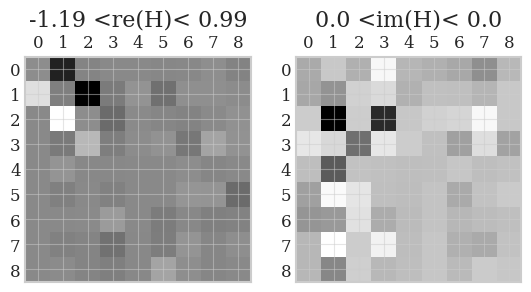

      mismatch=3.180540343196161e-12
  t=46.601072731981766, error~0.004865942478685107
    @@ error bound= 0.013200617922410776  at L=time vLR =  501.9200333889816 .
       Updating basis with deep 3 2024-12-28 13:07:24.825181
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2

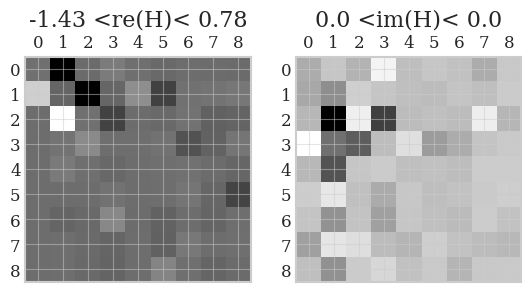

      mismatch=0.0
    @@ error bound= 0.01313872738668463  at L=time vLR =  514.9439065108514 .
       Updating basis with deep 3 2024-12-28 13:10:03.834435
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthogo

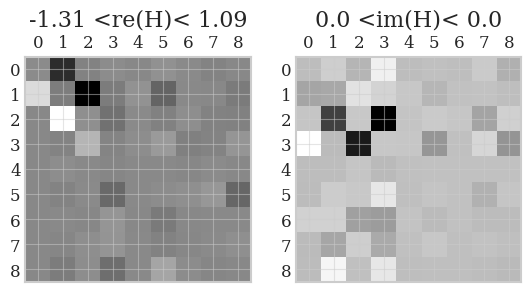

      mismatch=4.3243779802965754e-12
    @@ error bound= 0.01826460160149599  at L=time vLR =  521.9567612687813 .
       Updating basis with deep 3 2024-12-28 13:12:39.840479
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

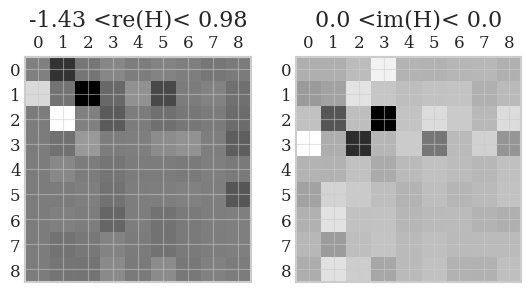

      mismatch=4.138602562212442e-12
    @@ error bound= 0.013308827051648044  at L=time vLR =  530.9732888146912 .
       Updating basis with deep 3 2024-12-28 13:15:18.859610
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

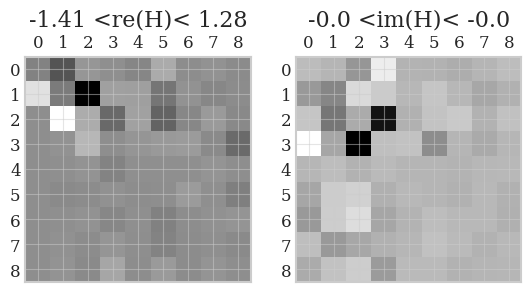

      mismatch=4.883929078433282e-12
    @@ error bound= 0.01534994485275073  at L=time vLR =  539.989816360601 .
       Updating basis with deep 3 2024-12-28 13:17:56.266821
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now 

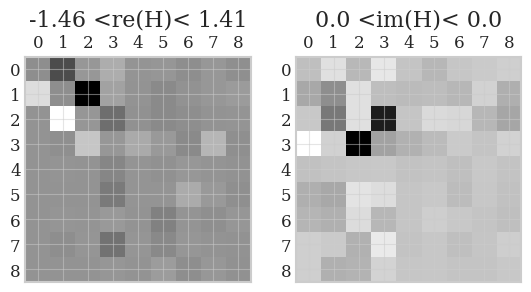

      mismatch=1.170066263048401e-12
    @@ error bound= 0.015220096929798914  at L=time vLR =  549.0063439065109 .
       Updating basis with deep 3 2024-12-28 13:20:31.723921
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> no

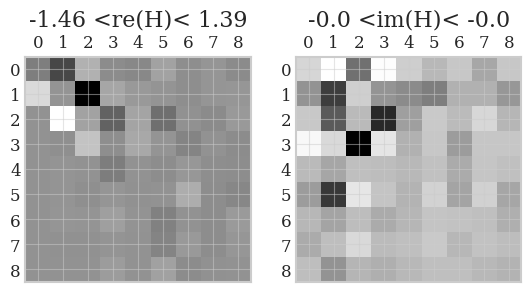

      mismatch=0.0
  t=51.261180005179945, error~7.395625663078395e-08
    @@ error bound= 0.010252886799114486  at L=time vLR =  568.0412353923205 .
       Updating basis with deep 3 2024-12-28 13:23:13.047693
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
 

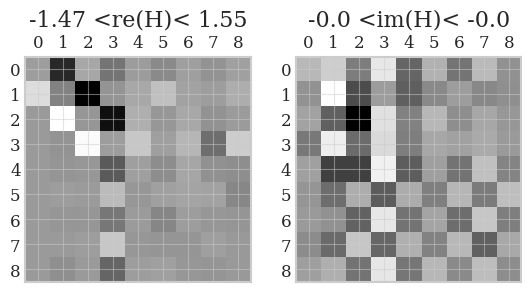

      mismatch=0.0
    @@ error bound= 0.016903722850594605  at L=time vLR =  574.0522537562604 .
       Updating basis with deep 3 2024-12-28 13:25:52.215678
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

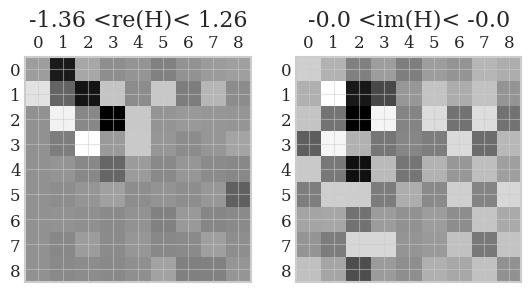

      mismatch=1.5206301122015298e-12
    @@ error bound= 0.014078917160270148  at L=time vLR =  580.0632721202003 .
       Updating basis with deep 3 2024-12-28 13:28:32.635271
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> n

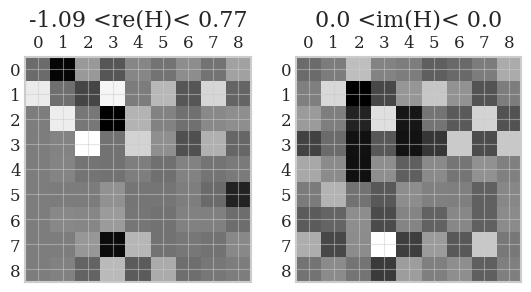

      mismatch=0.0
    @@ error bound= 0.02147634821117829  at L=time vLR =  588.0779632721202 .
       Updating basis with deep 3 2024-12-28 13:31:18.579631
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthogo

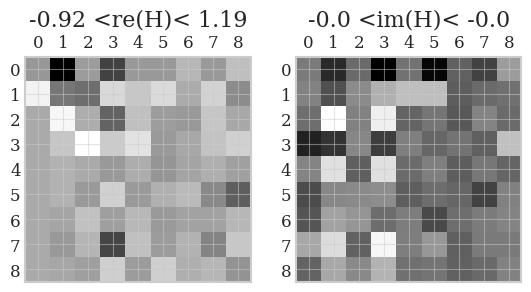

      mismatch=0.0
    @@ error bound= 0.017580729989041387  at L=time vLR =  595.0908180300501 .
       Updating basis with deep 3 2024-12-28 13:33:59.983373
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthog

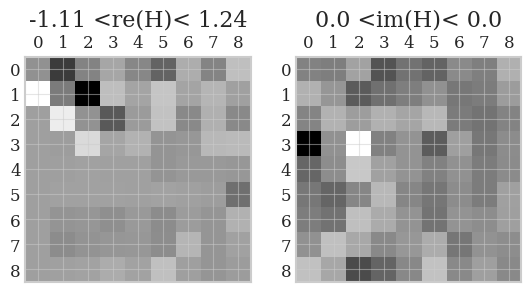

      mismatch=0.0
    @@ error bound= 0.01136743236556575  at L=time vLR =  600.1 .
       Updating basis with deep 3 2024-12-28 13:36:38.978329
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 2 body operators
      * orthogonalize
        -> now we have 9 orthogonal operator

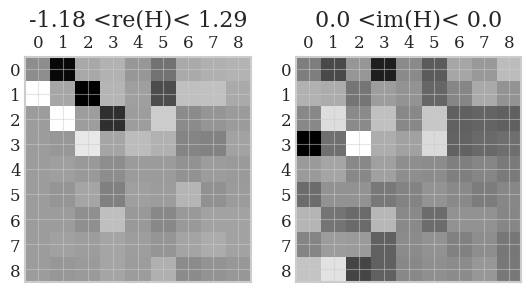

      mismatch=0.0


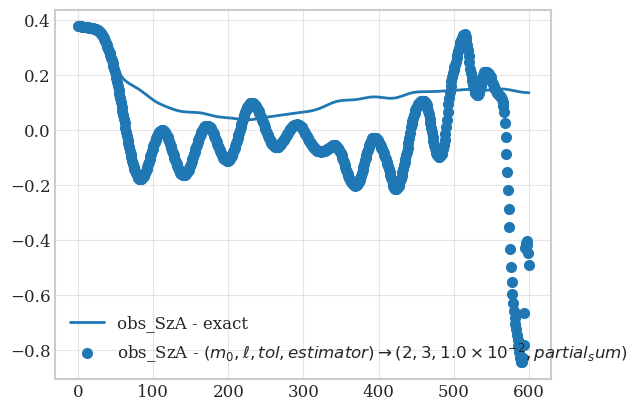

Simulation (2,7,0.01,partial_sum)
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthogonal operators
      * build Hij
      * hij_tensor:



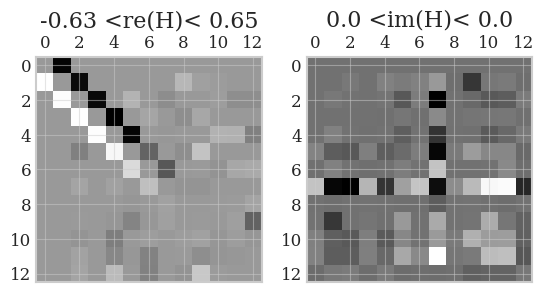

      mismatch=0.0
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    @@ error bound= 0.01362751908230347  at L=time vLR =  18.033055091819698 .
       Updating basis with deep 7 2024-12-28 13:39:45.789715
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'al

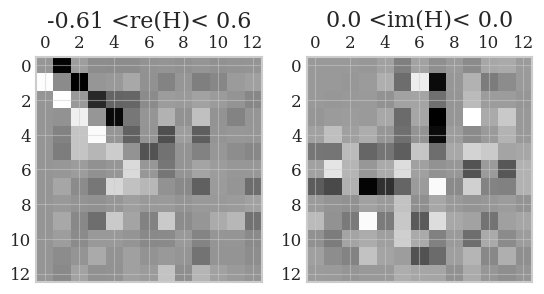

      mismatch=0.0
    @@ error bound= 0.01089496275028151  at L=time vLR =  27.04958263772955 .
       Updating basis with deep 7 2024-12-28 13:44:08.986444
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

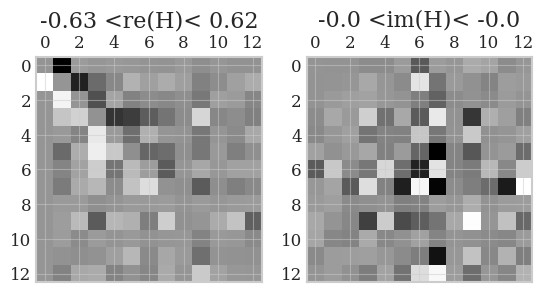

      mismatch=0.0
    @@ error bound= 0.014221614424839206  at L=time vLR =  35.06427378964941 .
       Updating basis with deep 7 2024-12-28 13:49:25.095404
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

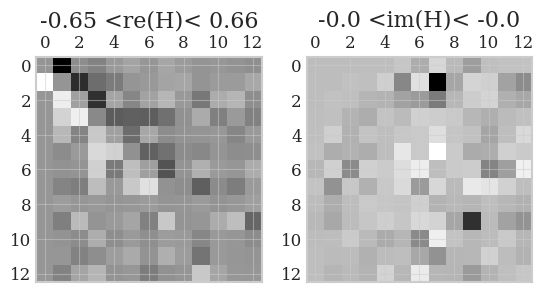

      mismatch=1.006610916491032e-12
    @@ error bound= 0.016044938757569644  at L=time vLR =  43.07896494156928 .
       Updating basis with deep 7 2024-12-28 13:55:14.921686
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

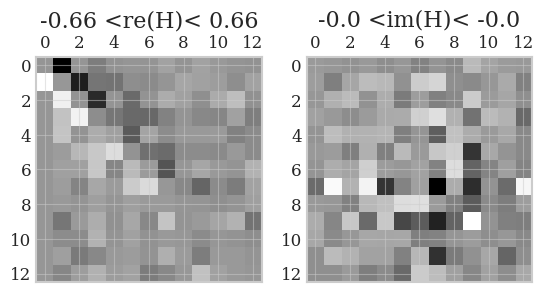

      mismatch=1.0413604714325534e-12
  t=4.660107273198177, error~0.004202607881970913
    @@ error bound= 0.013287431430168818  at L=time vLR =  51.093656093489145 .
       Updating basis with deep 7 2024-12-28 14:00:54.366576
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to

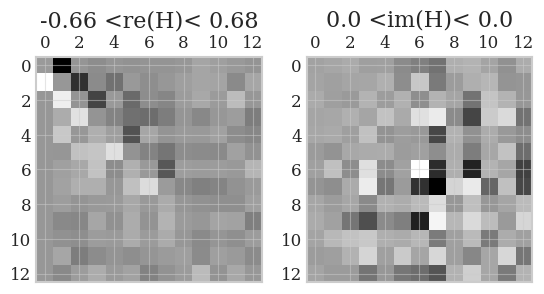

      mismatch=1.052644876716284e-12
    @@ error bound= 0.016588956860436446  at L=time vLR =  59.108347245409014 .
       Updating basis with deep 7 2024-12-28 14:06:34.261253
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

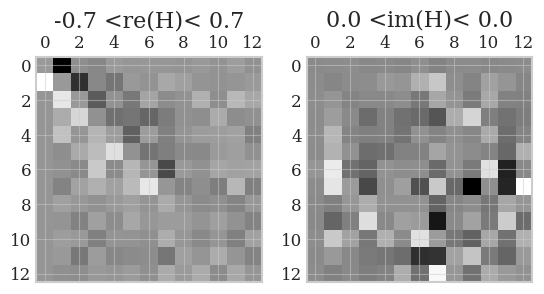

      mismatch=0.0
    @@ error bound= 0.01222362385266064  at L=time vLR =  71.13038397328882 .
       Updating basis with deep 7 2024-12-28 14:12:25.141630
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

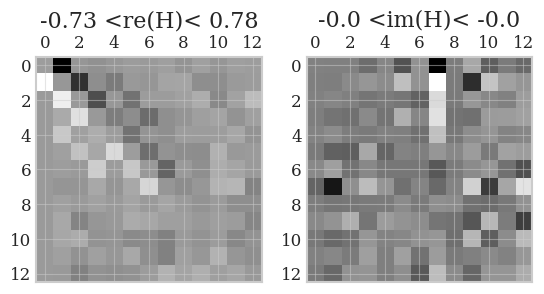

      mismatch=1.0803446621967142e-12
    @@ error bound= 0.013739634336933823  at L=time vLR =  83.15242070116861 .
       Updating basis with deep 7 2024-12-28 14:18:16.896473
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

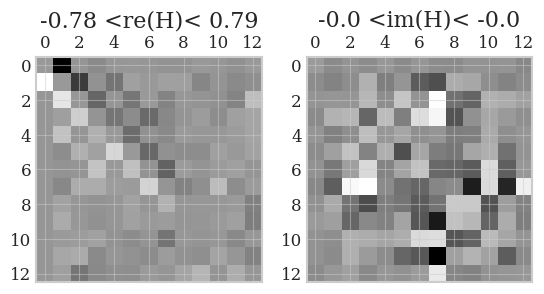

      mismatch=1.0791603652211948e-12
    @@ error bound= 0.01239659484169862  at L=time vLR =  90.16527545909851 .
       Updating basis with deep 7 2024-12-28 14:24:17.739649
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

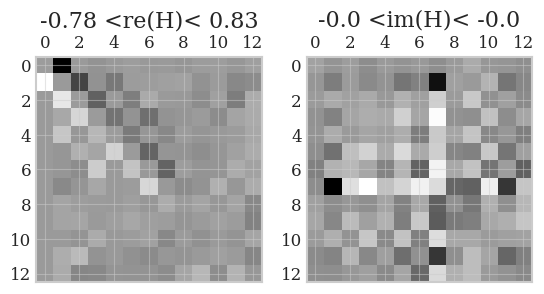

      mismatch=1.0556695454332829e-12
    @@ error bound= 0.011709643065519512  at L=time vLR =  96.17629382303839 .
       Updating basis with deep 7 2024-12-28 14:30:23.786097
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

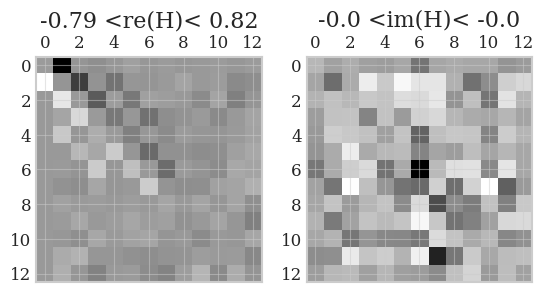

      mismatch=1.0866631791321072e-12
  t=9.320214546396354, error~0.0010109822955426692
    @@ error bound= 0.015042717565290234  at L=time vLR =  102.18731218697829 .
       Updating basis with deep 7 2024-12-28 14:36:21.447663
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators t

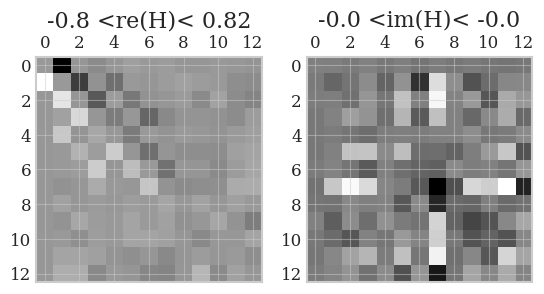

      mismatch=1.0417626882858395e-12
    @@ error bound= 0.01048351624511361  at L=time vLR =  108.1983305509182 .
       Updating basis with deep 7 2024-12-28 14:42:42.014502
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

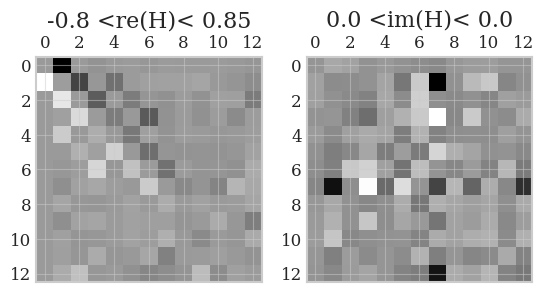

      mismatch=1.0234605658507646e-12
    @@ error bound= 0.011195804334741849  at L=time vLR =  116.21302170283806 .
       Updating basis with deep 7 2024-12-28 14:48:48.529179
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

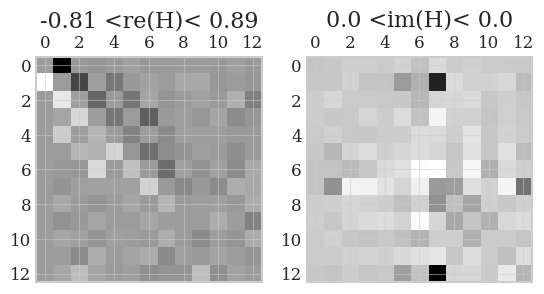

      mismatch=1.1069682244001837e-12
    @@ error bound= 0.010790415663951171  at L=time vLR =  127.23322203672787 .
       Updating basis with deep 7 2024-12-28 14:55:02.096051
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

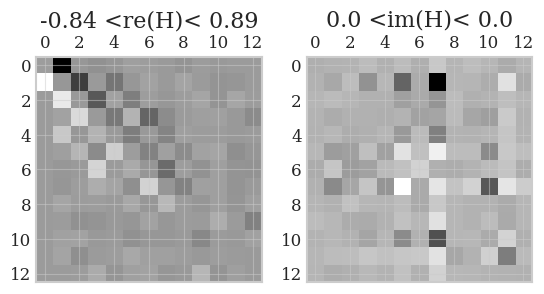

      mismatch=0.0
    @@ error bound= 0.015038328374034  at L=time vLR =  136.24974958263772 .
       Updating basis with deep 7 2024-12-28 15:01:10.241986
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

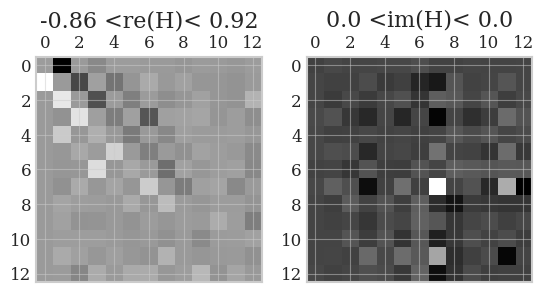

      mismatch=1.09396333614788e-12
    @@ error bound= 0.011896549742484315  at L=time vLR =  143.2626043405676 .
       Updating basis with deep 7 2024-12-28 15:07:11.071077
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

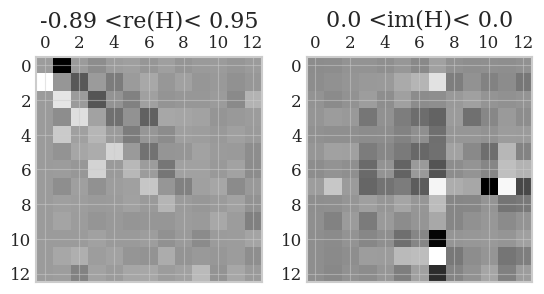

      mismatch=1.0835940283033473e-12
  t=13.980321819594531, error~0.004383574292537336
    @@ error bound= 0.012939482823025924  at L=time vLR =  151.27729549248747 .
       Updating basis with deep 7 2024-12-28 15:13:12.372787
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators t

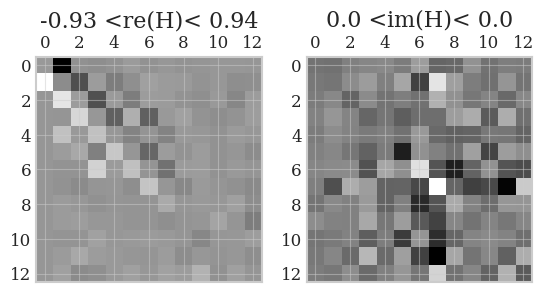

      mismatch=1.1021044053834001e-12
    @@ error bound= 0.014193717737920851  at L=time vLR =  159.29198664440733 .
       Updating basis with deep 7 2024-12-28 15:19:13.436917
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

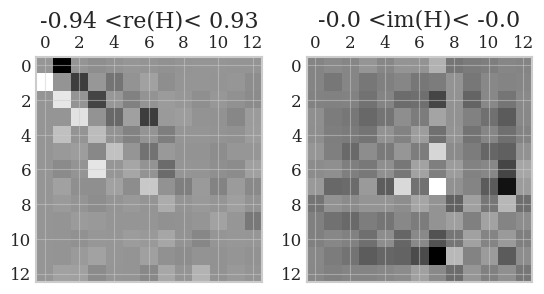

      mismatch=1.0544660693549398e-12
    @@ error bound= 0.012794389042229655  at L=time vLR =  167.3066777963272 .
       Updating basis with deep 7 2024-12-28 15:25:07.090491
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

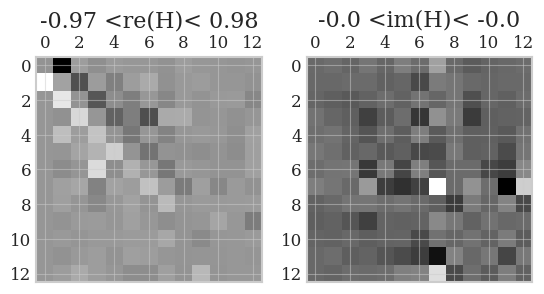

      mismatch=1.0410955105539565e-12
    @@ error bound= 0.011112649260537642  at L=time vLR =  179.328714524207 .
       Updating basis with deep 7 2024-12-28 15:31:10.304952
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

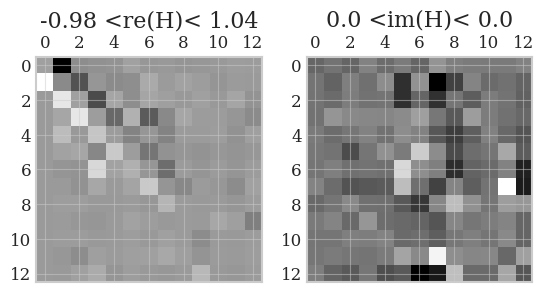

      mismatch=1.1409286194798074e-12
    @@ error bound= 0.011073183240941155  at L=time vLR =  194.35626043405676 .
       Updating basis with deep 7 2024-12-28 15:37:06.104013
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

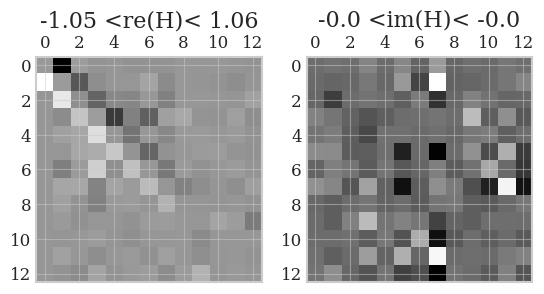

      mismatch=0.0
  t=18.640429092792708, error~0.003644112791807445
    @@ error bound= 0.012289899905705556  at L=time vLR =  201.36911519198662 .
       Updating basis with deep 7 2024-12-28 15:43:12.274042
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators


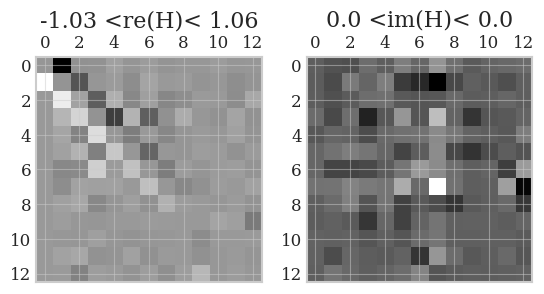

      mismatch=0.0
    @@ error bound= 0.013300750721393001  at L=time vLR =  209.38380634390649 .
       Updating basis with deep 7 2024-12-28 15:49:16.977794
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ort

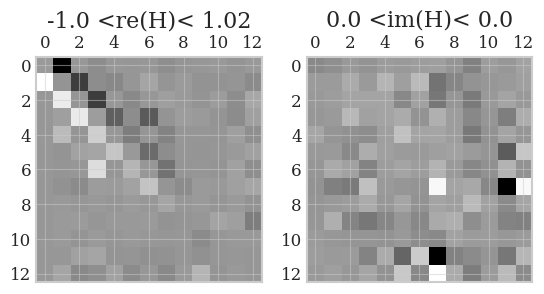

      mismatch=0.0
    @@ error bound= 0.010979618097228805  at L=time vLR =  215.3948247078464 .
       Updating basis with deep 7 2024-12-28 15:55:15.959778
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

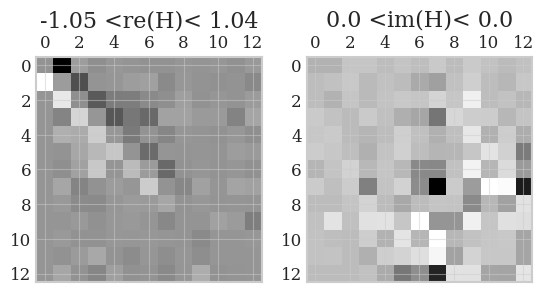

      mismatch=1.0085474358911035e-12
    @@ error bound= 0.01611224500594443  at L=time vLR =  221.4058430717863 .
       Updating basis with deep 7 2024-12-28 16:01:14.351844
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

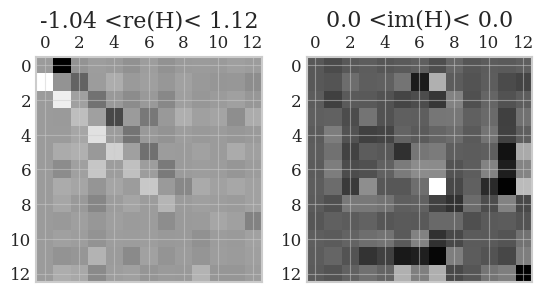

      mismatch=0.0
    @@ error bound= 0.018941873368716382  at L=time vLR =  227.4168614357262 .
       Updating basis with deep 7 2024-12-28 16:07:17.039690
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

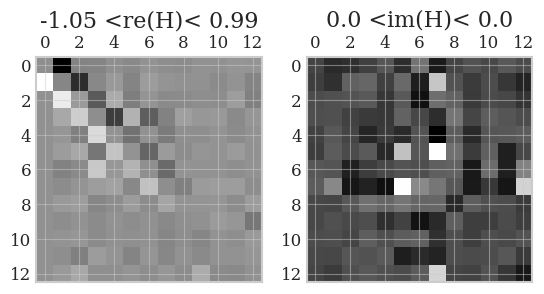

      mismatch=1.1236592754308287e-12
    @@ error bound= 0.013493112034351926  at L=time vLR =  241.44257095158596 .
       Updating basis with deep 7 2024-12-28 16:13:18.311654
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

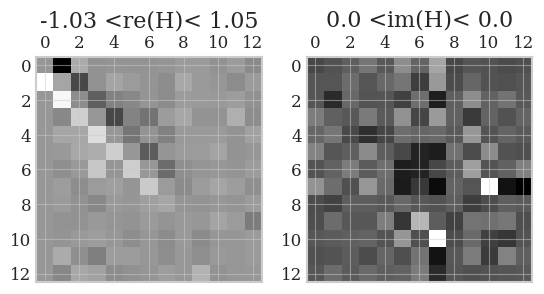

      mismatch=1.3749370890370944e-12
    @@ error bound= 0.020194381260937106  at L=time vLR =  246.4517529215359 .
       Updating basis with deep 7 2024-12-28 16:19:22.771950
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

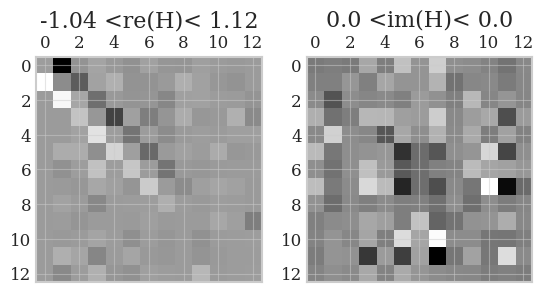

      mismatch=1.2860276542599206e-12
  t=23.300536365990883, error~0.002901441646348919
    @@ error bound= 0.021044572853906984  at L=time vLR =  251.46093489148578 .
       Updating basis with deep 7 2024-12-28 16:25:27.180640
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators t

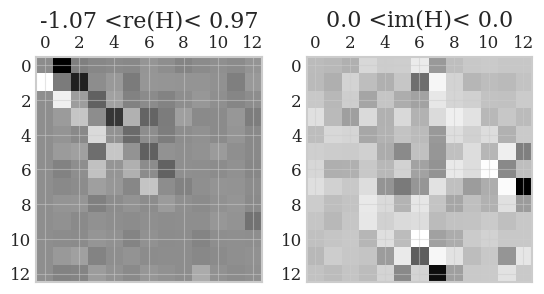

      mismatch=1.319418942225713e-12
    @@ error bound= 0.011172130984397899  at L=time vLR =  257.4719532554257 .
       Updating basis with deep 7 2024-12-28 16:31:38.278844
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

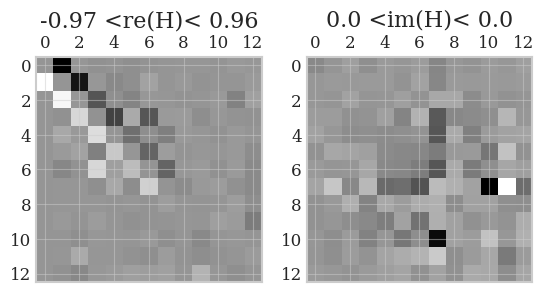

      mismatch=1.3419104345872486e-12
    @@ error bound= 0.010405369565935768  at L=time vLR =  268.49215358931554 .
       Updating basis with deep 7 2024-12-28 16:37:42.447748
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

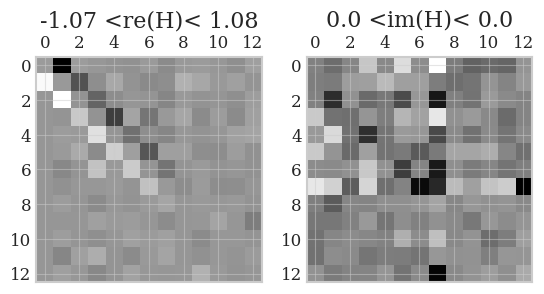

      mismatch=1.4654170207672778e-12
    @@ error bound= 0.012842597250881835  at L=time vLR =  273.50133555926544 .
       Updating basis with deep 7 2024-12-28 16:43:52.282698
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

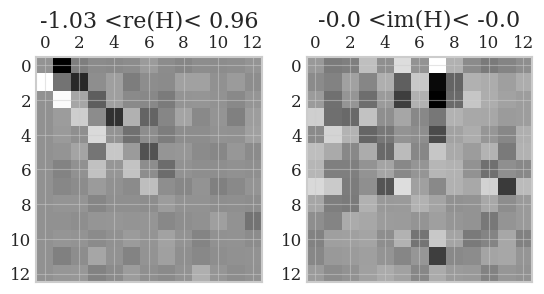

      mismatch=1.365439520795976e-12
    @@ error bound= 0.01632156001320569  at L=time vLR =  279.51235392320535 .
       Updating basis with deep 7 2024-12-28 16:49:57.823881
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

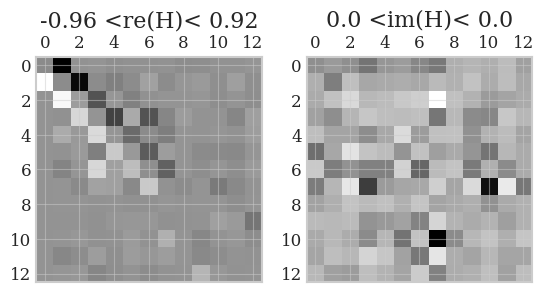

      mismatch=1.5201626546980965e-12
    @@ error bound= 0.013014493403526476  at L=time vLR =  287.5270450751252 .
       Updating basis with deep 7 2024-12-28 16:55:57.397049
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

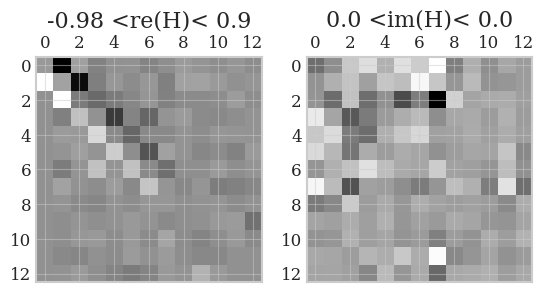

      mismatch=1.5579584566626188e-12
    @@ error bound= 0.01022434982958329  at L=time vLR =  299.549081803005 .
       Updating basis with deep 7 2024-12-28 17:02:03.974404
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

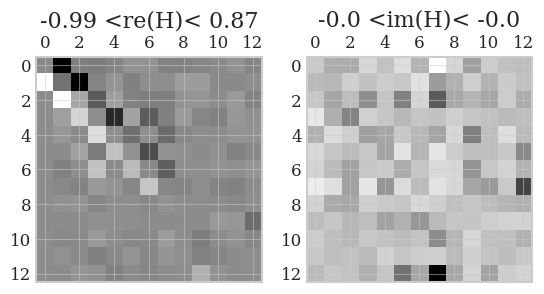

      mismatch=0.0
  t=27.960643639189062, error~0.01022434982958329
    @@ error bound= 0.012477507239939463  at L=time vLR =  310.5692821368948 .
       Updating basis with deep 7 2024-12-28 17:08:10.205251
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
  

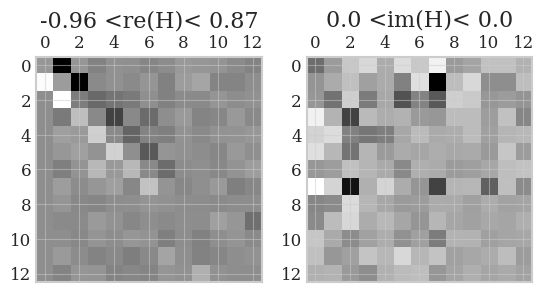

      mismatch=1.094348322081938e-12
    @@ error bound= 0.010406686252473788  at L=time vLR =  316.5803005008347 .
       Updating basis with deep 7 2024-12-28 17:14:17.009895
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

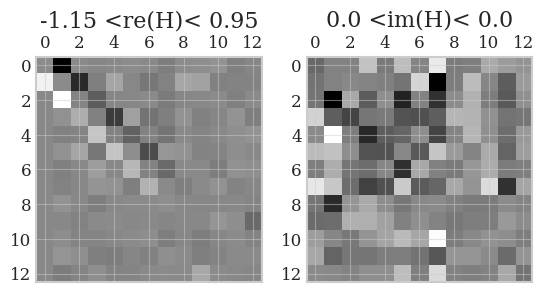

      mismatch=1.1350322544965392e-12
    @@ error bound= 0.01297916898696226  at L=time vLR =  322.5913188647746 .
       Updating basis with deep 7 2024-12-28 17:20:20.744081
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

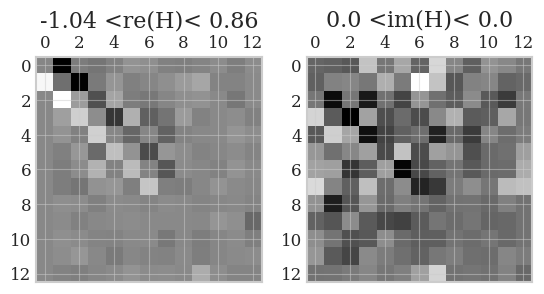

      mismatch=1.6697010494815052e-12
    @@ error bound= 0.010305485561082354  at L=time vLR =  340.6243739565943 .
       Updating basis with deep 7 2024-12-28 17:26:26.053395
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

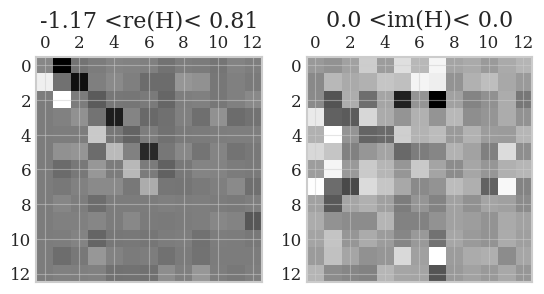

      mismatch=1.4060213875662355e-12
    @@ error bound= 0.010975354034596733  at L=time vLR =  346.6353923205342 .
       Updating basis with deep 7 2024-12-28 17:32:33.060925
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

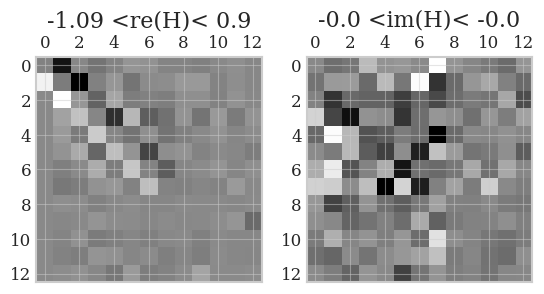

      mismatch=1.5615093813455433e-12
  t=32.62075091238724, error~0.00010023655102794924
    @@ error bound= 0.01097129348090846  at L=time vLR =  368.67579298831384 .
       Updating basis with deep 7 2024-12-28 17:38:47.434798
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators t

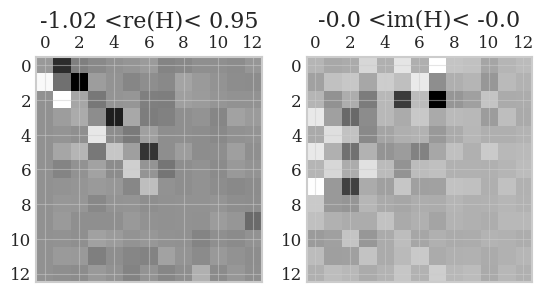

      mismatch=0.0
    @@ error bound= 0.010613102143669092  at L=time vLR =  377.69232053422365 .
       Updating basis with deep 7 2024-12-28 17:45:32.611689
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ort

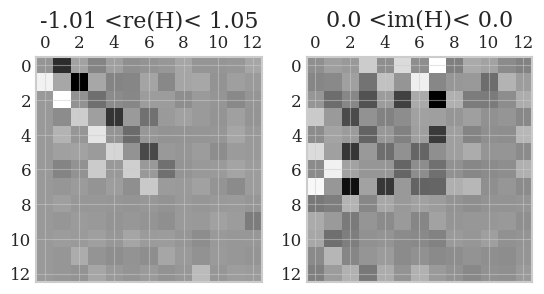

      mismatch=2.527021799013831e-12
    @@ error bound= 0.014825178313994877  at L=time vLR =  387.7106844741235 .
       Updating basis with deep 7 2024-12-28 17:53:21.750372
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

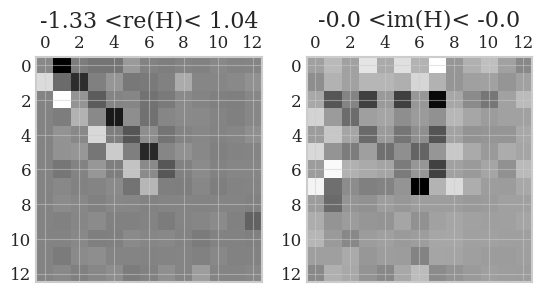

      mismatch=1.951396544335621e-12
    @@ error bound= 0.014506060632175724  at L=time vLR =  394.72353923205344 .
       Updating basis with deep 7 2024-12-28 18:00:06.747975
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

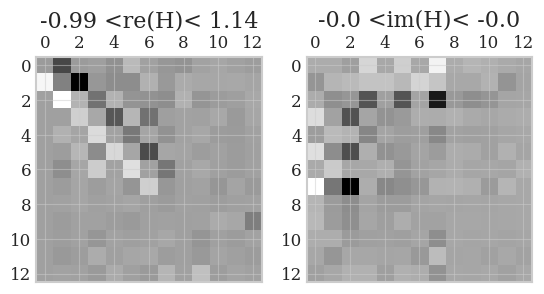

      mismatch=2.8615292073069e-12
  t=37.280858185585416, error~0.0009014256894990888
    @@ error bound= 0.010808378655924333  at L=time vLR =  405.7437395659432 .
       Updating basis with deep 7 2024-12-28 18:06:36.622903
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2

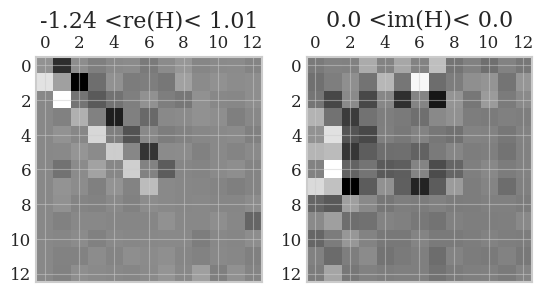

      mismatch=2.1145289471179457e-12
    @@ error bound= 0.015038166132925633  at L=time vLR =  414.76026711185307 .
       Updating basis with deep 7 2024-12-28 18:12:58.029092
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

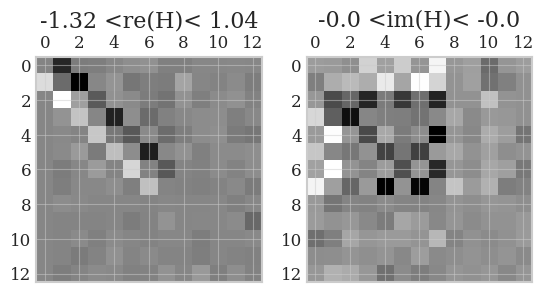

      mismatch=0.0
    @@ error bound= 0.014767575534644393  at L=time vLR =  423.7767946577629 .
       Updating basis with deep 7 2024-12-28 18:19:17.543717
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

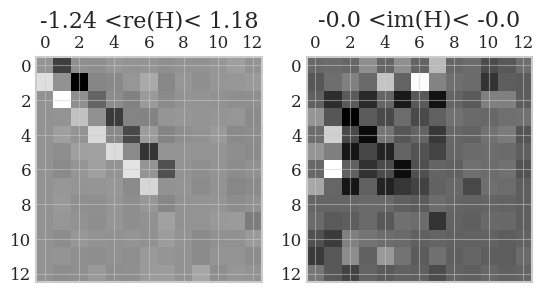

      mismatch=2.807375536483507e-12
    @@ error bound= 0.010111117980404316  at L=time vLR =  435.7988313856427 .
       Updating basis with deep 7 2024-12-28 18:25:34.647812
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

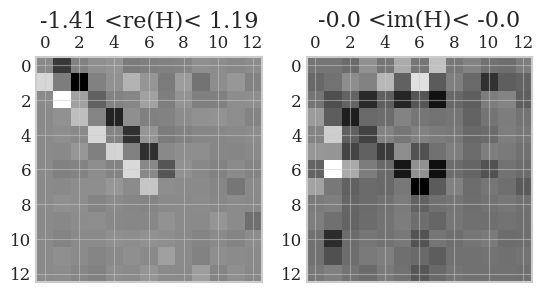

      mismatch=1.1092616904111556e-12
    @@ error bound= 0.013795346139305515  at L=time vLR =  445.81719532554257 .
       Updating basis with deep 7 2024-12-28 18:31:55.343642
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        ->

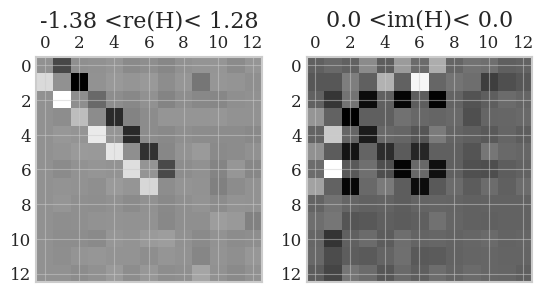

      mismatch=0.0
  t=41.94096545878359, error~0.0001295259752120441
    @@ error bound= 0.011174482154936358  at L=time vLR =  456.83739565943233 .
       Updating basis with deep 7 2024-12-28 18:38:10.199785
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators


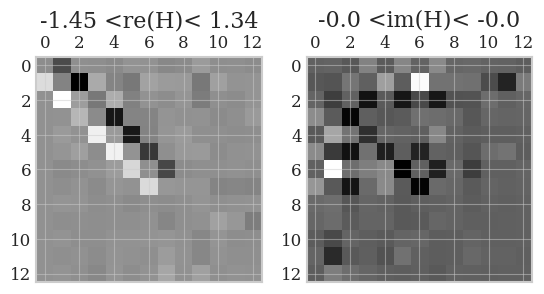

      mismatch=4.079392601685066e-12
    @@ error bound= 0.010961888107250928  at L=time vLR =  475.872287145242 .
       Updating basis with deep 7 2024-12-28 18:44:26.775781
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

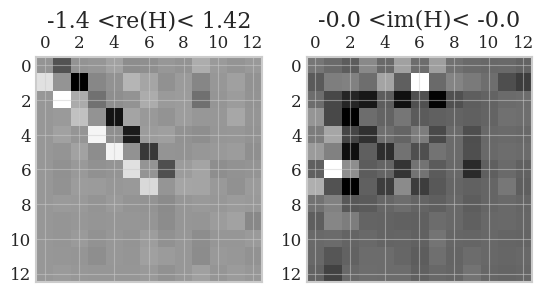

      mismatch=0.0
  t=46.601072731981766, error~0.0009729485126382396
    @@ error bound= 0.014444440237950508  at L=time vLR =  505.92737896494157 .
       Updating basis with deep 7 2024-12-28 18:50:46.391292
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators

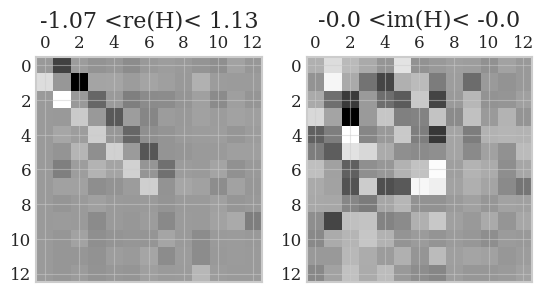

      mismatch=0.0
    @@ error bound= 0.010242585116377515  at L=time vLR =  520.9549248747912 .
       Updating basis with deep 7 2024-12-28 18:56:59.658058
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

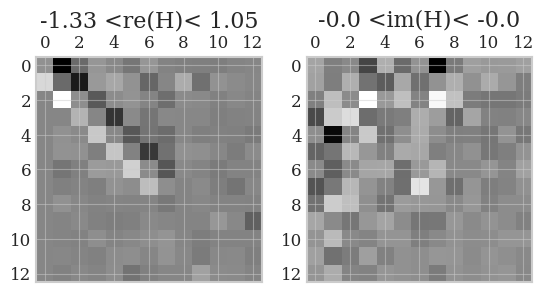

      mismatch=0.0
    @@ error bound= 0.010603851551586286  at L=time vLR =  530.9732888146912 .
       Updating basis with deep 7 2024-12-28 19:03:16.044961
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

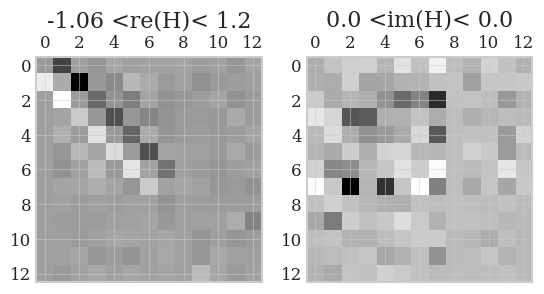

      mismatch=0.0
    @@ error bound= 0.010617198624377098  at L=time vLR =  540.991652754591 .
       Updating basis with deep 7 2024-12-28 19:09:29.798166
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

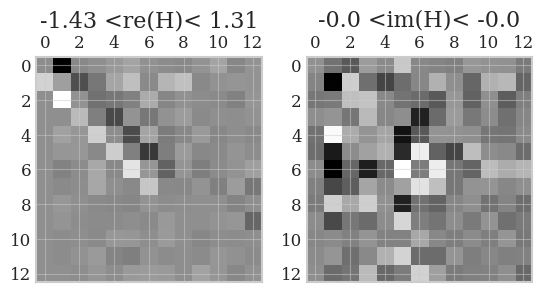

      mismatch=4.0668772760049725e-12
  t=51.261180005179945, error~0.0039017378267484602
    @@ error bound= 0.012504787215747831  at L=time vLR =  553.0136894824708 .
       Updating basis with deep 7 2024-12-28 19:15:42.517782
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators t

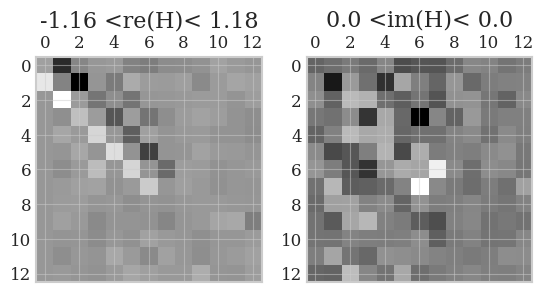

      mismatch=1.0373306095332153e-12
    @@ error bound= 0.011968669961317733  at L=time vLR =  561.0283806343906 .
       Updating basis with deep 7 2024-12-28 19:22:13.681597
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> 

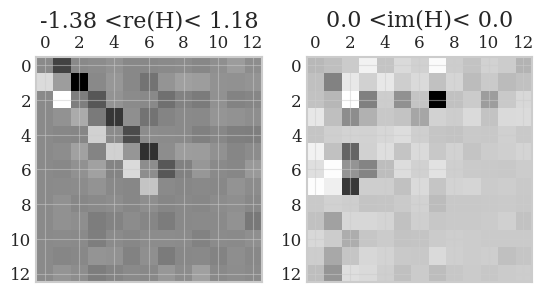

      mismatch=0.0
    @@ error bound= 0.010985569639298842  at L=time vLR =  569.0430717863105 .
       Updating basis with deep 7 2024-12-28 19:28:33.956596
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

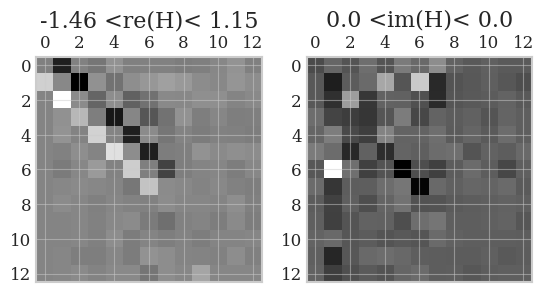

      mismatch=0.0
    @@ error bound= 0.012398471158496953  at L=time vLR =  581.0651085141902 .
       Updating basis with deep 7 2024-12-28 19:34:58.776614
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orth

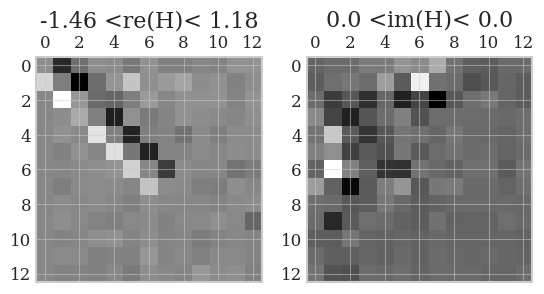

      mismatch=0.0
    @@ error bound= 0.010003195393305993  at L=time vLR =  593.08714524207 .
       Updating basis with deep 7 2024-12-28 19:41:12.234475
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

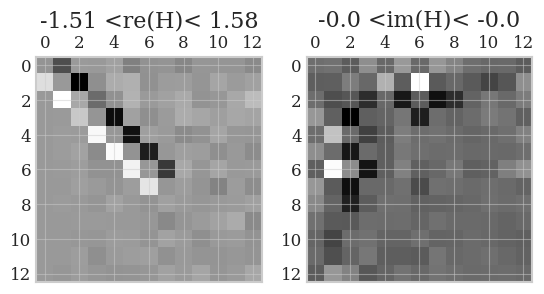

      mismatch=0.0


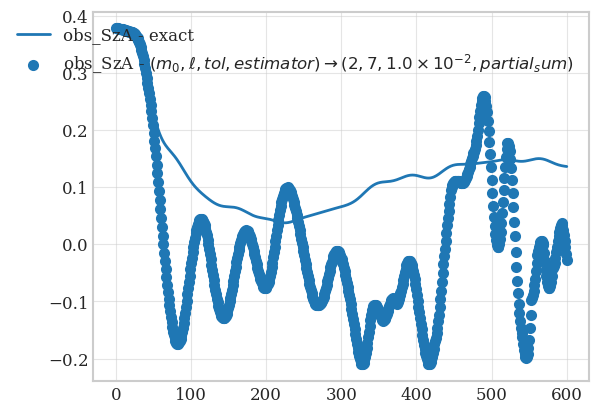

Simulation (4,3,0.01,partial_sum)
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthogonal operators
      * build Hij
      * hij_tensor:



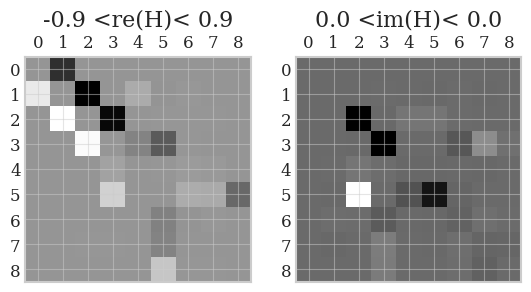

      mismatch=0.0
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    @@ error bound= 0.01099103053667423  at L=time vLR =  22.04040066777963 .
       Updating basis with deep 3 2024-12-28 19:47:45.907463
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alp

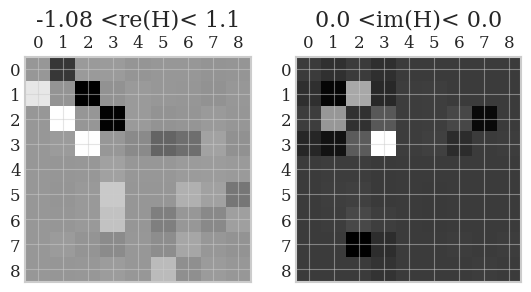

      mismatch=0.0
    @@ error bound= 0.012412089160672185  at L=time vLR =  48.088146911519196 .
       Updating basis with deep 3 2024-12-28 19:50:09.574362
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

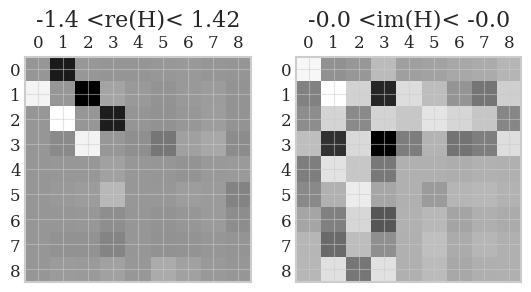

      mismatch=1.008814429288158e-12
  t=4.660107273198177, error~4.431856665933626e-06
    @@ error bound= 0.0144229753275043  at L=time vLR =  56.10283806343906 .
       Updating basis with deep 3 2024-12-28 19:58:05.876304
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 b

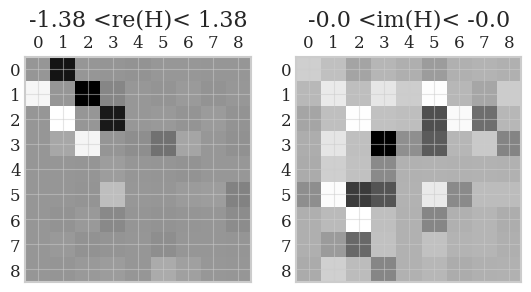

      mismatch=1.003318868307674e-12
    @@ error bound= 0.012323745636688588  at L=time vLR =  65.1193656093489 .
       Updating basis with deep 3 2024-12-28 20:07:15.097866
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now

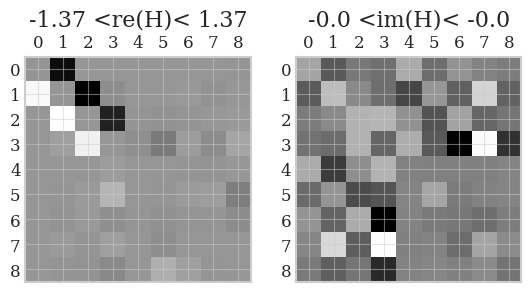

      mismatch=0.0
    @@ error bound= 0.015241086037171364  at L=time vLR =  74.13589315525876 .
       Updating basis with deep 3 2024-12-28 20:18:21.249311
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthog

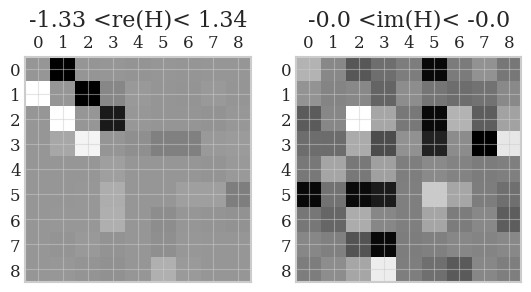

      mismatch=0.0
    @@ error bound= 0.013354624568609474  at L=time vLR =  84.1542570951586 .
       Updating basis with deep 3 2024-12-28 20:29:48.906051
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthogo

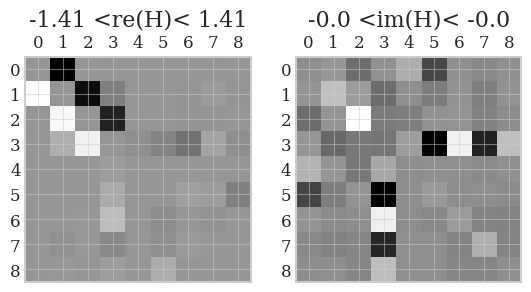

      mismatch=1.0090681910283575e-12
    @@ error bound= 0.010916743782499155  at L=time vLR =  91.16711185308847 .
       Updating basis with deep 3 2024-12-28 20:39:13.306392
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> n

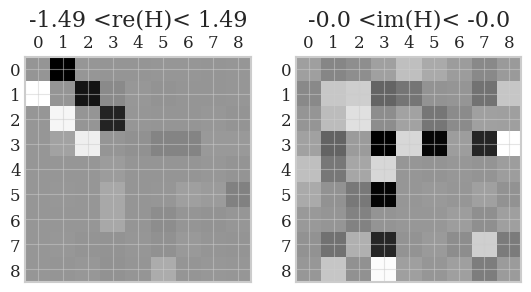

      mismatch=0.0
  t=9.320214546396354, error~0.0022099152146714115
    @@ error bound= 0.010900539339950267  at L=time vLR =  103.18914858096828 .
       Updating basis with deep 3 2024-12-28 20:48:29.186432
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
 

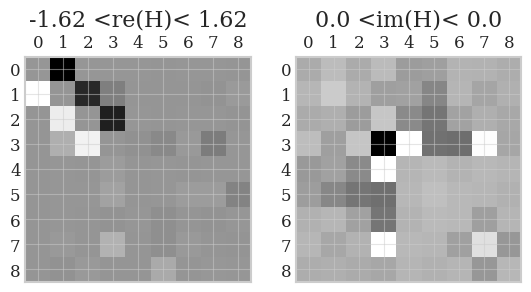

      mismatch=0.0
    @@ error bound= 0.010535318969793244  at L=time vLR =  109.20016694490818 .
       Updating basis with deep 3 2024-12-28 20:57:40.023953
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

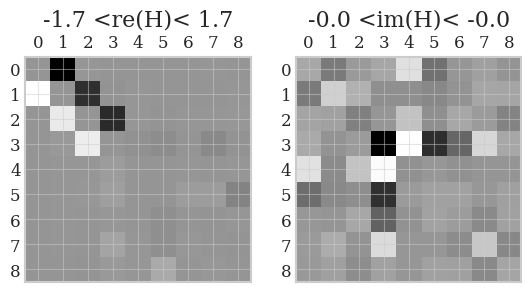

      mismatch=0.0
    @@ error bound= 0.012518203064778211  at L=time vLR =  120.220367278798 .
       Updating basis with deep 3 2024-12-28 21:06:52.947653
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthogo

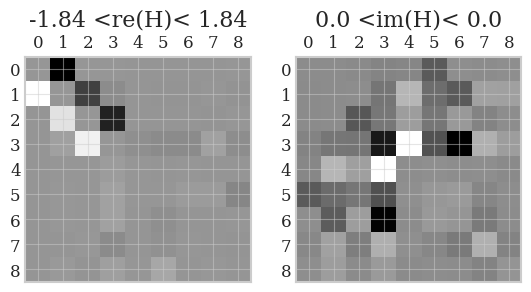

      mismatch=0.0
    @@ error bound= 0.010516538203835583  at L=time vLR =  127.23322203672787 .
       Updating basis with deep 3 2024-12-28 21:15:57.524743
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

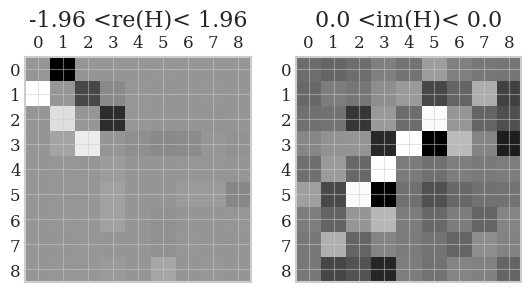

      mismatch=0.0
    @@ error bound= 0.01193407383580307  at L=time vLR =  141.25893155258765 .
       Updating basis with deep 3 2024-12-28 21:25:00.178577
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthog

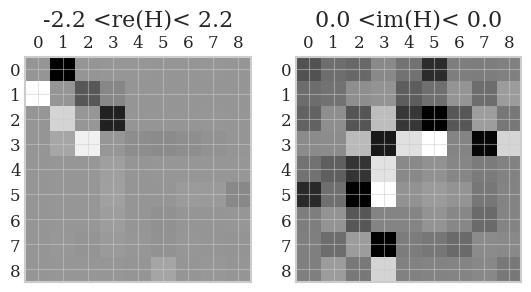

      mismatch=0.0
  t=13.980321819594531, error~0.006380507843673675
    @@ error bound= 0.010188334779974845  at L=time vLR =  150.2754590984975 .
       Updating basis with deep 3 2024-12-28 21:33:59.385976
error 13.980321819594531 0.010188334779974845
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    

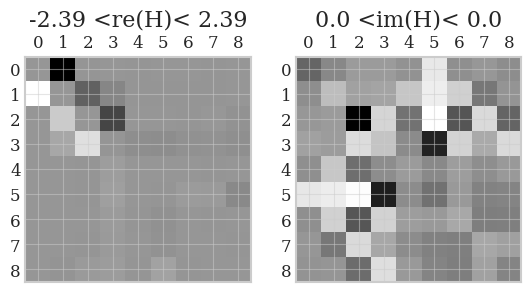

      mismatch=0.0
    @@ error bound= 0.01221672420495281  at L=time vLR =  157.28831385642738 .
       Updating basis with deep 3 2024-12-28 21:42:54.288493
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthog

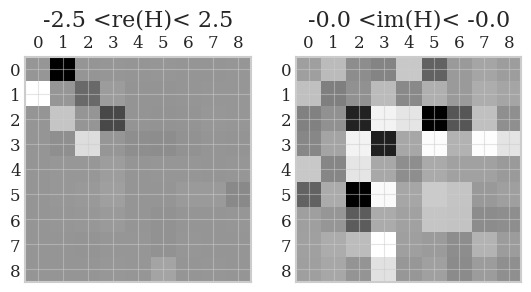

      mismatch=0.0
    @@ error bound= 0.010942191213028925  at L=time vLR =  176.32320534223703 .
       Updating basis with deep 3 2024-12-28 21:51:44.895768
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

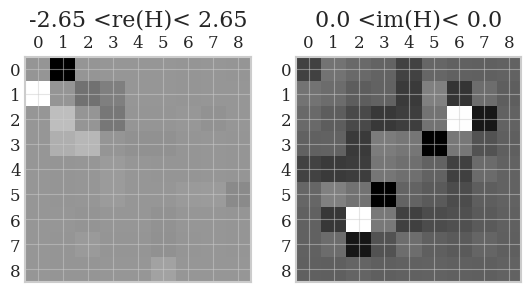

      mismatch=0.0
    @@ error bound= 0.014655175984821096  at L=time vLR =  184.33789649415692 .
       Updating basis with deep 3 2024-12-28 22:00:43.439348
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

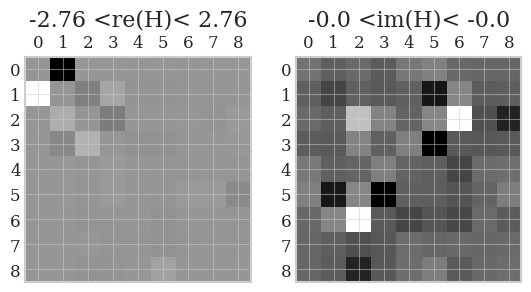

      mismatch=0.0
  t=18.640429092792708, error~0.0002055699154791092
    @@ error bound= 0.012444841627035604  at L=time vLR =  208.3819699499165 .
       Updating basis with deep 3 2024-12-28 22:09:41.403975
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
 

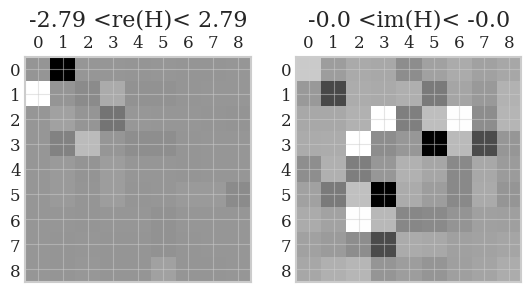

      mismatch=0.0
    @@ error bound= 0.012962460456547238  at L=time vLR =  221.4058430717863 .
       Updating basis with deep 3 2024-12-28 22:18:32.047755
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthog

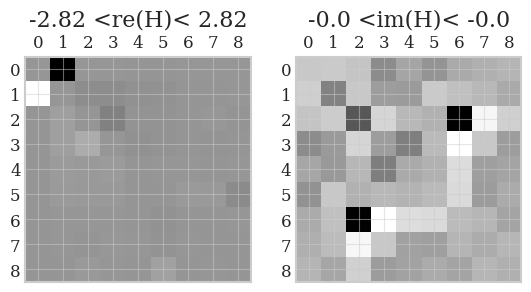

      mismatch=0.0
    @@ error bound= 0.014728590480341915  at L=time vLR =  229.42053422370617 .
       Updating basis with deep 3 2024-12-28 22:27:24.527972
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

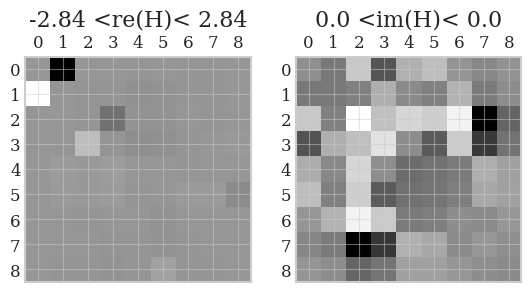

      mismatch=0.0
    @@ error bound= 0.012975386705923787  at L=time vLR =  235.43155258764608 .
       Updating basis with deep 3 2024-12-28 22:36:25.052789
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

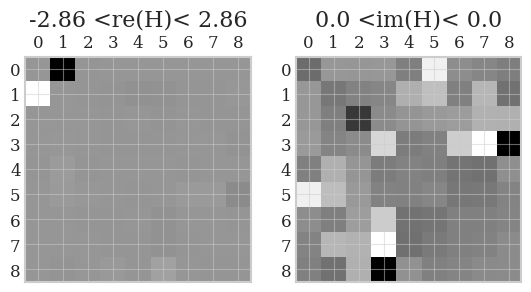

      mismatch=0.0
    @@ error bound= 0.015738083740921876  at L=time vLR =  242.44440734557597 .
       Updating basis with deep 3 2024-12-28 22:47:29.539651
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

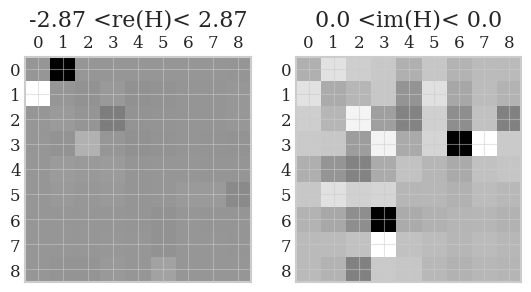

      mismatch=1.008168210046487e-12
  t=23.300536365990883, error~0.008615389927360596
    @@ error bound= 0.012502218085113329  at L=time vLR =  250.4590984974958 .
       Updating basis with deep 3 2024-12-28 22:56:08.847358
error 23.300536365990883 0.012502218085113329
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneB

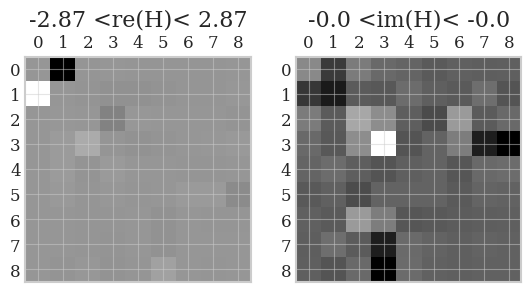

      mismatch=1.002078129075414e-12
    @@ error bound= 0.013129124249378335  at L=time vLR =  258.4737896494157 .
       Updating basis with deep 3 2024-12-28 23:04:37.971281
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> no

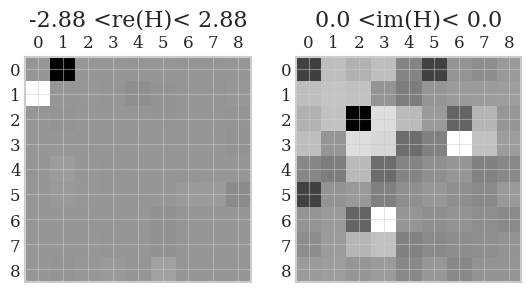

      mismatch=1.0059064822452109e-12
    @@ error bound= 0.012934267755635713  at L=time vLR =  265.4866444073456 .
       Updating basis with deep 3 2024-12-28 23:14:29.360593
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> n

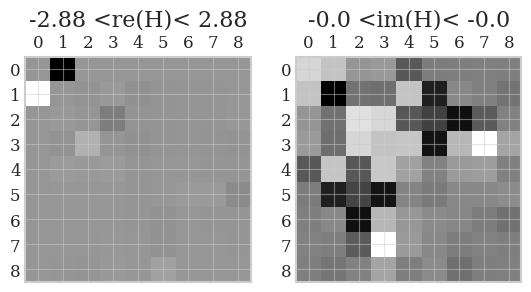

      mismatch=0.0
    @@ error bound= 0.010909849521224762  at L=time vLR =  274.50317195325545 .
       Updating basis with deep 3 2024-12-28 23:26:14.170841
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 ortho

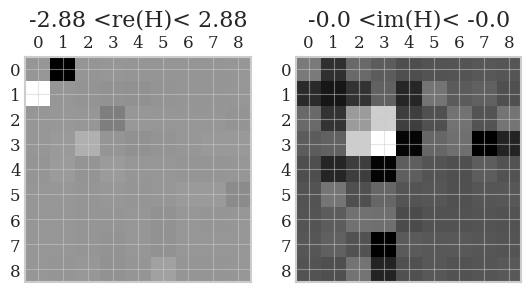

      mismatch=0.0
    @@ error bound= 0.01112323915781127  at L=time vLR =  284.52153589315526 .
       Updating basis with deep 3 2024-12-28 23:34:56.852051
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthog

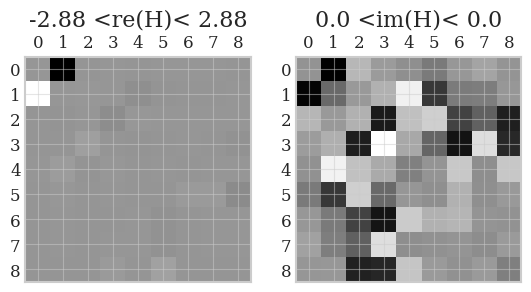

      mismatch=1.0052114634916425e-12
    @@ error bound= 0.010436348103903979  at L=time vLR =  292.5362270450751 .
       Updating basis with deep 3 2024-12-28 23:43:34.724646
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> n

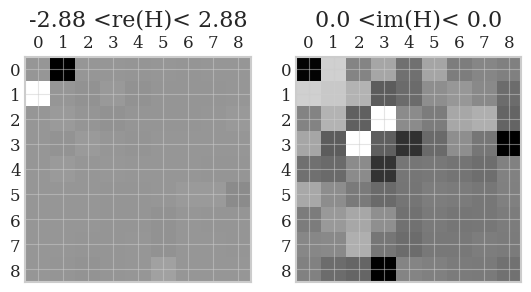

      mismatch=0.0
  t=27.960643639189062, error~0.0027961546795730167
  t=32.62075091238724, error~0.004976090000947016
  t=37.280858185585416, error~0.000515705558329915
  t=41.94096545878359, error~0.0008134515058173935
  t=46.601072731981766, error~0.0014176646861519865
  t=51.261180005179945, error~0.002466455256317076
    @@ error bound= 0.010247660317030718  at L=time vLR =  560.0265442404007 .
       Updating basis with deep 3 2024-12-28 23:52:49.331704
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body)

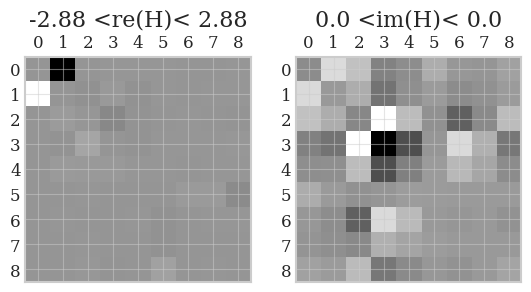

      mismatch=0.0
    @@ error bound= 0.01079265840372429  at L=time vLR =  594.08898163606 .
       Updating basis with deep 3 2024-12-29 00:01:28.600382
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 9 operators to 4 body operators
      * orthogonalize
        -> now we have 9 orthogona

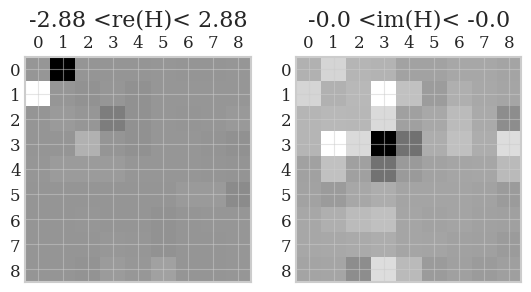

      mismatch=0.0


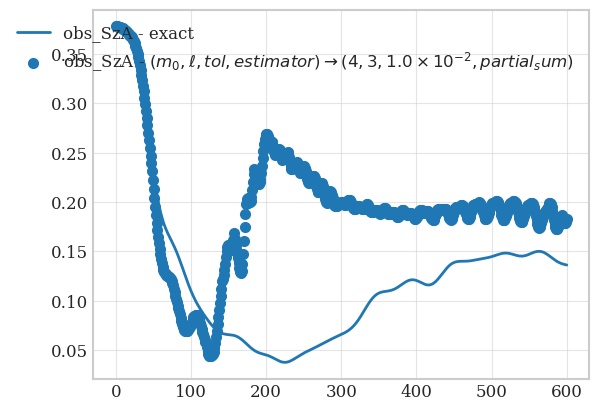

Simulation (4,7,0.01,partial_sum)
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orthogonal operators
      * build Hij
      * hij_tensor:



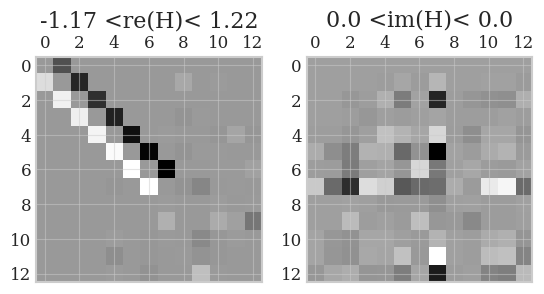

      mismatch=0.0
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    @@ error bound= 0.012747228838348373  at L=time vLR =  26.047746243739564 .
       Updating basis with deep 7 2024-12-29 00:10:22.018515
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'a

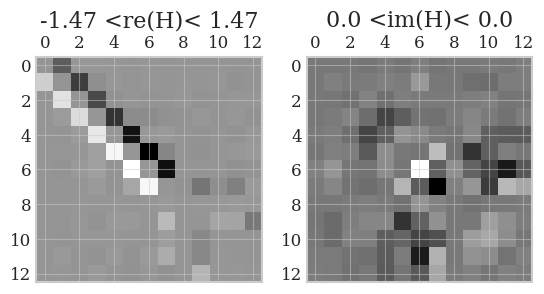

      mismatch=0.0
    @@ error bound= 0.012560374839419526  at L=time vLR =  40.073455759599334 .
       Updating basis with deep 7 2024-12-29 00:29:24.121589
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ort

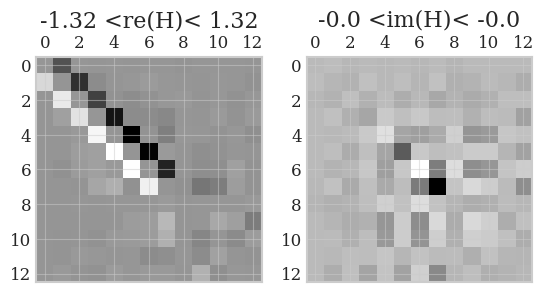

      mismatch=0.0
  t=4.660107273198177, error~0.0036974685500793317
    @@ error bound= 0.011273581196779854  at L=time vLR =  52.09549248747913 .
       Updating basis with deep 7 2024-12-29 00:49:46.919095
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
 

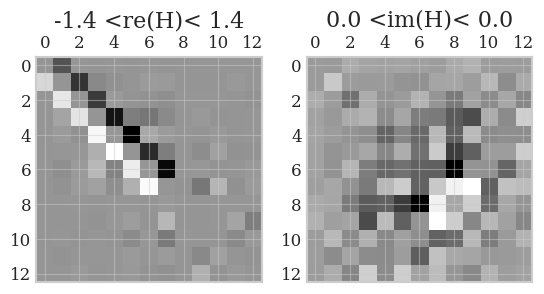

      mismatch=0.0
    @@ error bound= 0.01027106841956262  at L=time vLR =  65.1193656093489 .
       Updating basis with deep 7 2024-12-29 01:10:18.261497
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orthog

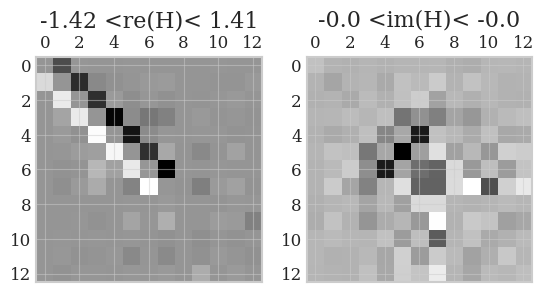

      mismatch=1.0164616912332917e-12
    @@ error bound= 0.012684185022402391  at L=time vLR =  77.14140233722871 .
       Updating basis with deep 7 2024-12-29 01:30:42.948489
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> 

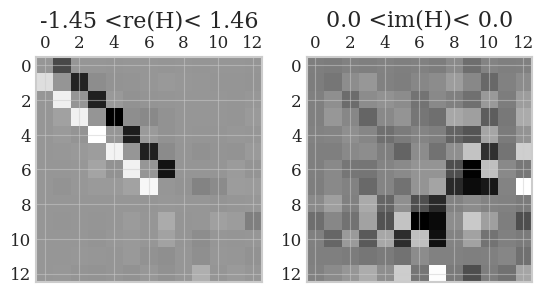

      mismatch=0.0
    @@ error bound= 0.01013617729050411  at L=time vLR =  94.17262103505843 .
       Updating basis with deep 7 2024-12-29 01:51:08.875445
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ortho

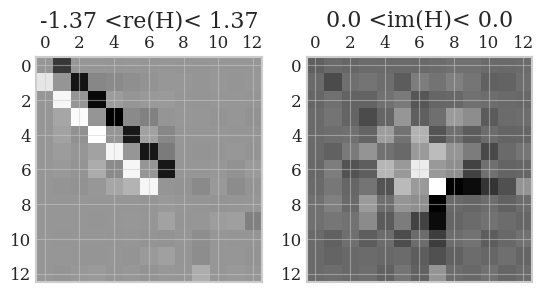

      mismatch=0.0
  t=9.320214546396354, error~0.0001540607476890102
    @@ error bound= 0.011819743431792547  at L=time vLR =  125.2295492487479 .
       Updating basis with deep 7 2024-12-29 02:11:41.892870
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
 

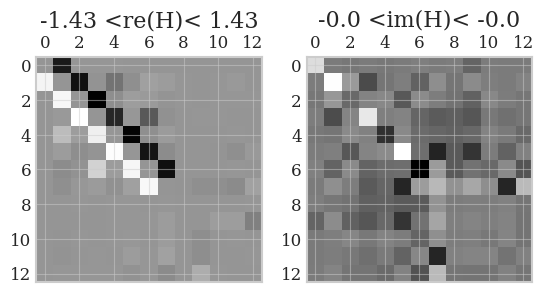

      mismatch=0.0
    @@ error bound= 0.017455311856758724  at L=time vLR =  147.26994991652754 .
       Updating basis with deep 7 2024-12-29 02:32:07.773460
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ort

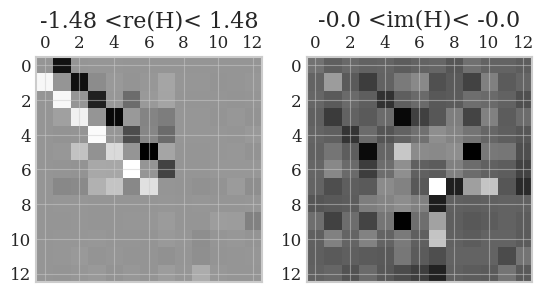

      mismatch=0.0
  t=13.980321819594531, error~6.464951609040509e-06
    @@ error bound= 0.011057774413257811  at L=time vLR =  162.2974958263773 .
       Updating basis with deep 7 2024-12-29 02:52:40.747901
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators


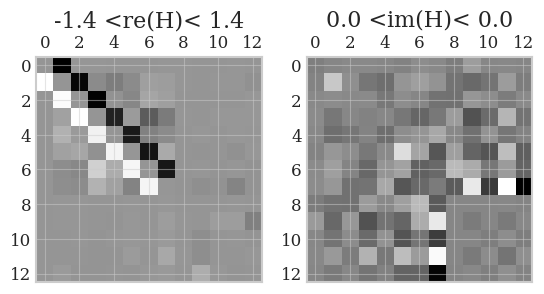

      mismatch=0.0
    @@ error bound= 0.012387660847570828  at L=time vLR =  170.31218697829715 .
       Updating basis with deep 7 2024-12-29 03:13:05.075294
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ort

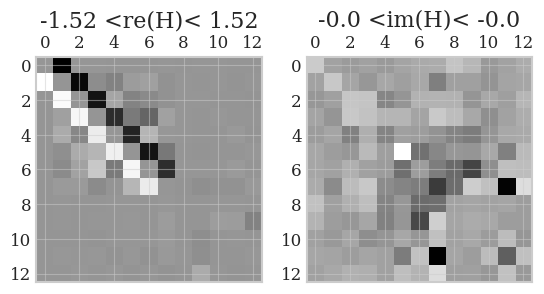

      mismatch=0.0
    @@ error bound= 0.011517467460836294  at L=time vLR =  181.33238731218697 .
       Updating basis with deep 7 2024-12-29 03:33:32.212643
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ort

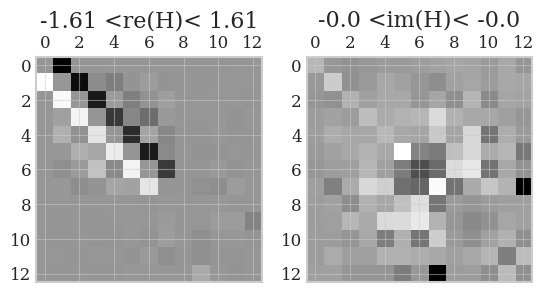

      mismatch=0.0
  t=18.640429092792708, error~0.009718261488317875
    @@ error bound= 0.010333722862517216  at L=time vLR =  202.3709515859766 .
       Updating basis with deep 7 2024-12-29 03:53:56.901028
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
 

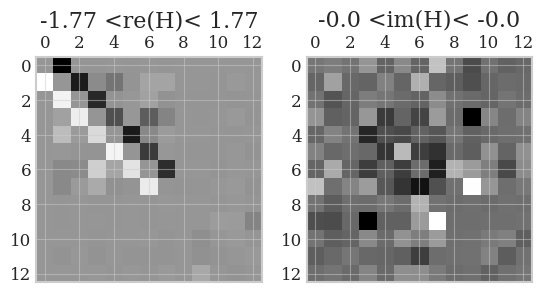

      mismatch=0.0
    @@ error bound= 0.012965960591170805  at L=time vLR =  210.3856427378965 .
       Updating basis with deep 7 2024-12-29 04:14:19.929883
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

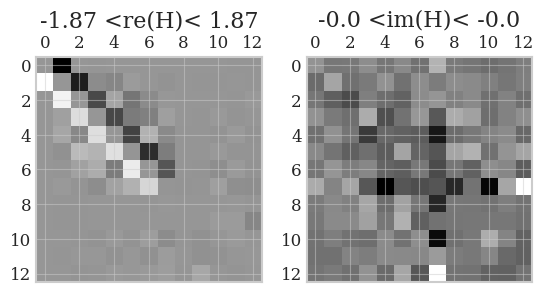

      mismatch=0.0
    @@ error bound= 0.013338581474307195  at L=time vLR =  227.4168614357262 .
       Updating basis with deep 7 2024-12-29 04:34:52.512533
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

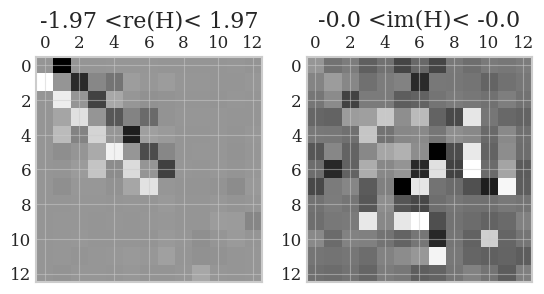

      mismatch=0.0
    @@ error bound= 0.01112294447738755  at L=time vLR =  235.43155258764608 .
       Updating basis with deep 7 2024-12-29 04:55:16.811363
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

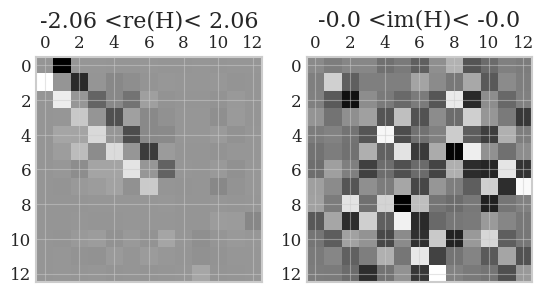

      mismatch=0.0
    @@ error bound= 0.010306402506044532  at L=time vLR =  244.44808013355592 .
       Updating basis with deep 7 2024-12-29 05:15:39.363784
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ort

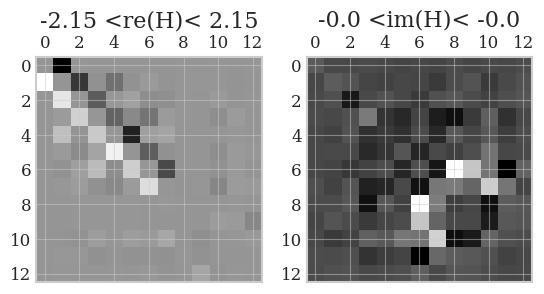

      mismatch=0.0
  t=23.300536365990883, error~0.0006247205694942485
    @@ error bound= 0.014152913862075038  at L=time vLR =  259.47562604340567 .
       Updating basis with deep 7 2024-12-29 05:36:06.753594
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators

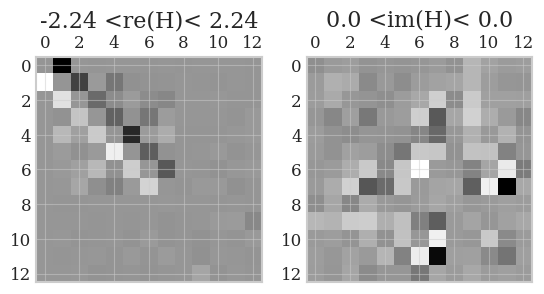

      mismatch=0.0
    @@ error bound= 0.011835319241278763  at L=time vLR =  275.5050083472454 .
       Updating basis with deep 7 2024-12-29 05:56:26.327542
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

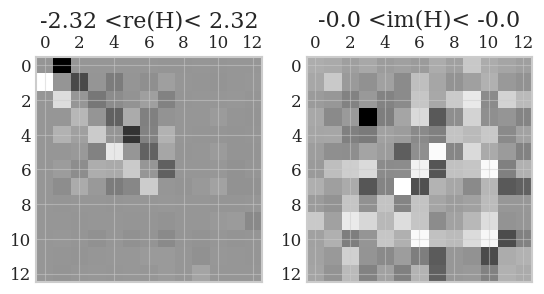

      mismatch=0.0
    @@ error bound= 0.010558851754736455  at L=time vLR =  290.5325542570951 .
       Updating basis with deep 7 2024-12-29 06:16:45.103663
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

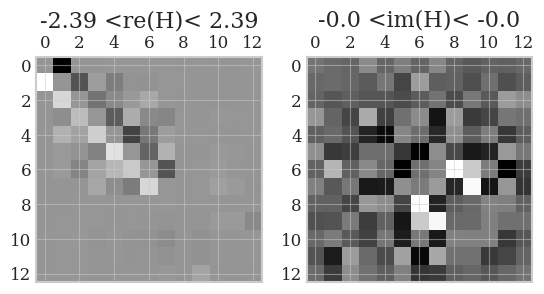

      mismatch=0.0
  t=27.960643639189062, error~3.603228982290965e-05
    @@ error bound= 0.012172213389678567  at L=time vLR =  309.5674457429048 .
       Updating basis with deep 7 2024-12-29 06:37:11.129494
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators


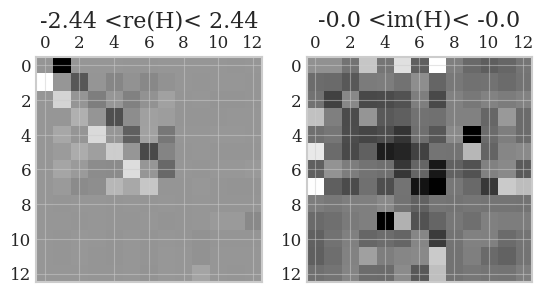

      mismatch=0.0
    @@ error bound= 0.01004710917194072  at L=time vLR =  336.6170283806344 .
       Updating basis with deep 7 2024-12-29 06:57:31.919874
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ortho

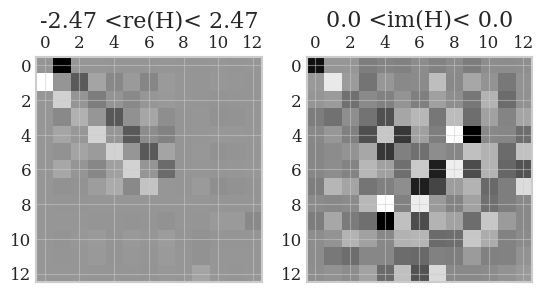

      mismatch=0.0
  t=32.62075091238724, error~0.0015581951381308894
    @@ error bound= 0.013330404740673213  at L=time vLR =  354.6500834724541 .
       Updating basis with deep 7 2024-12-29 07:17:54.661420
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
 

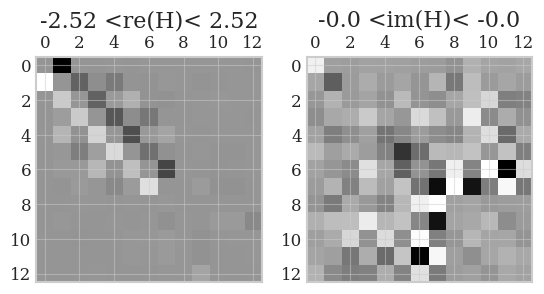

      mismatch=0.0
    @@ error bound= 0.011193256650063902  at L=time vLR =  370.6794657762938 .
       Updating basis with deep 7 2024-12-29 07:38:18.068668
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

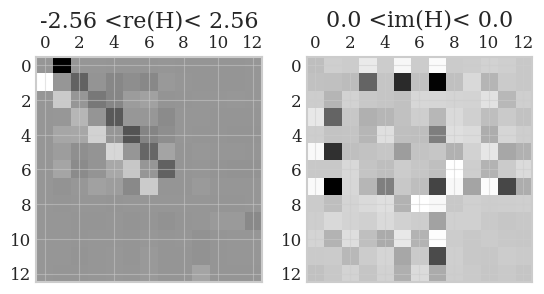

      mismatch=0.0
  t=37.280858185585416, error~0.008701257528754267
    @@ error bound= 0.010942571144072016  at L=time vLR =  401.7363939899833 .
       Updating basis with deep 7 2024-12-29 07:58:36.553799
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
 

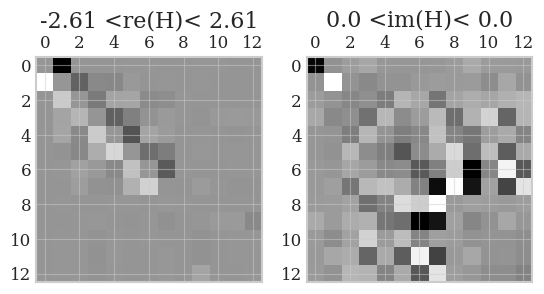

      mismatch=0.0
    @@ error bound= 0.014076857020230316  at L=time vLR =  421.773121869783 .
       Updating basis with deep 7 2024-12-29 08:18:54.573631
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ortho

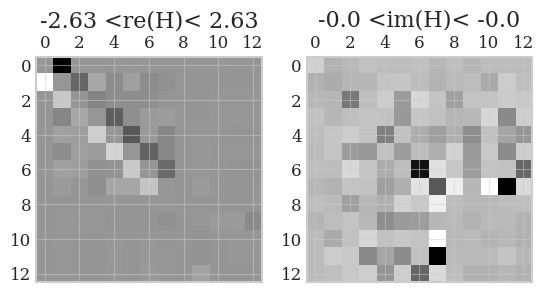

      mismatch=0.0
  t=41.94096545878359, error~0.007196450758708978
    @@ error bound= 0.010605004594385367  at L=time vLR =  457.8392320534224 .
       Updating basis with deep 7 2024-12-29 08:39:19.679710
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
  

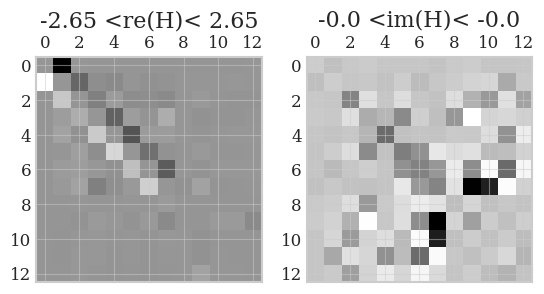

      mismatch=0.0
    @@ error bound= 0.011780074958789999  at L=time vLR =  466.8557595993322 .
       Updating basis with deep 7 2024-12-29 08:59:50.154112
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

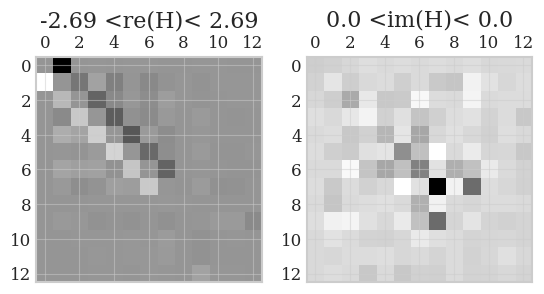

      mismatch=0.0
    @@ error bound= 0.010028698037667155  at L=time vLR =  478.877796327212 .
       Updating basis with deep 7 2024-12-29 09:20:15.322083
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ortho

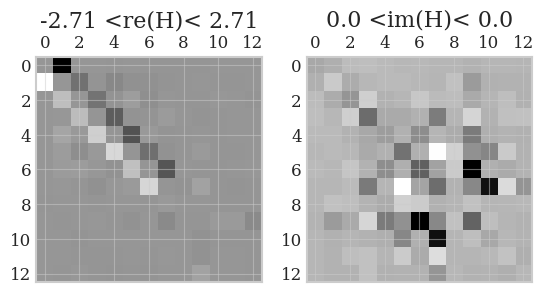

      mismatch=0.0
  t=46.601072731981766, error~0.004771806346224253
    @@ error bound= 0.01063914290228075  at L=time vLR =  531.9751252086811 .
       Updating basis with deep 7 2024-12-29 09:40:41.965560
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
  

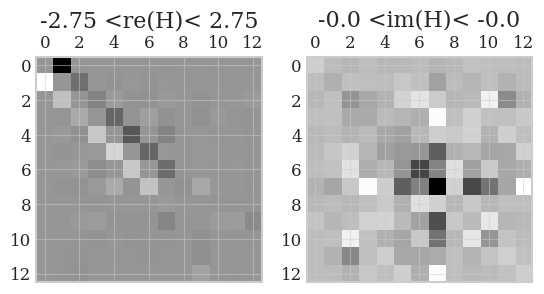

      mismatch=0.0
    @@ error bound= 0.012811315076179455  at L=time vLR =  542.995325542571 .
       Updating basis with deep 7 2024-12-29 10:00:53.972950
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 ortho

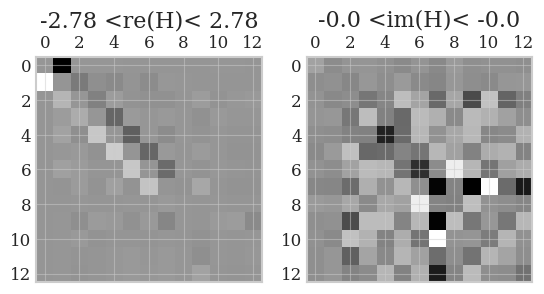

      mismatch=0.0
  t=51.261180005179945, error~0.0034565534535223653
    @@ error bound= 0.011709252736713225  at L=time vLR =  553.0136894824708 .
       Updating basis with deep 7 2024-12-29 10:21:25.137179
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators


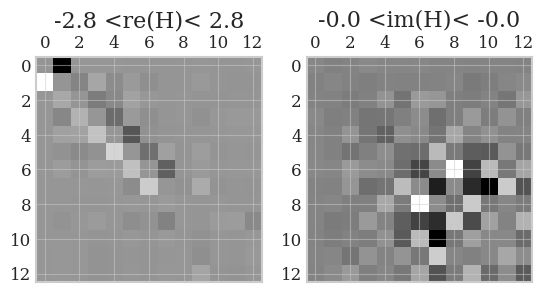

      mismatch=0.0
    @@ error bound= 0.013976929906963888  at L=time vLR =  559.0247078464107 .
       Updating basis with deep 7 2024-12-29 10:41:57.166742
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

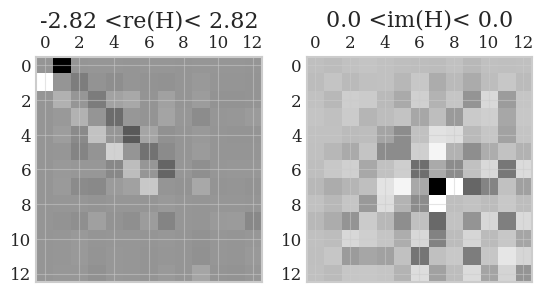

      mismatch=0.0
    @@ error bound= 0.012251651453140833  at L=time vLR =  567.0393989983305 .
       Updating basis with deep 7 2024-12-29 11:02:39.039700
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

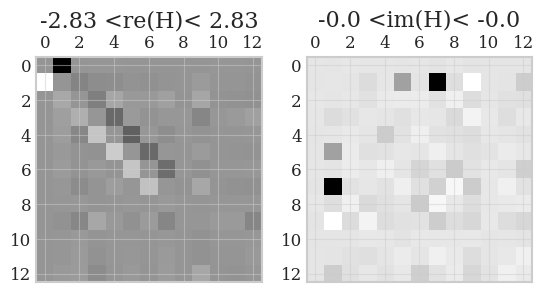

      mismatch=0.0
    @@ error bound= 0.014064742126108408  at L=time vLR =  572.0485809682805 .
       Updating basis with deep 7 2024-12-29 11:23:38.062742
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

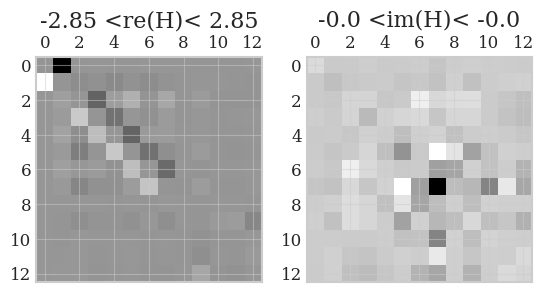

      mismatch=0.0
    @@ error bound= 0.010664891780795095  at L=time vLR =  579.0614357262103 .
       Updating basis with deep 7 2024-12-29 11:43:58.976557
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

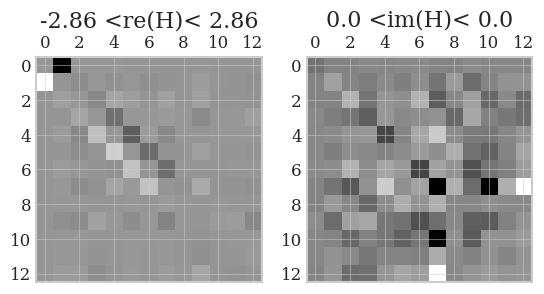

      mismatch=0.0
    @@ error bound= 0.015337426243781876  at L=time vLR =  583.0687813021702 .
       Updating basis with deep 7 2024-12-29 12:04:25.898795
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

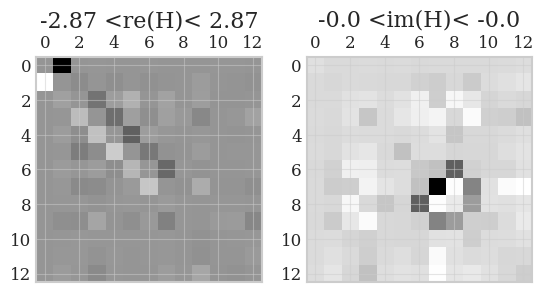

      mismatch=0.0
    @@ error bound= 0.015180864142698786  at L=time vLR =  587.0761268781301 .
       Updating basis with deep 7 2024-12-29 12:24:37.243631
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

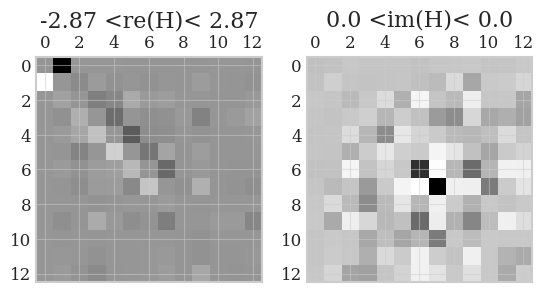

      mismatch=0.0
    @@ error bound= 0.012202711924235976  at L=time vLR =  591.0834724540902 .
       Updating basis with deep 7 2024-12-29 12:44:56.250870
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

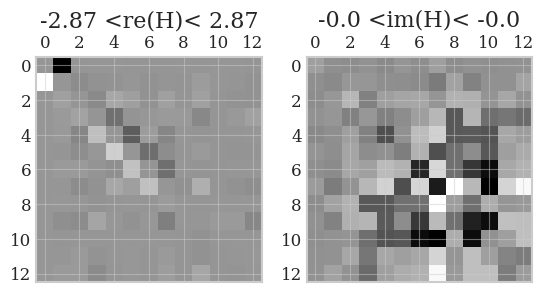

      mismatch=0.0
    @@ error bound= 0.013769864234915384  at L=time vLR =  595.0908180300501 .
       Updating basis with deep 7 2024-12-29 13:05:19.081282
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> now we have 13 orth

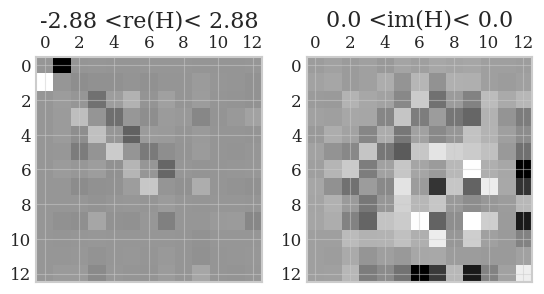

      mismatch=1.0071562721569891e-12
    @@ error bound= 0.011654401330406348  at L=time vLR =  599.09816360601 .
       Updating basis with deep 7 2024-12-29 13:25:28.594641
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 4 body operators
      * orthogonalize
        -> no

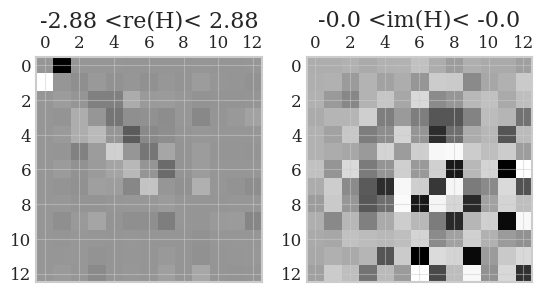

      mismatch=0.0


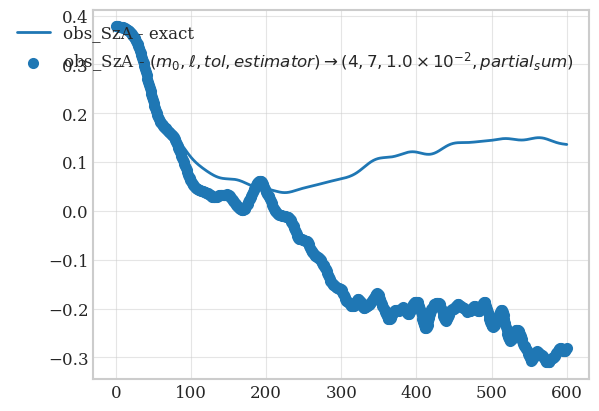

In [13]:
from scipy.sparse.linalg import ArpackNoConvergence

system_dict = setup_initial_state(setup_quantum_system(PARAMS))
vLR = system_dict["v_lr"]


#simulations.pop('(2,3,0.1,partial_sum)')
#simulations.pop('(2,5,0.1,partial_sum)')
#simulations.pop('(2,7,0.1,partial_sum)')
#simulations.pop('(3,3,0.1,partial_sum)')
#simulations.pop('(3,5,0.1,partial_sum)')
#simulations.pop('(3,7,0.1,partial_sum)')


cases = []
for m_0 in [2, 4]:
    for depth in [3, 7]:
        for epstol in [.01]: 
            for error_estimator in ERROR_ESTIMATORS:
                cases.append({
                        'm0':m_0,
                        'chosen_depth':depth,
                        'eps':epstol,
                        'error_estimator': error_estimator,
                    })

for approx_parms in cases:
    simulation_name = (
        f"({approx_parms['m0']},{approx_parms['chosen_depth']},"
        f"{approx_parms['eps']},{approx_parms['error_estimator']})"
    )
    if simulation_name in simulations:
            continue    
    simulations[simulation_name] = {
        "parms":approx_parms,
        "date": str(datetime.now()),
        "name": simulation_name,
    }
    try:
        print("Simulation", simulation_name)
        run_maxent_simulation(simulations[simulation_name], system_dict)
    except ArpackNoConvergence:
        print("arpack convergence failed")
        raise

    mostrar_observables([simulation_name], ["obs_SzA"])
    with open(f"{SIMULATIONS_FILE_PREFIX}.pkl", "bw") as out_file:
        pickle.dump(simulations, out_file)

In [ ]:
LAST_REFERENCE_FRAME['last']["basis"][0].eigenenergies()

Simulation (2,7,1.0,weights)
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthogonal operators
      * build Hij
      * hij_tensor:



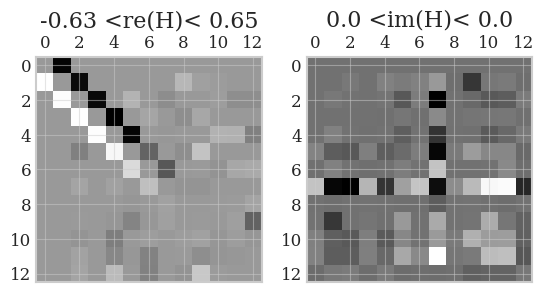

      mismatch=0.0
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
    @@ error bound= 1.0022075853034393  at L=time vLR =  23.042237061769615 .
       Updating basis with deep 7 2024-12-29 14:54:02.433008
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alp

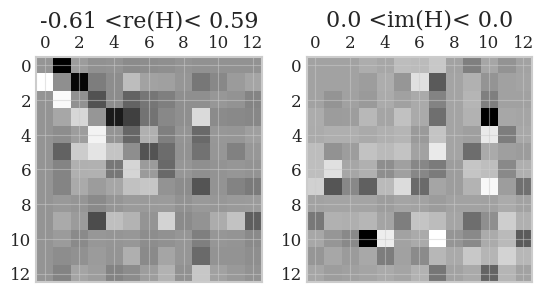

      mismatch=0.0
    @@ error bound= 1.0004992245918558  at L=time vLR =  34.06243739565943 .
       Updating basis with deep 7 2024-12-29 14:58:51.524288
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

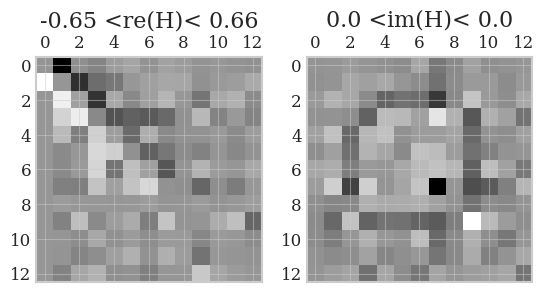

      mismatch=0.0
    @@ error bound= 1.0805525814819512  at L=time vLR =  43.07896494156928 .
       Updating basis with deep 7 2024-12-29 15:04:41.220493
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

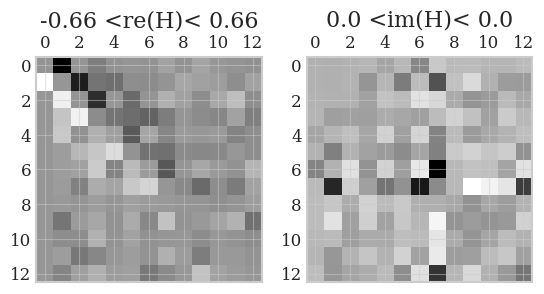

      mismatch=1.028842508489108e-12
  t=4.660107273198177, error~0.9467254546955034
    @@ error bound= 1.020928003333971  at L=time vLR =  50.09181969949917 .
       Updating basis with deep 7 2024-12-29 15:10:38.040060
error 4.660107273198177 1.020928003333971
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperato

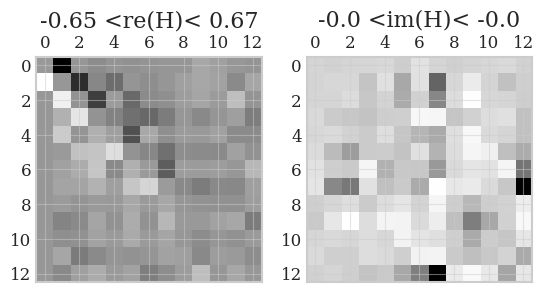

      mismatch=1.0510189071596063e-12
    @@ error bound= 1.0433444448423301  at L=time vLR =  56.10283806343906 .
       Updating basis with deep 7 2024-12-29 15:16:32.867073
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

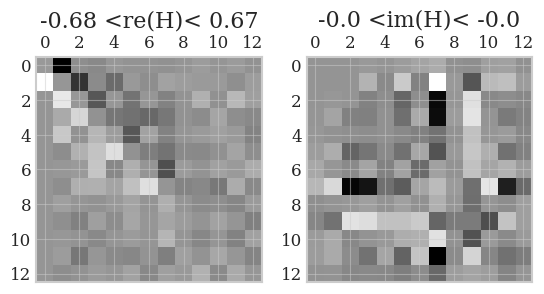

      mismatch=1.014416069069838e-12
    @@ error bound= 1.0735644682031429  at L=time vLR =  62.11385642737897 .
       Updating basis with deep 7 2024-12-29 15:22:25.803672
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

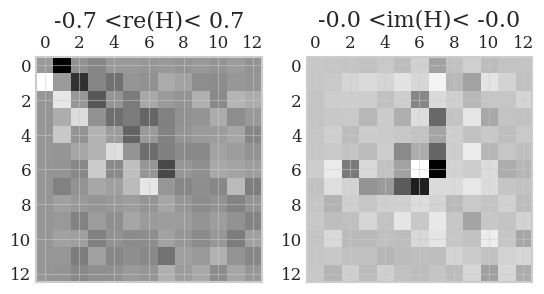

      mismatch=1.0770198179328993e-12
    @@ error bound= 1.0039841884393768  at L=time vLR =  67.12303839732888 .
       Updating basis with deep 7 2024-12-29 15:28:26.150190
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

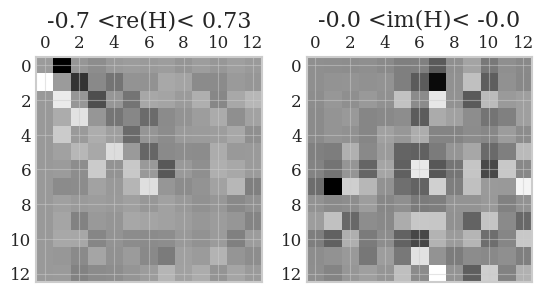

      mismatch=1.0559079268376727e-12
    @@ error bound= 1.0261868875685547  at L=time vLR =  72.13222036727879 .
       Updating basis with deep 7 2024-12-29 15:34:25.868686
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

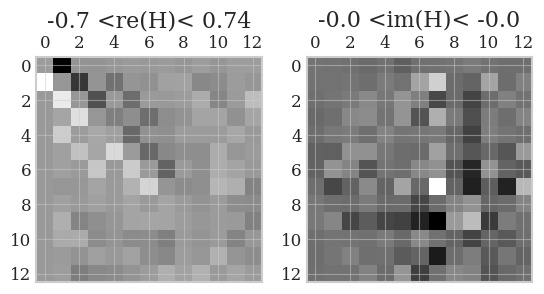

      mismatch=0.0
    @@ error bound= 1.0441887067638085  at L=time vLR =  77.14140233722871 .
       Updating basis with deep 7 2024-12-29 15:41:06.613426
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

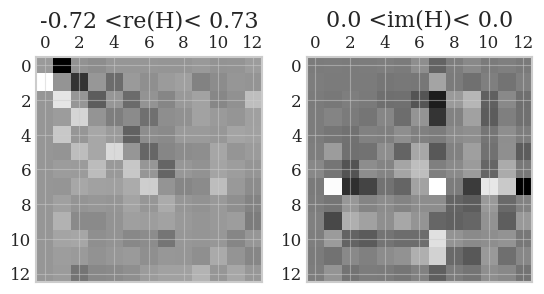

      mismatch=1.0481692363973001e-12
    @@ error bound= 1.0604246677267213  at L=time vLR =  82.15058430717863 .
       Updating basis with deep 7 2024-12-29 15:47:16.050141
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

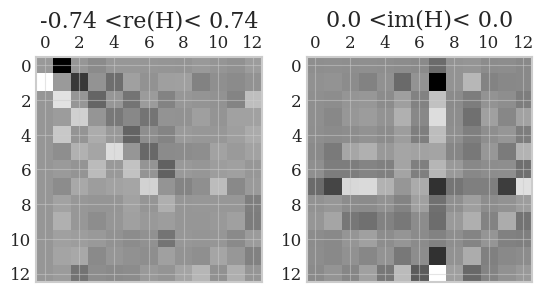

      mismatch=1.0538784046278001e-12
    @@ error bound= 1.0785297495757526  at L=time vLR =  87.15976627712855 .
       Updating basis with deep 7 2024-12-29 15:53:24.390965
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

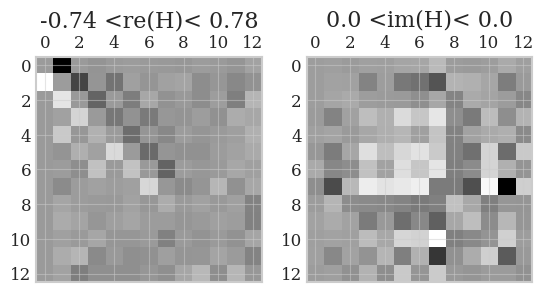

      mismatch=1.039912690194255e-12
    @@ error bound= 1.0082300429700766  at L=time vLR =  91.16711185308847 .
       Updating basis with deep 7 2024-12-29 15:59:39.300488
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

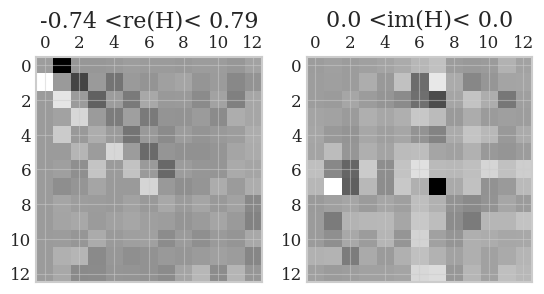

      mismatch=0.0
    @@ error bound= 1.0097079089687426  at L=time vLR =  95.17445742904842 .
       Updating basis with deep 7 2024-12-29 16:06:01.404666
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

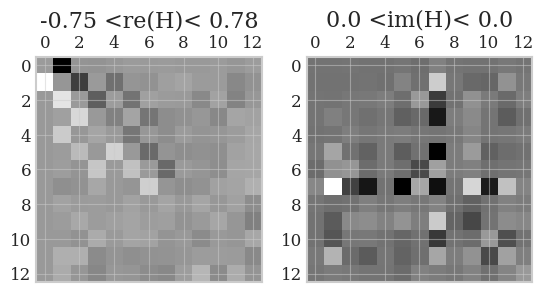

      mismatch=0.0
    @@ error bound= 1.0006502565827597  at L=time vLR =  99.18180300500835 .
       Updating basis with deep 7 2024-12-29 16:12:19.290653
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

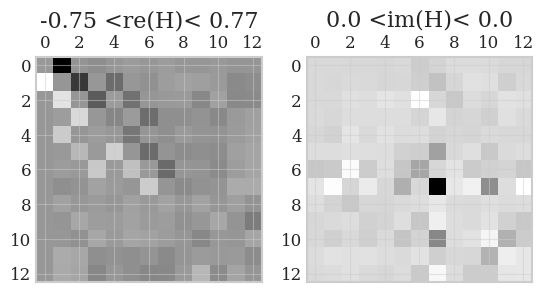

      mismatch=0.0
  t=9.320214546396354, error~1.0006502565827597
    @@ error bound= 1.0727291822976024  at L=time vLR =  104.19098497495825 .
       Updating basis with deep 7 2024-12-29 16:18:28.854130
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
     

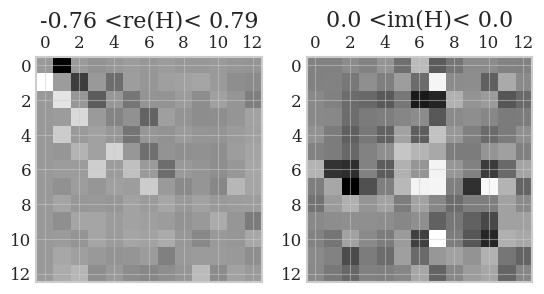

      mismatch=0.0
    @@ error bound= 1.0719933381271554  at L=time vLR =  109.20016694490818 .
       Updating basis with deep 7 2024-12-29 16:24:35.670725
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

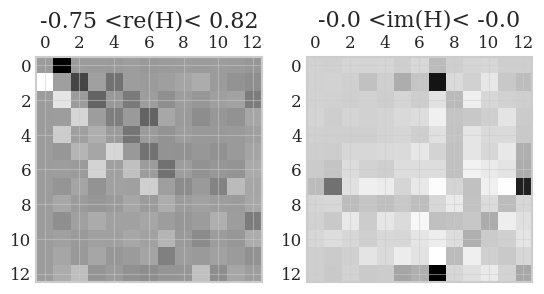

      mismatch=0.0
    @@ error bound= 1.067209934579429  at L=time vLR =  114.20934891485808 .
       Updating basis with deep 7 2024-12-29 16:30:42.640092
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

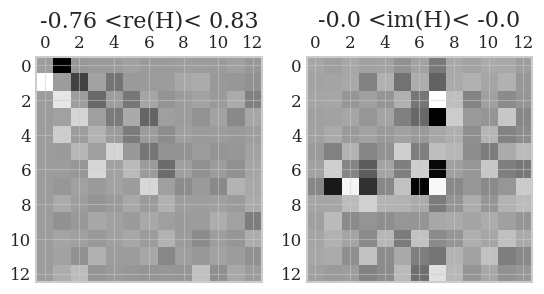

      mismatch=1.020937871683437e-12
    @@ error bound= 1.0485856208223732  at L=time vLR =  119.218530884808 .
       Updating basis with deep 7 2024-12-29 16:36:59.083629
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now 

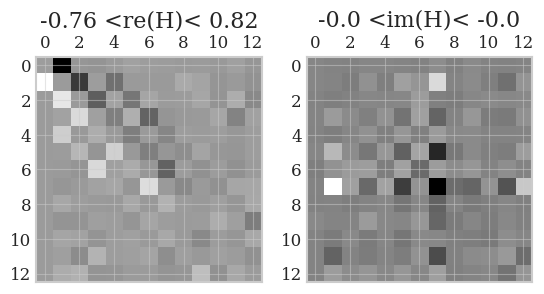

      mismatch=0.0
    @@ error bound= 1.0384834834264498  at L=time vLR =  124.22771285475794 .
       Updating basis with deep 7 2024-12-29 16:43:12.155161
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

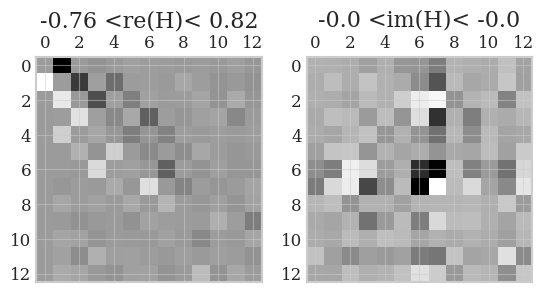

      mismatch=1.0631449412304612e-12
    @@ error bound= 1.0447747656395676  at L=time vLR =  129.23689482470786 .
       Updating basis with deep 7 2024-12-29 16:49:16.723660
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

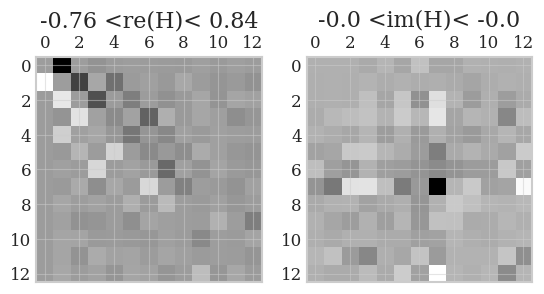

      mismatch=1.0574061805674623e-12
    @@ error bound= 1.0595678756233915  at L=time vLR =  134.24607679465777 .
       Updating basis with deep 7 2024-12-29 16:55:23.577503
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

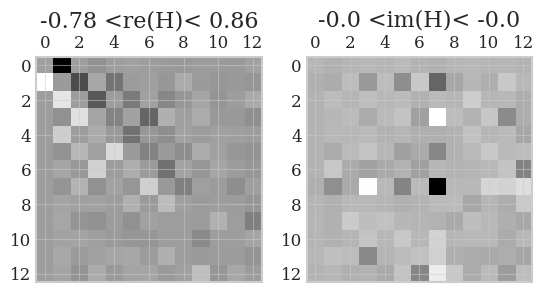

      mismatch=1.0491832845969356e-12
    @@ error bound= 1.061056147310762  at L=time vLR =  139.25525876460767 .
       Updating basis with deep 7 2024-12-29 17:01:30.703694
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

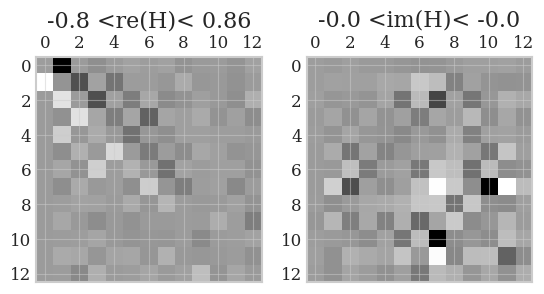

      mismatch=0.0
    @@ error bound= 1.056190736551669  at L=time vLR =  144.26444073455758 .
       Updating basis with deep 7 2024-12-29 17:07:38.803667
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

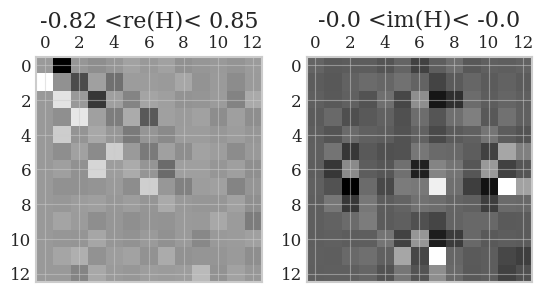

      mismatch=0.0
    @@ error bound= 1.0626998889044343  at L=time vLR =  149.27362270450752 .
       Updating basis with deep 7 2024-12-29 17:13:44.575669
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

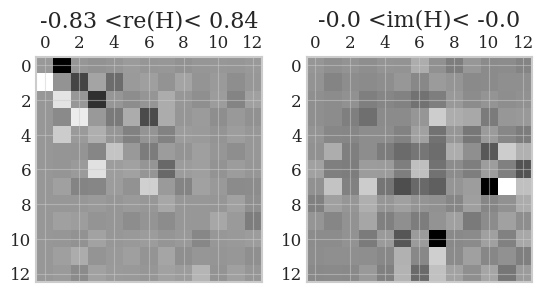

      mismatch=1.0535867259090278e-12
  t=13.980321819594531, error~1.0626998889044343
    @@ error bound= 1.0582897230701587  at L=time vLR =  154.28280467445742 .
       Updating basis with deep 7 2024-12-29 17:19:52.009828
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 

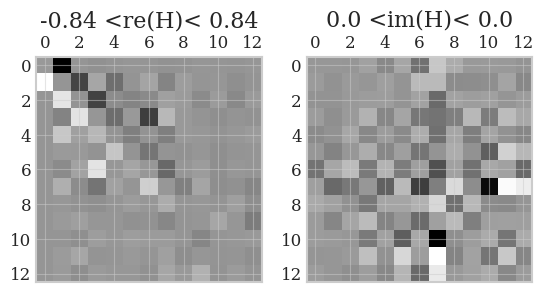

      mismatch=1.0382987638479813e-12
    @@ error bound= 1.0497651715627956  at L=time vLR =  159.29198664440733 .
       Updating basis with deep 7 2024-12-29 17:25:56.951173
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

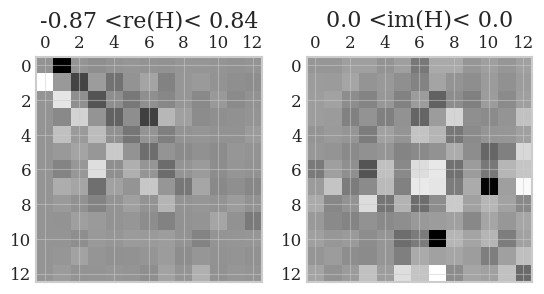

      mismatch=1.0369372570331077e-12
    @@ error bound= 1.0285146877340767  at L=time vLR =  164.30116861435727 .
       Updating basis with deep 7 2024-12-29 17:31:57.992177
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

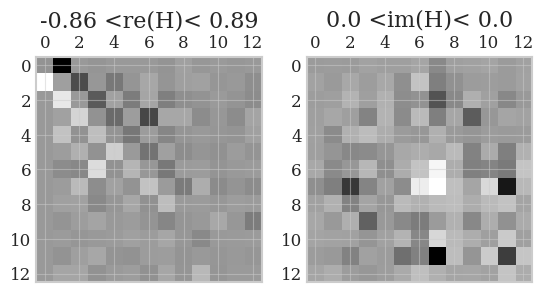

      mismatch=1.0505998128461491e-12
    @@ error bound= 1.085121871839238  at L=time vLR =  170.31218697829715 .
       Updating basis with deep 7 2024-12-29 17:38:18.709066
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

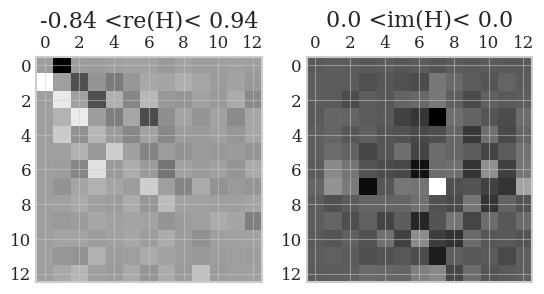

      mismatch=1.0826869018042842e-12
    @@ error bound= 1.078663907743305  at L=time vLR =  176.32320534223703 .
       Updating basis with deep 7 2024-12-29 17:44:26.334762
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

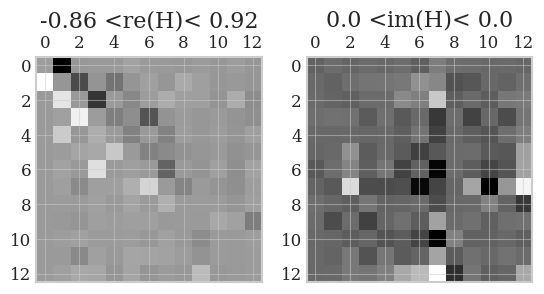

      mismatch=1.044909599120683e-12
    @@ error bound= 1.0774520372551697  at L=time vLR =  182.33422370617694 .
       Updating basis with deep 7 2024-12-29 17:50:28.825175
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

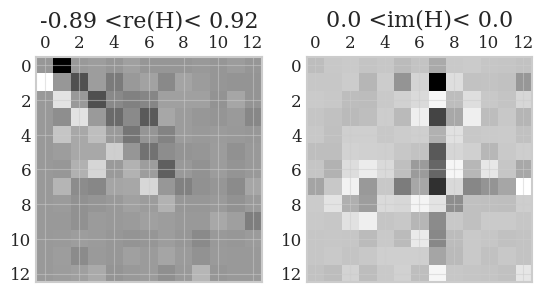

      mismatch=1.0721448372504102e-12
    @@ error bound= 1.049884287382299  at L=time vLR =  187.34340567612688 .
       Updating basis with deep 7 2024-12-29 17:56:33.767899
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

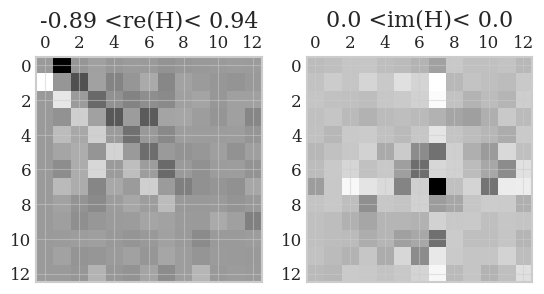

      mismatch=1.0838549750525406e-12
    @@ error bound= 1.0726814774995599  at L=time vLR =  192.35258764607678 .
       Updating basis with deep 7 2024-12-29 18:02:37.375991
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

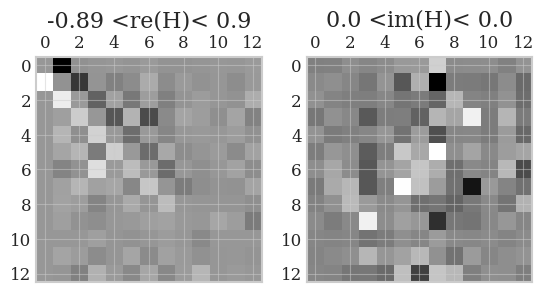

      mismatch=1.023626851851262e-12
    @@ error bound= 1.0555031594610071  at L=time vLR =  197.36176961602672 .
       Updating basis with deep 7 2024-12-29 18:09:34.068542
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

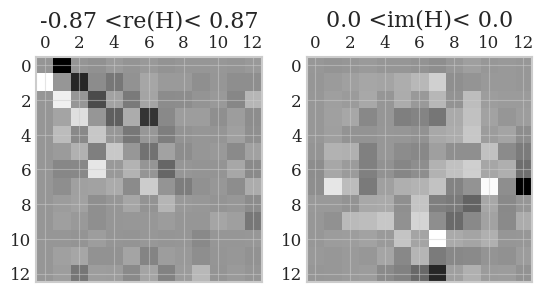

      mismatch=1.0546122941416775e-12
  t=18.640429092792708, error~0.8179500690809718
    @@ error bound= 1.0348355554531656  at L=time vLR =  202.3709515859766 .
       Updating basis with deep 7 2024-12-29 18:16:36.839238
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 b

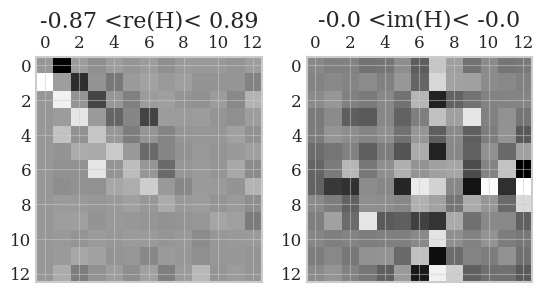

      mismatch=1.0785703974286391e-12
    @@ error bound= 1.0211387724977008  at L=time vLR =  207.38013355592653 .
       Updating basis with deep 7 2024-12-29 18:24:36.503246
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

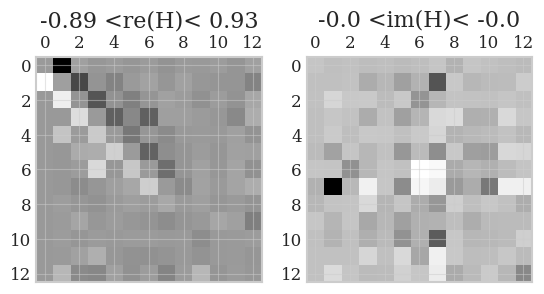

      mismatch=1.0836030810692632e-12
    @@ error bound= 1.0008225280696252  at L=time vLR =  212.38931552587644 .
       Updating basis with deep 7 2024-12-29 18:32:00.890366
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

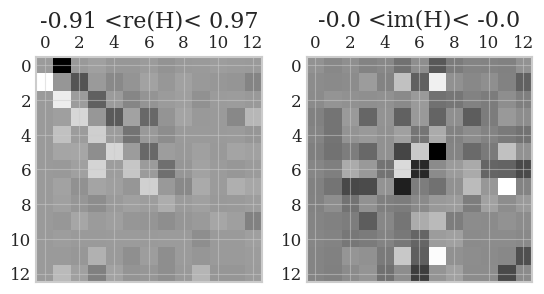

      mismatch=1.0740177667258907e-12
    @@ error bound= 1.0119008598023296  at L=time vLR =  217.39849749582638 .
       Updating basis with deep 7 2024-12-29 18:38:38.599912
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

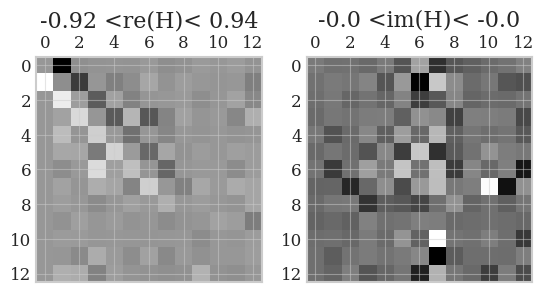

      mismatch=1.0310403408911255e-12
    @@ error bound= 1.0724950325817788  at L=time vLR =  222.4076794657763 .
       Updating basis with deep 7 2024-12-29 18:45:14.328512
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

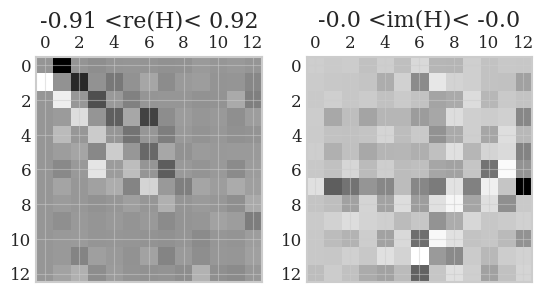

      mismatch=1.048776262617643e-12
    @@ error bound= 1.0310463668721959  at L=time vLR =  226.41502504173624 .
       Updating basis with deep 7 2024-12-29 18:51:23.366439
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

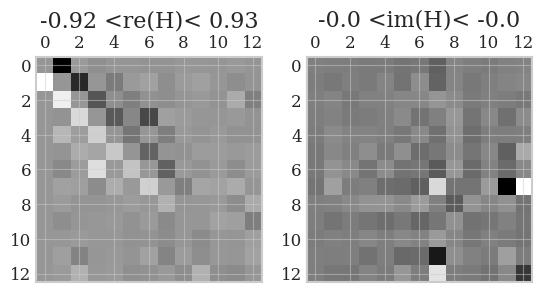

      mismatch=1.085828282787766e-12
    @@ error bound= 1.0577682621752216  at L=time vLR =  230.42237061769615 .
       Updating basis with deep 7 2024-12-29 18:57:37.331235
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

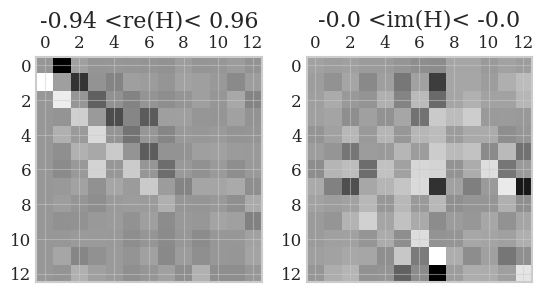

      mismatch=1.1109650558589863e-12
    @@ error bound= 1.0436526642518884  at L=time vLR =  234.42971619365608 .
       Updating basis with deep 7 2024-12-29 19:03:52.044844
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

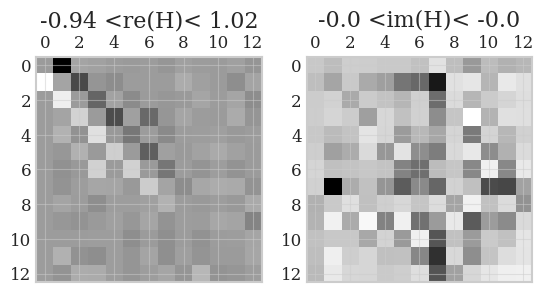

      mismatch=1.1204106831589334e-12
    @@ error bound= 1.0958868445122292  at L=time vLR =  239.438898163606 .
       Updating basis with deep 7 2024-12-29 19:10:06.447894
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

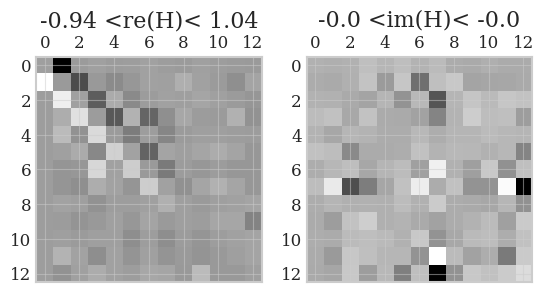

      mismatch=1.1549589606461283e-12
    @@ error bound= 1.071010278250087  at L=time vLR =  244.44808013355592 .
       Updating basis with deep 7 2024-12-29 19:16:14.820323
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

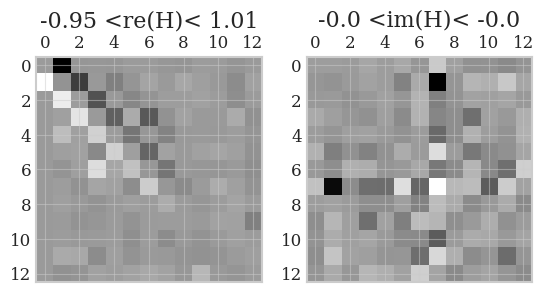

      mismatch=1.1304678466557767e-12
    @@ error bound= 1.0204404118205748  at L=time vLR =  248.45542570951588 .
       Updating basis with deep 7 2024-12-29 19:22:22.472083
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

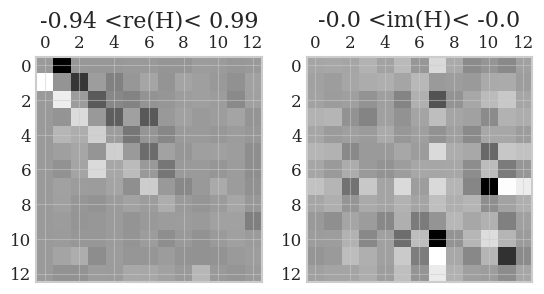

      mismatch=1.0841704162591395e-12
  t=23.300536365990883, error~0.8381685939372568
    @@ error bound= 1.083855479603193  at L=time vLR =  252.46277128547578 .
       Updating basis with deep 7 2024-12-29 19:28:30.003664
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 b

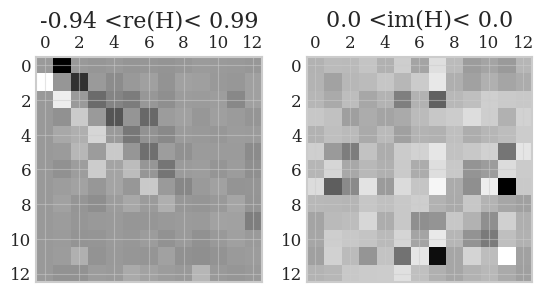

      mismatch=1.1306364550795397e-12
    @@ error bound= 1.0269830923729901  at L=time vLR =  255.46828046744574 .
       Updating basis with deep 7 2024-12-29 19:34:33.645098
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

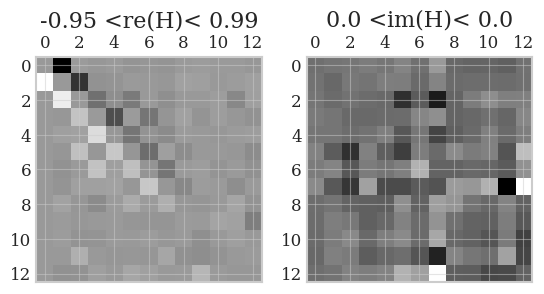

      mismatch=1.1249442783968928e-12
    @@ error bound= 1.0203223460628126  at L=time vLR =  258.4737896494157 .
       Updating basis with deep 7 2024-12-29 19:40:39.248541
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

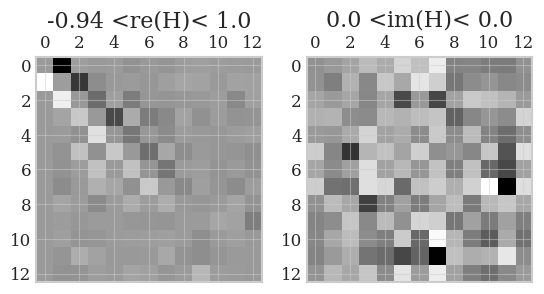

      mismatch=1.1250765138698853e-12
    @@ error bound= 1.0916127664752946  at L=time vLR =  262.4811352253756 .
       Updating basis with deep 7 2024-12-29 19:46:43.258503
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

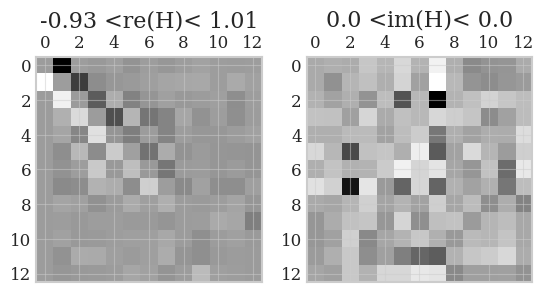

      mismatch=1.0983520667802681e-12
    @@ error bound= 1.0626331798791846  at L=time vLR =  266.4884808013355 .
       Updating basis with deep 7 2024-12-29 19:52:58.697178
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

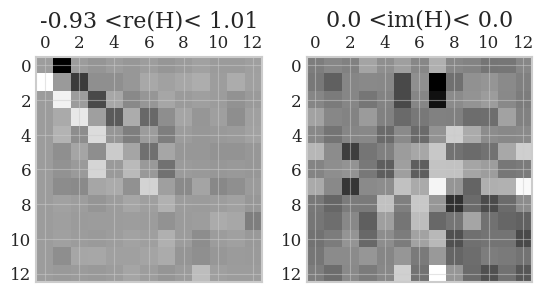

      mismatch=1.1289906032877884e-12
    @@ error bound= 1.0348338660015768  at L=time vLR =  270.4958263772955 .
       Updating basis with deep 7 2024-12-29 19:59:44.396713
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

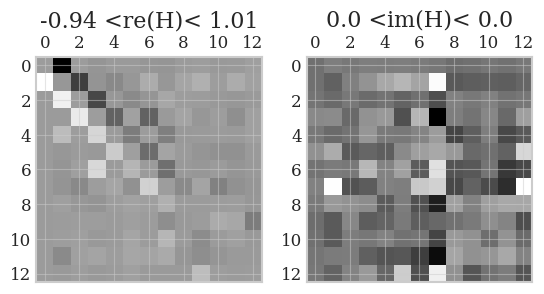

      mismatch=1.1217923722214516e-12
    @@ error bound= 1.0283675391345026  at L=time vLR =  274.50317195325545 .
       Updating basis with deep 7 2024-12-29 20:06:11.689790
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

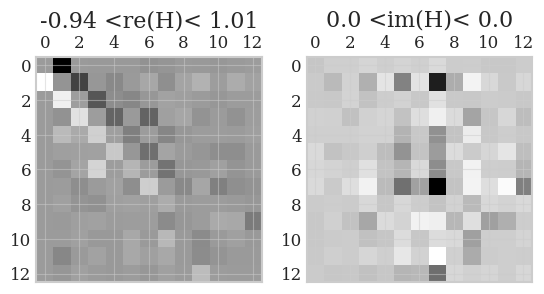

      mismatch=1.1213569537067123e-12
    @@ error bound= 1.0544906194201855  at L=time vLR =  278.51051752921535 .
       Updating basis with deep 7 2024-12-29 20:12:43.655497
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

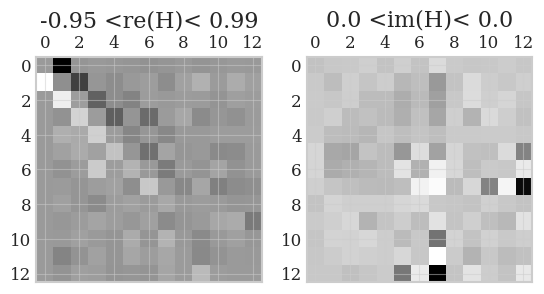

      mismatch=1.121293549223138e-12
    @@ error bound= 1.092717626680734  at L=time vLR =  282.5178631051753 .
       Updating basis with deep 7 2024-12-29 20:19:13.888827
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now 

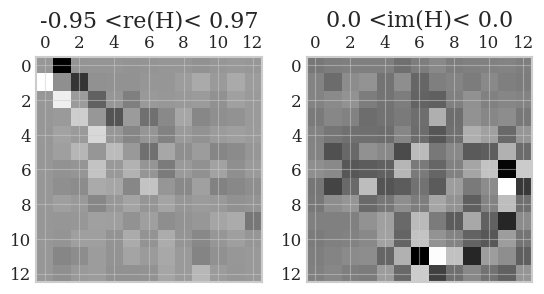

      mismatch=1.0835242569472408e-12
    @@ error bound= 1.0229036118401744  at L=time vLR =  285.5233722871452 .
       Updating basis with deep 7 2024-12-29 20:25:33.183807
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

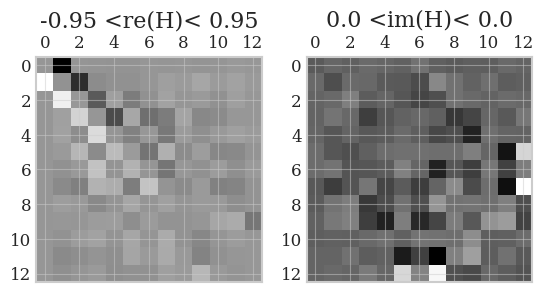

      mismatch=1.0928370653573189e-12
    @@ error bound= 1.0302553485362858  at L=time vLR =  288.52888146911516 .
       Updating basis with deep 7 2024-12-29 20:31:59.577343
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

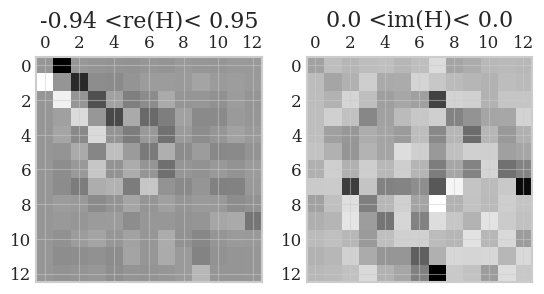

      mismatch=1.0928284991961608e-12
    @@ error bound= 1.016797743668576  at L=time vLR =  291.5343906510851 .
       Updating basis with deep 7 2024-12-29 20:38:16.561967
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

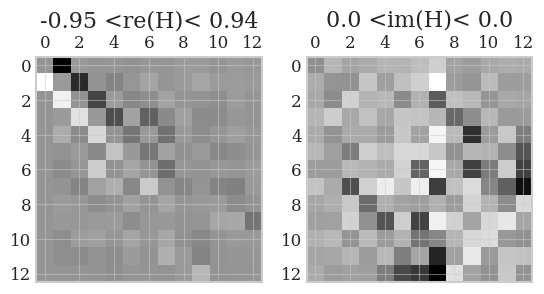

      mismatch=1.1022970788205586e-12
    @@ error bound= 1.0656411188868236  at L=time vLR =  295.5417362270451 .
       Updating basis with deep 7 2024-12-29 20:44:35.564999
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

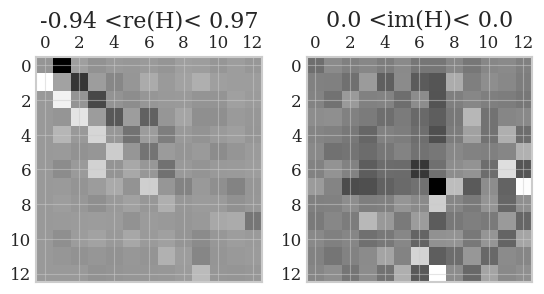

      mismatch=1.132634190041193e-12
    @@ error bound= 1.011391100368145  at L=time vLR =  299.549081803005 .
       Updating basis with deep 7 2024-12-29 20:50:54.710680
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now w

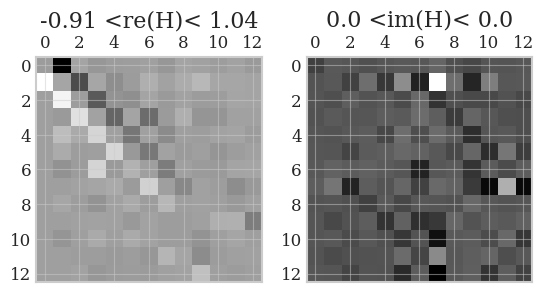

      mismatch=1.1486752123344437e-12
  t=27.960643639189062, error~1.011391100368145
    @@ error bound= 1.0718642314744078  at L=time vLR =  304.55826377295494 .
       Updating basis with deep 7 2024-12-29 20:57:46.075642
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 b

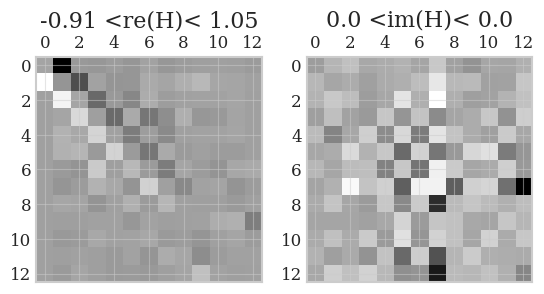

      mismatch=1.1263501233187314e-12
    @@ error bound= 1.0686284077181565  at L=time vLR =  309.5674457429048 .
       Updating basis with deep 7 2024-12-29 21:05:13.136919
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

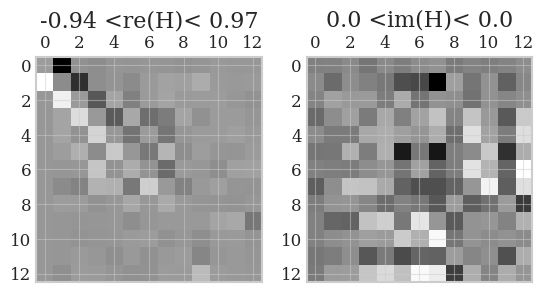

      mismatch=1.1205238756223906e-12
    @@ error bound= 1.0304876332529498  at L=time vLR =  313.57479131886475 .
       Updating basis with deep 7 2024-12-29 21:12:21.158770
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

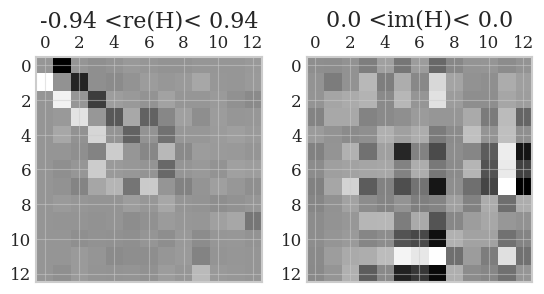

      mismatch=0.0
    @@ error bound= 1.0594901477616903  at L=time vLR =  317.5821368948247 .
       Updating basis with deep 7 2024-12-29 21:18:51.873004
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 orthog

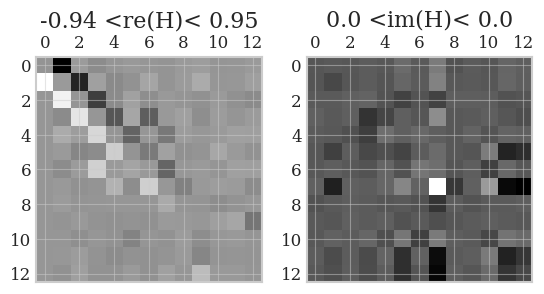

      mismatch=1.0711488401676991e-12
    @@ error bound= 1.0674862404791623  at L=time vLR =  321.5894824707846 .
       Updating basis with deep 7 2024-12-29 21:25:18.661801
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

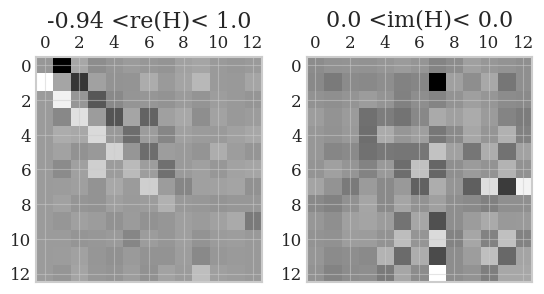

      mismatch=1.128302927045168e-12
    @@ error bound= 1.0251664267633371  at L=time vLR =  325.5968280467446 .
       Updating basis with deep 7 2024-12-29 21:32:15.471443
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

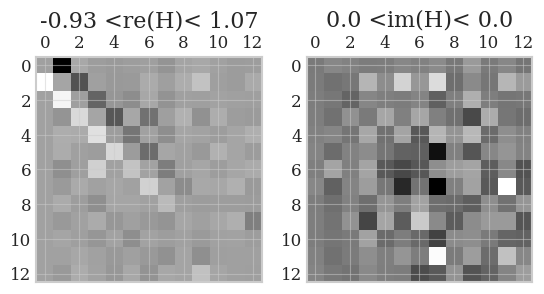

      mismatch=1.1396441936390758e-12
    @@ error bound= 1.0583859378537535  at L=time vLR =  330.6060100166945 .
       Updating basis with deep 7 2024-12-29 21:38:50.293728
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

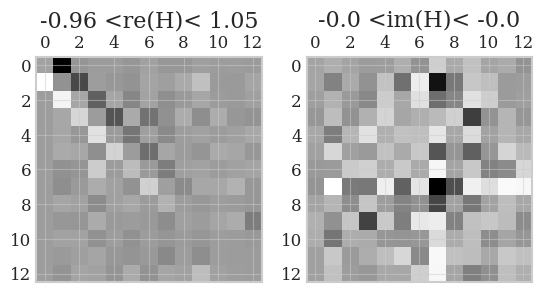

      mismatch=1.0888191832298345e-12
    @@ error bound= 1.0519077251247495  at L=time vLR =  335.6151919866444 .
       Updating basis with deep 7 2024-12-29 21:45:14.747905
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

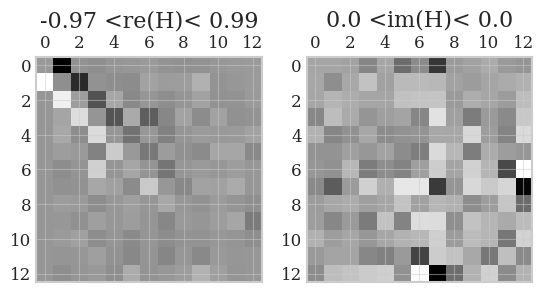

      mismatch=1.1117676644420913e-12
    @@ error bound= 1.0364846930718974  at L=time vLR =  339.62253756260435 .
       Updating basis with deep 7 2024-12-29 21:51:36.801058
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

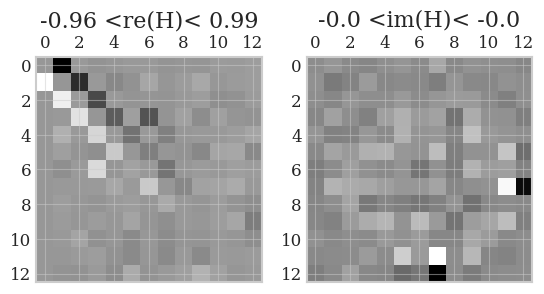

      mismatch=1.1177872334732293e-12
    @@ error bound= 1.0097888633776109  at L=time vLR =  342.6280467445743 .
       Updating basis with deep 7 2024-12-29 21:57:56.959272
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

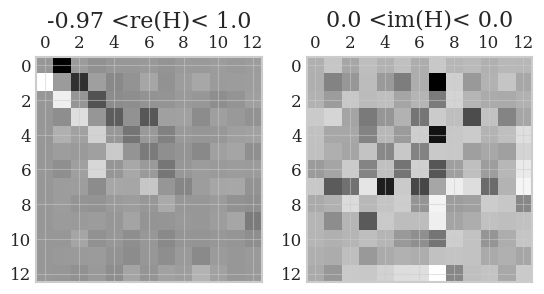

      mismatch=1.0942131017040898e-12
    @@ error bound= 1.0223491039334616  at L=time vLR =  345.6335559265442 .
       Updating basis with deep 7 2024-12-29 22:04:16.029126
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

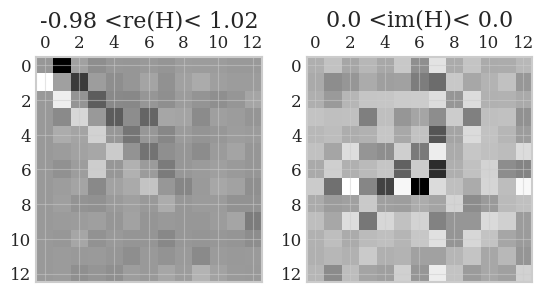

      mismatch=1.1337501266149671e-12
    @@ error bound= 1.0008020385822043  at L=time vLR =  348.6390651085142 .
       Updating basis with deep 7 2024-12-29 22:10:30.643746
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

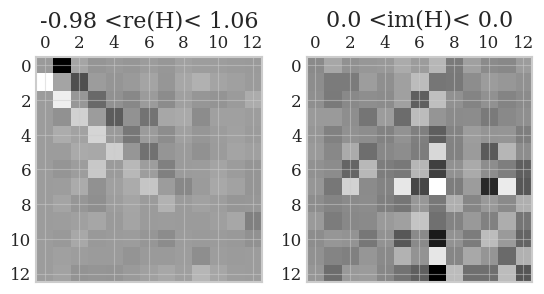

      mismatch=1.0616336518471624e-12
  t=32.62075091238724, error~0.7492970840377431
    @@ error bound= 1.053629679581241  at L=time vLR =  352.64641068447406 .
       Updating basis with deep 7 2024-12-29 22:16:46.036618
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 bo

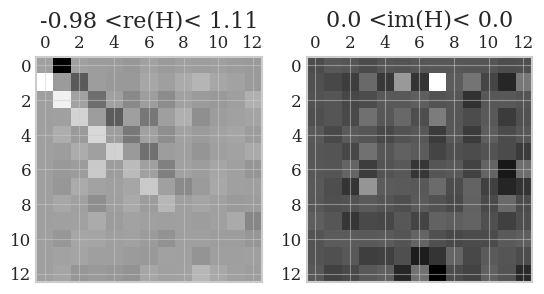

      mismatch=1.1166962397846441e-12
    @@ error bound= 1.011544421472802  at L=time vLR =  356.653756260434 .
       Updating basis with deep 7 2024-12-29 22:23:00.307888
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now 

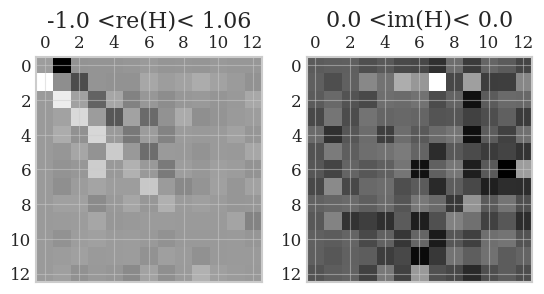

      mismatch=1.0673025432282322e-12
    @@ error bound= 1.045412288353026  at L=time vLR =  360.66110183639404 .
       Updating basis with deep 7 2024-12-29 22:29:15.795567
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> no

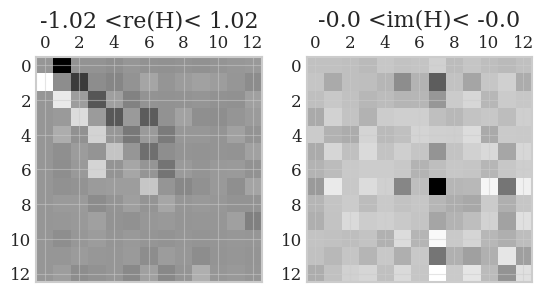

      mismatch=1.1162693279590295e-12
    @@ error bound= 1.0176461594089838  at L=time vLR =  363.66661101836394 .
       Updating basis with deep 7 2024-12-29 22:35:27.348054
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

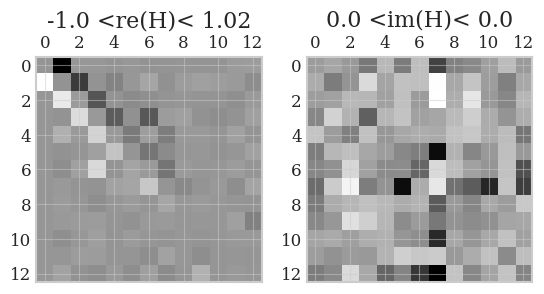

      mismatch=1.0811214357146524e-12
    @@ error bound= 1.05780193149775  at L=time vLR =  366.67212020033384 .
       Updating basis with deep 7 2024-12-29 22:41:40.759647
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now

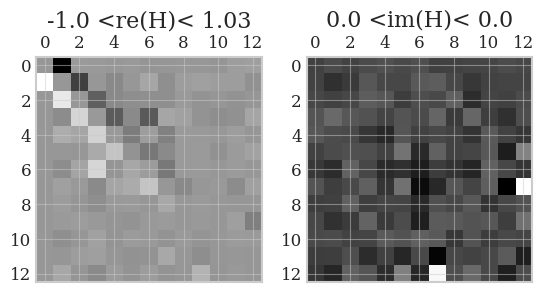

      mismatch=1.0572211584420788e-12
    @@ error bound= 1.0703956169877338  at L=time vLR =  369.67762938230385 .
       Updating basis with deep 7 2024-12-29 22:47:58.344286
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> n

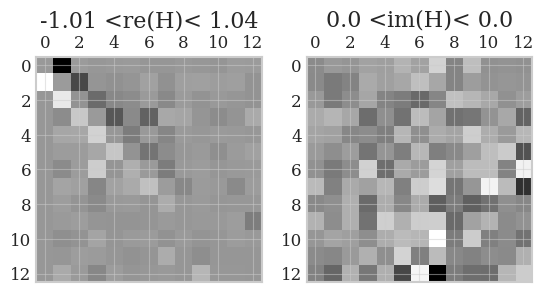

      mismatch=0.0
    @@ error bound= 1.0530666373435669  at L=time vLR =  372.68313856427375 .
       Updating basis with deep 7 2024-12-29 22:54:11.979307
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators
      * orthogonalize
        -> now we have 13 ortho

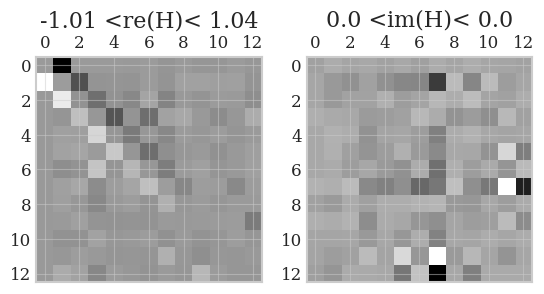

      mismatch=0.0
    @@ error bound= 1.0105965815493918  at L=time vLR =  375.68864774624376 .
       Updating basis with deep 7 2024-12-29 23:00:31.580786
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
type(K_one_body) <class 'alpsqutip.operators.arithmetic.OneBodyOperator'>
      * project 13 operators to 2 body operators


In [ ]:
ERROR_ESTIMATORS={
#    "partial_sum": lambda phi_local, ws:me.m_th_partial_sum(phi=phi_local, m=2)*50. / me.m_th_partial_sum(phi=phi_local, m=0),
    "weights":  lambda phi_local, ws: sum(abs(phi_a*w_a) for phi_a, w_a in zip(phi_local, ws)),
}


cases = []
for m_0 in [2, 3, 4]:
    for depth in [3, 5, 7]:
        for epstol in [1.]: 
            for error_estimator in ERROR_ESTIMATORS:
                cases.append({
                        'm0':m_0,
                        'chosen_depth':depth,
                        'eps':epstol,
                        'error_estimator': error_estimator,
                    })

for approx_parms in cases:
    simulation_name = (
        f"({approx_parms['m0']},{approx_parms['chosen_depth']},"
        f"{approx_parms['eps']},{approx_parms['error_estimator']})"
    )
    if simulation_name in simulations:
            continue    
    simulations[simulation_name] = {
        "parms":approx_parms,
        "date": str(datetime.now()),
        "name": simulation_name,
    }
    try:
        print("Simulation", simulation_name)
        run_maxent_simulation(simulations[simulation_name], system_dict)
    except ArpackNoConvergence:
        print("arpack convergence failed")
        raise

    mostrar_observables([simulation_name], ["obs_SzA"])
    with open(f"{SIMULATIONS_FILE_PREFIX}.pkl", "bw") as out_file:
        pickle.dump(simulations, out_file)
